In [1]:
import ray
from ray import tune
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import  seaborn as sns
import learning_lidar.utils.vis_utils as vis_utils
import matplotlib as mpl
sns.set_palette(sns.color_palette("tab10"))

plt.rcParams['figure.dpi'] = vis_utils.FIGURE_DPI
plt.rcParams['savefig.dpi'] = vis_utils.SAVEFIG_DPI

sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('text', usetex=False)
#plt.rc('font', family='serif')
#plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [2]:
def extract_powers(row, in_channels):
    powers = eval(row['powers']) if type(row['powers'])==str else None
    pow_y = np.array(powers[1])[0] if type(powers)==tuple else None
    pow_x = np.array(powers[0]) if type(powers)==tuple else None
    pow_xi = np.zeros(in_channels)
    if type(pow_x)==np.ndarray:
        for chan in range(in_channels):
            pow_xi[chan] = pow_x[chan] if  (len(pow_x)>=chan+1) else None
    else:
        for chan in range(in_channels):
            pow_xi[chan] = None
    return [pow_y,*pow_xi]

In [3]:
base_folder = os.path.dirname(os.path.dirname(os.path.abspath(os.curdir)))
results_folder = os.path.join(base_folder, 'results')

# postprocessing LCNET results from jason state files saved in  `runs_board.xlsx`

In [4]:
runs_df = pd.read_excel(os.path.join(results_folder,'runs_board.xlsx'))
runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']
runs_df

<ipython-input-4-fe362a4bf9fa>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']


hidden_sizes bsize FC_sizes     LR  \
20                  [3,3,3,3],[4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
21  [4,4,4,1],[4,4,4,2],[4,4,4,3],[5,5,5,1],[5,5,5...    32  [16,32]  0.001   
22                    [3,3,3,1],[3,3,3,2], [4,16,8,2]    32  [16,32]  0.001   
23                    [4,8,16,2], [4,8,8,2],[2,4,8,2]    32  [16,32]  0.001   
24                  [3,3,3,3],[4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
25                  [3,3,3,3],[4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
27                  [3,3,3,3],[4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
29                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
30                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
31                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
32                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
36                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
37                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
38                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
39                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
40                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
41                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
53                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
54                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
55                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
56                  [4,4,4,4], [5, 5, 5, 5],[6,6,6,6]    32  [16,32]  0.001   
57                  [4,4,4,4], [5, 5, 5, 5],[6,6,6,6]    32  [16,32]  0.001   
70                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
71                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
72                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
73                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
74                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
75                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
76                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
77                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
78                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
79                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   

             dfilter                                              power  \
20             False  ([0.5,0.25],[0.5]),([0.5,0.5],[0.5]), ([0.5,-0...   
21             False             ([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])   
22             False             ([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])   
23             False             ([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])   
24               355            ([0.5, 1], [0.5]), ([0.5,-0.27], [0.5])   
25               532           ([0.5, 1], [0.5]), ([0.5,-0.265], [0.5])   
27              1064            ([0.5, 1], [0.5]), ([0.5,-0.11], [0.5])   
29    [355,532,1064]        ([0.5, 1,1 ], [0.5]),([0.5, 1,0.5 ], [0.5])   
30               355   ([0.5,-0.27,1 ], [0.5]),  ([0.5,-0.27,0.5 ], ...   
31               532   ([0.5,-0.265,1 ], [0.5]),  ([0.5,-0.27,0.5 ],...   
32              1064   ([0.5,-0.11,1 ], [0.5]),  ([0.5,-0.11,0.5 ], ...   
36               355            ([0.5, 1], [0.5]), ([0.5,-0.27], [0.5])   
37               532           ([0.5, 1], [0.5]), ([0.5,-0.265], [0.5])   
38              1064            ([0.5, 1], [0.5]), ([0.5,-0.11], [0.5])   
39               355                            ([0.5,-0.27,1 ], [0.5])   
40               532                           ([0.5,-0.265,1 ], [0.5])   
41              1064                            ([0.5,-0.11,1 ], [0.5])   
53    [355,532,1064]        ([0.5, 1,1 ], [0.5]),([0.5, 1,0.5 ], [0.5])   
54      

In [5]:
for idx,row in runs_df.iterrows():
    #row = runs_df.iloc[idx]
    try:
        state_fname = sorted(glob.glob(os.path.join( row.experiment_folder,r'experiment_state*.json')))[-1]
        analysis = tune.ExperimentAnalysis(state_fname)
        ignore_MARELoss = "MARELoss" in [row.field_to_ignore]
        analysis.default_metric = "MARELoss" if ignore_MARELoss else "MARELoss"
        analysis.default_mode="min"
        results_df = analysis.dataframe(metric="MARELoss", mode="min",)

        # update fields:
        if ignore_MARELoss:
            results_df["MARELoss"]=None

        # rename column names:
        cols = results_df.columns.values.tolist()
        new_cols = [col.replace('config/',"") for col in cols]
        dict_cols ={}
        for col,new_col in zip(cols, new_cols):
            dict_cols.update({col:new_col})
        results_df = results_df.rename(columns= dict_cols)

        # update power values:
        # TODO: incase Adi Vainiger: use_bg : TRUE, range_corr and pow_x3 is not given --> use the default values to 0.5
        len_pow = len(results_df[results_df.use_power==True])
        len_no_pow = len(results_df[results_df.use_power==False])
        len_pows = len(results_df[results_df.use_power !=False])
        if len_no_pow>0:
            results_df.loc[results_df[results_df.use_power==False].index,'powers']= ''
        if len_pows!=len_pow:
            results_df.loc[results_df[results_df.use_power!=False].index,'powers']=results_df.use_power
            results_df.loc[results_df[results_df.use_power!=False].index,'use_power']=True
        else:
            results_df.loc[results_df[results_df.use_power==True].index,'powers']= '([0.5,0.5],[0.5])'

        # Update Notes
        note = row['note']
        results_df['note']= note if type(note)==str else 'ok'

        # drop irrelevant columns:
        drop_cols = [ 'time_this_iter_s', 'should_checkpoint', 'done',
                   'timesteps_total', 'episodes_total',
                   'experiment_id',  'timestamp',  'pid', 'hostname',
                   'node_ip', 'time_since_restore', 'timesteps_since_restore',
                   'iterations_since_restore']
        results_df.drop(columns=drop_cols,inplace=True)


        # reorganize columns:
        new_order = ['trial_id', 'date','time_total_s','training_iteration',
                     'loss', 'MARELoss',
                     'bsize', 'dfilter', 'dnorm','fc_size', 'hsizes', 'lr',
                     'ltype', 'source', 'use_bg', 'use_power','powers','note','logdir']
        results_df = results_df.reindex(columns=new_order)

        # keep index trial (especially for cases when trails are ignored)
        #results_df['idx']=results_df.index
        #new_cols = ['idx']
        #new_cols.extend(cols)
        #results_df = results_df.reindex(columns=new_cols)

        # remove irrelevant trials (e.g. when dnorm had wrong calculation)
        if row.trial_to_ignore is not np.nan:
            key,cond = eval(row.trial_to_ignore)
            results_df.drop(index=results_df[results_df[key]==cond].index,inplace=True)

        # save csv
        results_csv = os.path.join(analysis._experiment_dir, f'experiment_results.csv')
        results_df.to_csv(results_csv, index=False)

        # update csv path in main runs_board
        runs_df.loc[idx,'results_csv']=results_csv
        print(results_csv,idx)

    except:
        continue
# TODO: save runs_df with results_csv paths

# %%

#runs_df


# %% concatante all csv files with include =1

paths = [row['results_csv'] for idx,row in runs_df.iterrows()]
results_dfs=[pd.read_csv(path) for path in paths]
total_results = pd.concat(results_dfs,ignore_index=True)
# %%
total_results['fc_size'] = total_results.fc_size.apply(lambda x: eval(str(x))[0])
# update powers
in_channels = 3
res= total_results.apply(extract_powers,args=(in_channels,), axis=1, result_type='expand')
cols_powx = [f"pow_x{ind+1}" for ind in range(in_channels)]
res.rename( columns={0:'pow_y',1:cols_powx[0],2:cols_powx[1],3:cols_powx[2]},inplace=True)
total_results[res.columns.values] = res
total_results['powers'] = total_results.powers.apply(lambda x: eval(x) if type(x)==str else None)

# %%

hsizes=total_results.hsizes.apply(lambda x: eval(x))
total_results['u_hsize']=hsizes.apply(lambda x: all([(hi==x[0]) for hi in x])) # The test of changing the with at the last level , didn't show improvements

No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-20_13-05-53\experiment_results.csv 20


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-23_23-40-05\experiment_results.csv 21


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-24_08-38-28\experiment_results.csv 22


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-24_11-20-46\experiment_results.csv 23


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-24_16-19-23\experiment_results.csv 24


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-24_20-51-26\experiment_results.csv 25
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-25_14-38-18\experiment_results.csv

No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


 27


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-26_11-06-37\experiment_results.csv 29


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-27_00-39-22\experiment_results.csv 30


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-27_11-33-28\experiment_results.csv 31


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-27_17-47-57\experiment_results.csv 32
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-06_22-33-17\experiment_results.csv 36


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-07_11-14-36\experiment_results.csv 37
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-07_16-30-09\experiment_results.csv 38


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-07_22-18-28\experiment_results.csv 39
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-08_21-35-18\experiment_results.csv 40


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-10_00-07-49\experiment_results.csv 41


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-12_18-44-17\experiment_results.csv 53


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-13_18-06-08\experiment_results.csv 54
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-15_12-11-13\experiment_results.csv 55


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-16_14-29-45\experiment_results.csv 56


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-17_09-53-05\experiment_results.csv 57


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-08-19_18-16-22\experiment_results.csv 70


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-09-15_14-37-40\experiment_results.csv 71


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-09-19_19-22-43\experiment_results.csv 72


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-09-21_14-24-05\experiment_results.csv 73


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-09-22_08-23-08\experiment_results.csv 74


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-08-21_11-45-57\experiment_results.csv 75


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2022-01-27_12-49-52\experiment_results.csv 76


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2022-01-27_06-25-32\experiment_results.csv 77


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2022-01-26_17-32-06\experiment_results.csv 78


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2022-01-25_17-20-01\experiment_results.csv 79


In [6]:
wavelengths=[]
filtered = total_results.dfilter.apply(lambda x:type(x)==str)
inds = total_results.dfilter[filtered].index
for ind,f in enumerate(filtered):
    if f:
        [filter_by,filter_values] = eval(total_results.dfilter.iloc[ind])
        if filter_by=='wavelength':
            wavelength = tuple(filter_values) if len(filter_values)>1 else filter_values[0]
        else:
            wavelength = 'all'
    else:
        wavelength='all'
    wavelengths.append(wavelength)

total_results['wavelength'] = wavelengths

In [7]:

#analyse_results.note
#analyse_results.to_csv()
current_res_fname = os.path.join(results_folder,'curr_total_results.csv')
total_results.to_csv(current_res_fname)
# TODO: add here a column  'overlap' - True (for using overlap), False otherwise. note will stay will extended_db or initial_db (remove _overlap)

In [8]:
analyse_results = total_results[total_results.training_iteration>=1]
#analyse_results = analyse_results[analyse_results.note=='ok']
analyse_results = analyse_results[analyse_results.u_hsize]

# %%
configs= []
use_bg = []
for idx,row in analyse_results.iterrows():
    hsize = eval(row.hsizes)[0]
    fcsize = row.fc_size
    if (hsize==4) and (fcsize==16):
        configs.append('A')
    elif (hsize==4) and (fcsize==32):
        configs.append('B')
    elif (hsize==5) and (fcsize==16):
        configs.append('C')
    elif (hsize==5) and (fcsize==32):
        configs.append('D')
    elif (hsize==6) and (fcsize==16):
        configs.append('E')
    elif (hsize==6) and (fcsize==32):
        configs.append('F')
    else:
        configs.append('Other')

    flag_bg = row.use_bg
    if type(flag_bg)==str:
        if flag_bg=='False' or flag_bg=='True':
            use_bg.append(eval(flag_bg))
        else :
            use_bg.append(flag_bg)
    else:
        use_bg.append(flag_bg)

analyse_results['config'] = configs
analyse_results['use_bg'] = use_bg

## 1. Choosing Learning rate
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


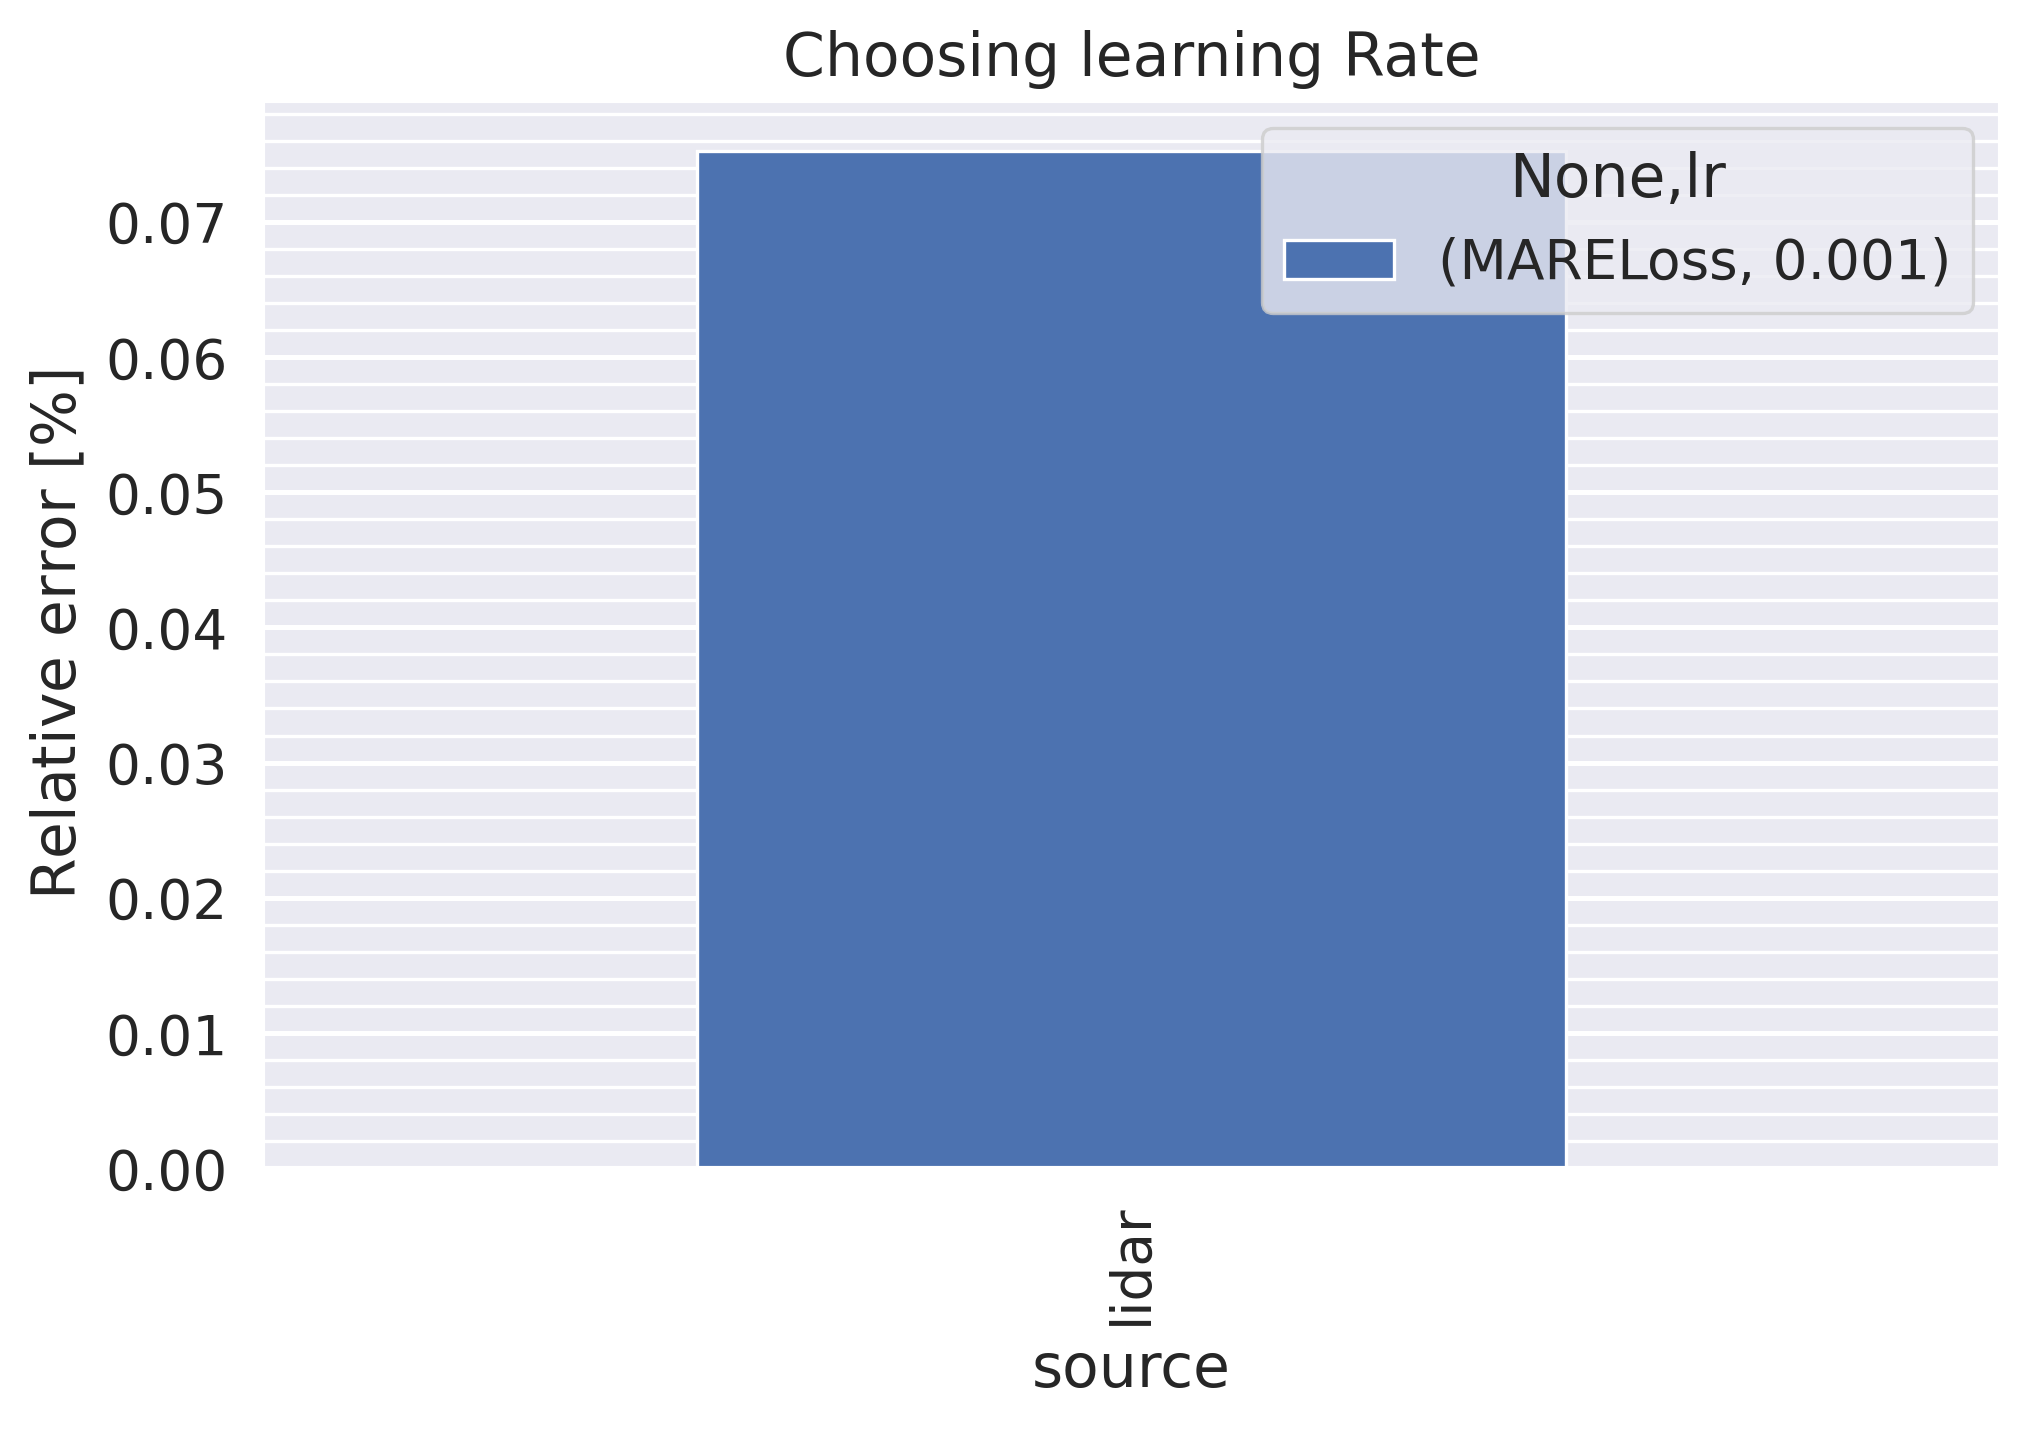

In [9]:
lidar_res = analyse_results[analyse_results.source=='lidar' ]
lidar_res = lidar_res[lidar_res.use_bg==False]
pow_lidar = lidar_res[(~lidar_res.dnorm & lidar_res.use_power ) ]
pow_lidar[pow_lidar.note=='initial_db_overlap']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[pow_lidar.bsize==32][pow_lidar.fc_size>4],#[pow_lidar.note=='ok'],
               values=['MARELoss'],
               columns= ['lr'],
               index=['source'],#'fc_size'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Choosing learning Rate')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
ax.set_ylabel(r'Relative error $[\%]$')
plt.tight_layout()
plt.show()

## 2. FC vs. hidden sizes
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar
> lr = 0.001 or lr = 0.005

In [10]:
all_wav = analyse_results #[analyse_results.wavelength=='all']
all_wavs_configABCD = all_wav[all_wav.config!='Other']

<ipython-input-11-946eca891750>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
<ipython-input-11-946eca891750>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]


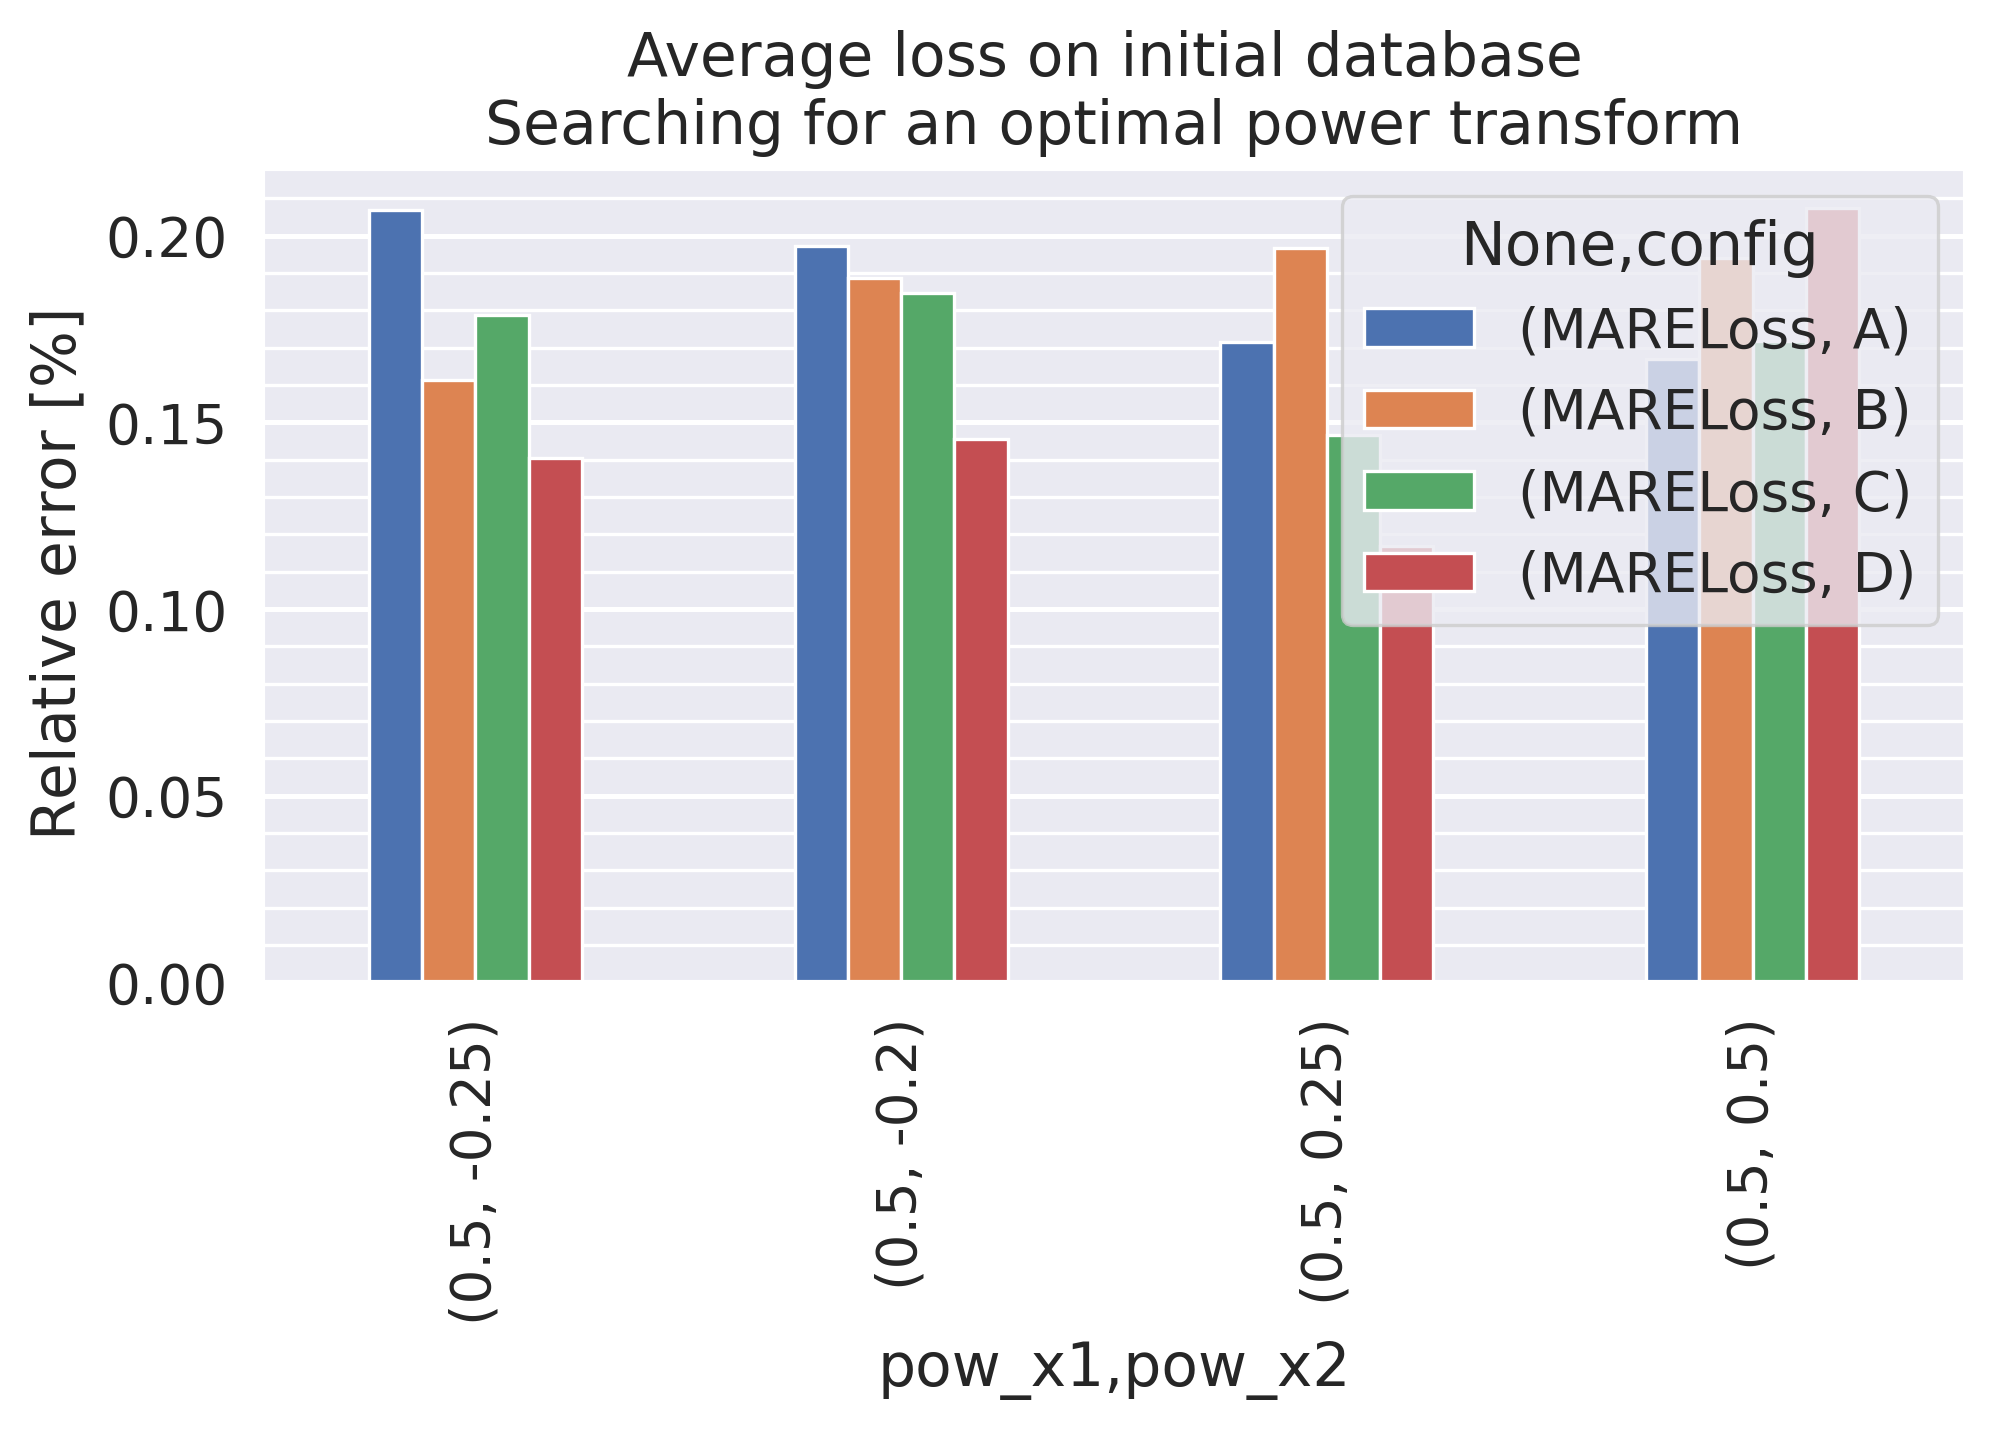

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
               [all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.use_power!=False]
               [all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['pow_x1','pow_x2'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [12]:
tmp = all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
#all_wavs_configABCD
tmp

trial_id                 date  time_total_s  training_iteration  \
0    f63a1_00010  2021-05-20_14-32-54    368.413288                   3   
3    f63a1_00002  2021-05-20_13-33-52    487.011101                   4   
5    f63a1_00014  2021-05-20_15-05-18    360.995325                   3   
6    f63a1_00021  2021-05-20_16-00-05    254.583778                   2   
8    f63a1_00003  2021-05-20_13-39-47    351.581700                   3   
..           ...                  ...           ...                 ...   
921  43c9a_00014  2022-01-25_20-19-30    611.492419                  12   
923  43c9a_00003  2022-01-25_18-11-11    628.167068                  12   
924  43c9a_00032  2022-01-26_00-18-19    898.996409                  10   
926  43c9a_00039  2022-01-26_01-47-02    683.937706                  12   
927  43c9a_00001  2022-01-25_17-49-22    568.472628                  11   

             loss  MARELoss  bsize                 dfilter  dnorm  fc_size  \
0       28.360804  0.184768     32                     NaN  False       16   
3       27.449078  0.166987     32                     NaN  False       16   
5       28.307669  0.171466     32                     NaN  False       16   
6       26.271549  0.161435     32                     NaN  False       32   
8       31.079670  0.193936     32                     NaN  False       32   
..            ...       ...    ...                     ...    ...      ...   
921  10922.100586  0.304116     32   ['wavelength', [532]]   True       32   
923  15780.711914  0.612005     32  ['wavelength', [1064]]   True       16   
924   4494.187988  0.210574     32                     NaN   True       16   
926   8717.419922  0.315267     32  ['wavelength', [1064]]   True       32   
927   3734.357910  0.313495     32   ['wavelength', [355]]   True       16   

     ...                 powers                note  \
0    ...   ([0.5, -0.2], [0.5])          initial_db   
3    ...    ([0.5, 0.5], [0.5])          initial_db   
5    ...   ([0.5, 0.25], [0.5])          initial_db   
6    ...  ([0.5, -0.25], [0.5])          initial_db   
8    ...    ([0.5, 0.5], [0.5])          initial_db   
..   ...                    ...                 ...   
921  ...                   None  initial_db_overlap   
923  ...                   None  initial_db_overlap   
924  ...                   None  initial_db_overlap   
926  ...                   None  initial_db_overlap   
927  ...                   None  initial_db_overlap   

                                                logdir pow_y pow_x1  pow_x2  \
0    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5   -0.20   
3    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5    0.50   
5    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5    0.25   
6    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5   -0.25   
8    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5    0.50   
..                                                 ...   ...    ...     ...   
921  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   NaN    NaN     NaN   
923  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   NaN    NaN     NaN   
924  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   NaN    NaN     NaN   
926  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   NaN    NaN     NaN   
927  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   NaN    NaN     NaN   

    pow_x3 u_hsize wavelength  config  
0      NaN    True        all       C  
3      NaN    True        all       A  
5      NaN    True        all       A  
6      NaN    True        all       B  
8      NaN    True        all       B  
..     ...     ...        ...     ...  
921    NaN    True        532       D  
923    NaN    True       1064       A  
924    NaN    True        all       A  
926    NaN    True       1064       B  
927    NaN    True        355       A  

[564 rows x 26 columns]

<ipython-input-13-b23f3d78b36a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr'][all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],


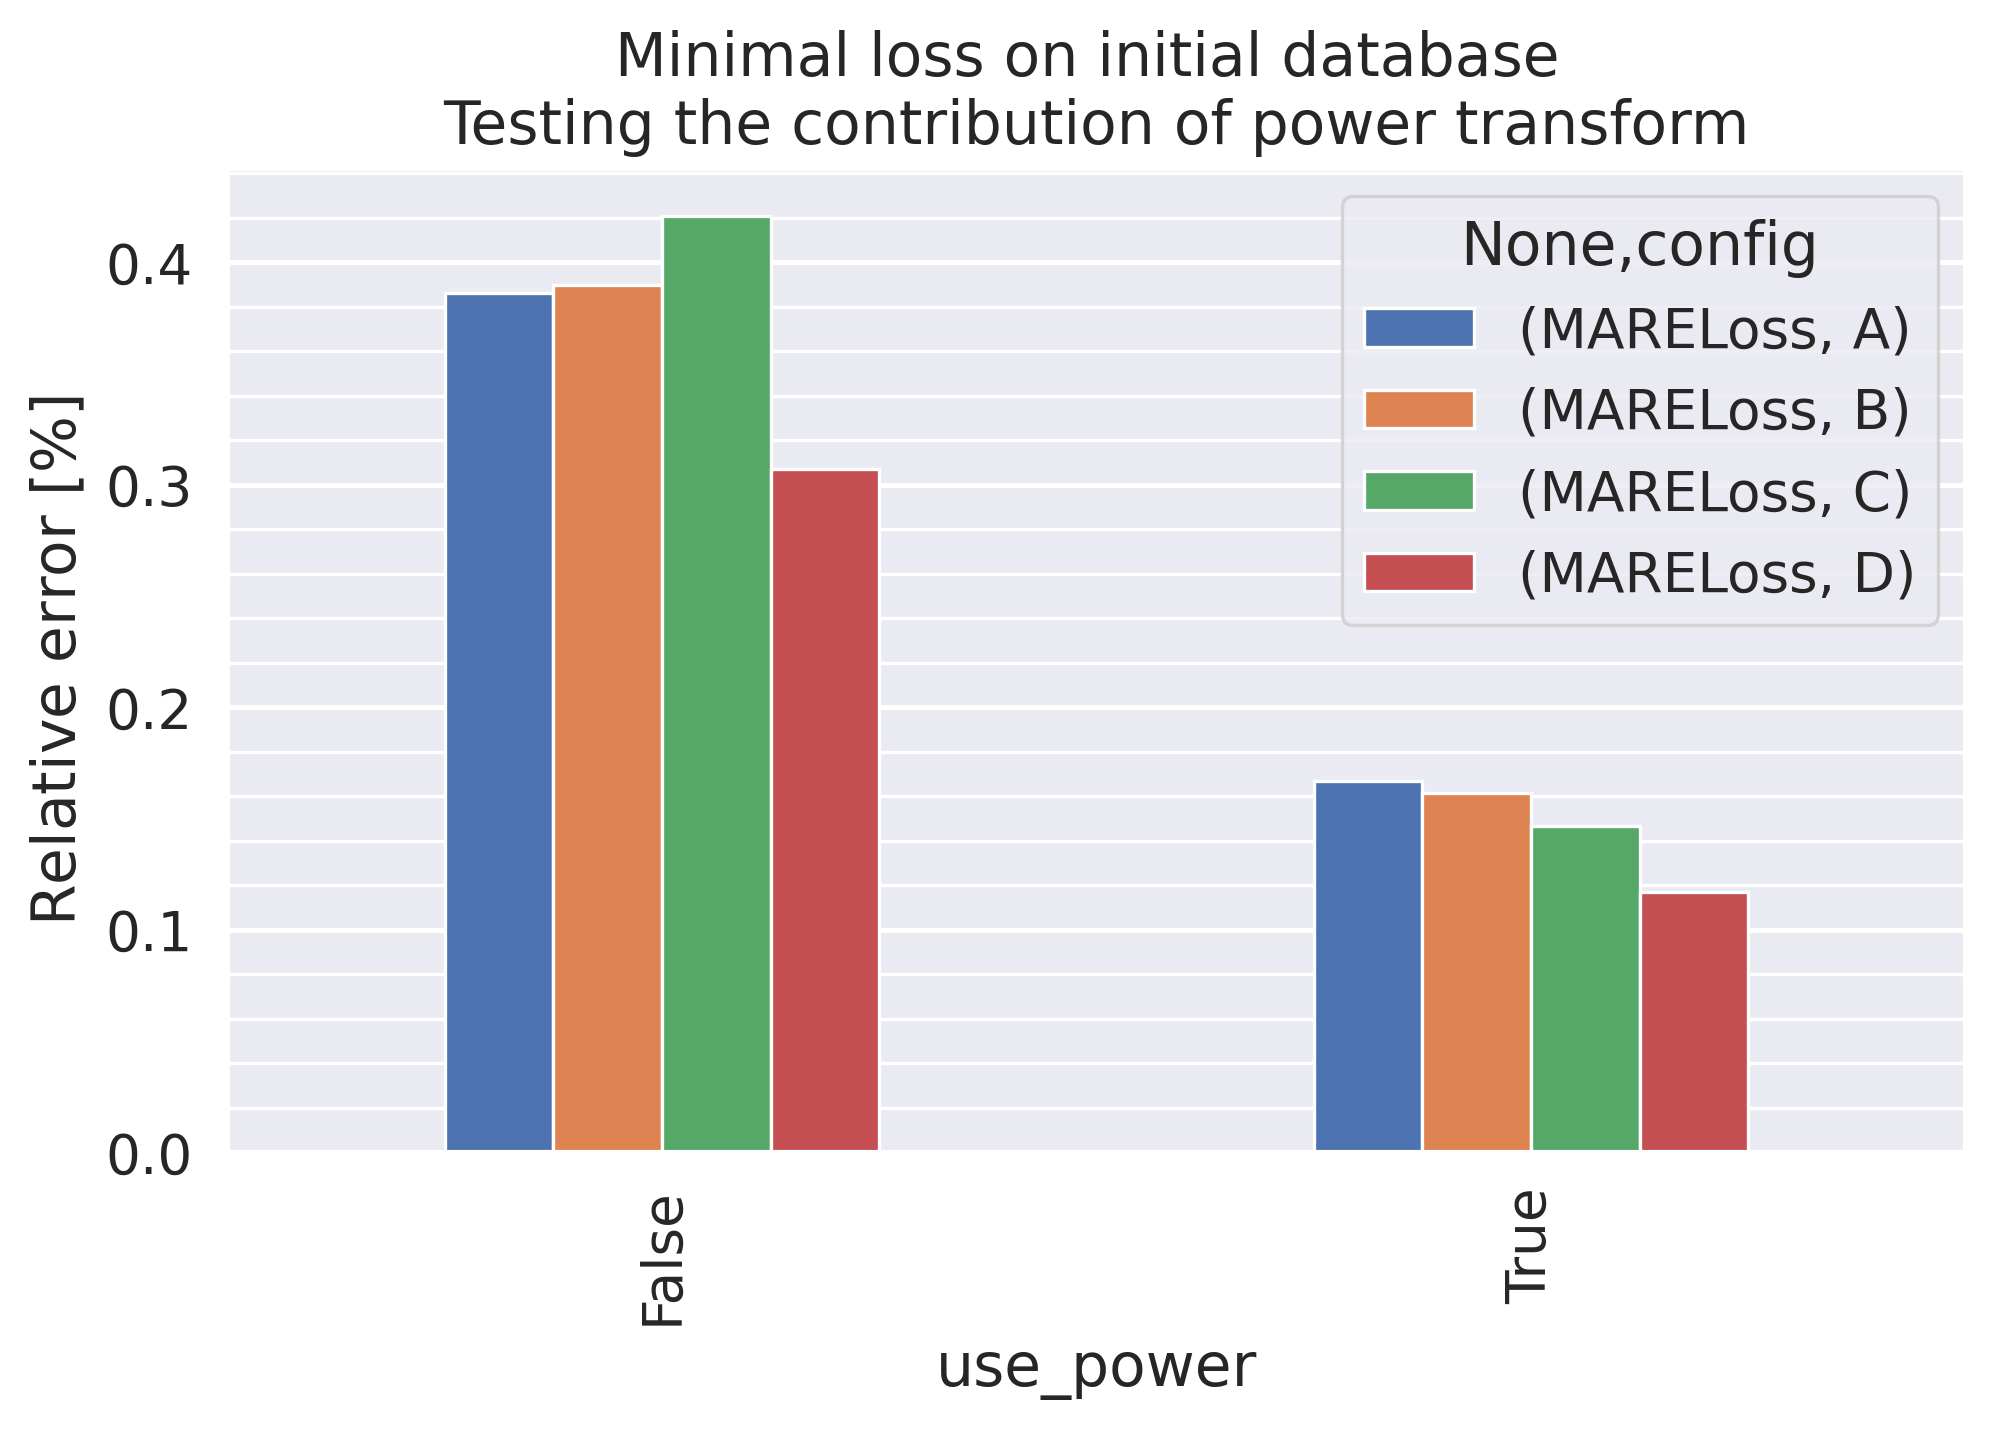

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr'][all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the contribution of power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-14-a7e10f560838>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],


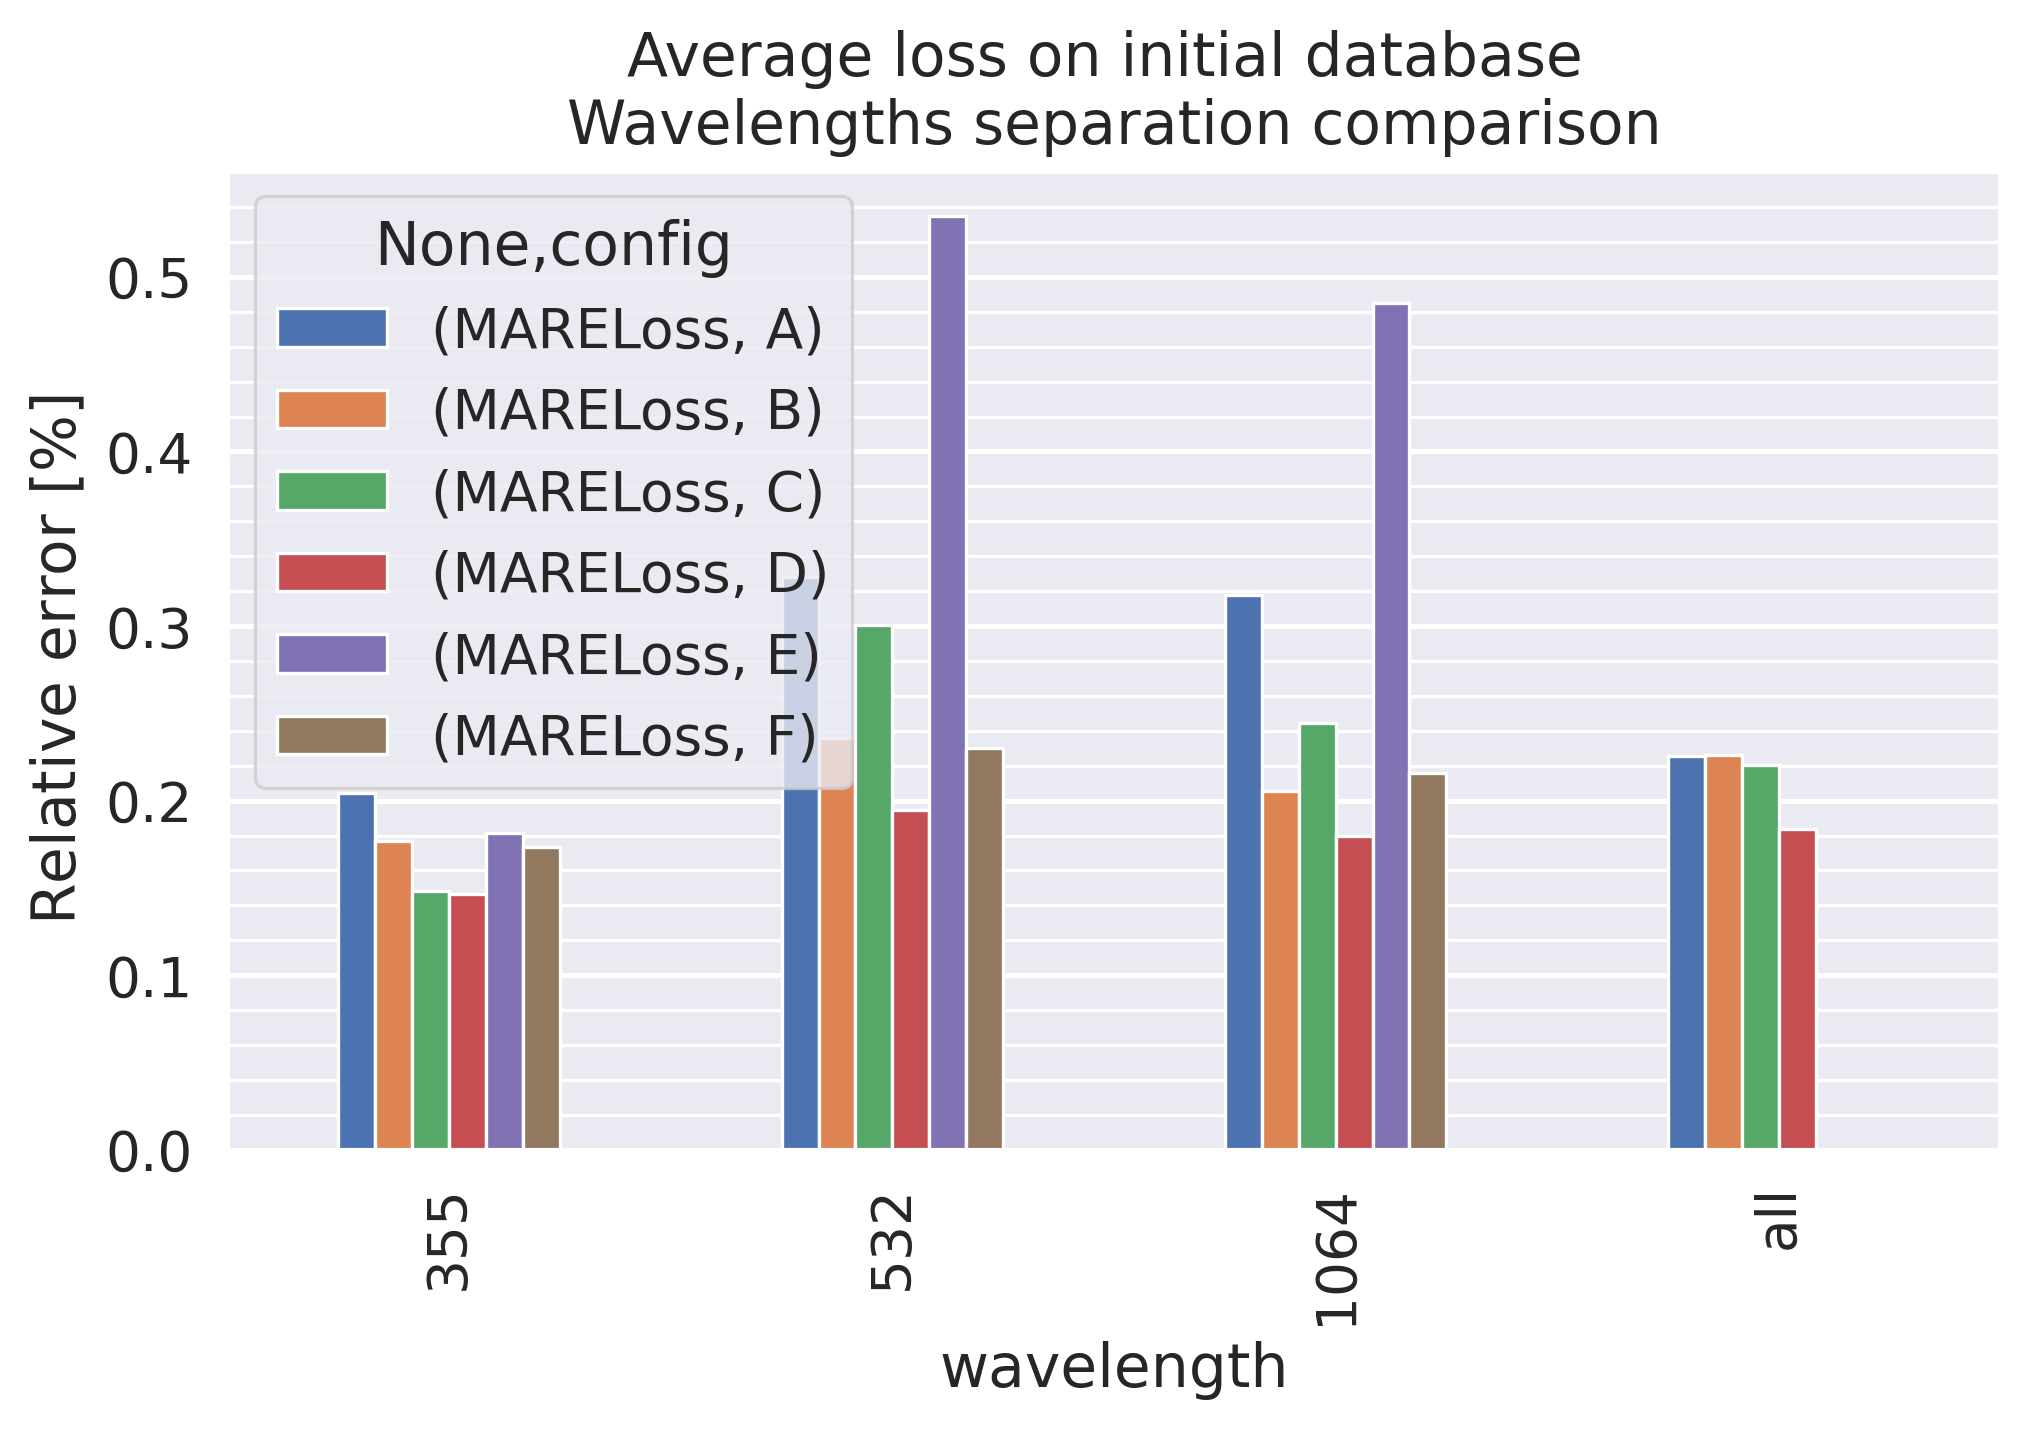

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Wavelengths separation comparison ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-15-e12a5c488a91>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


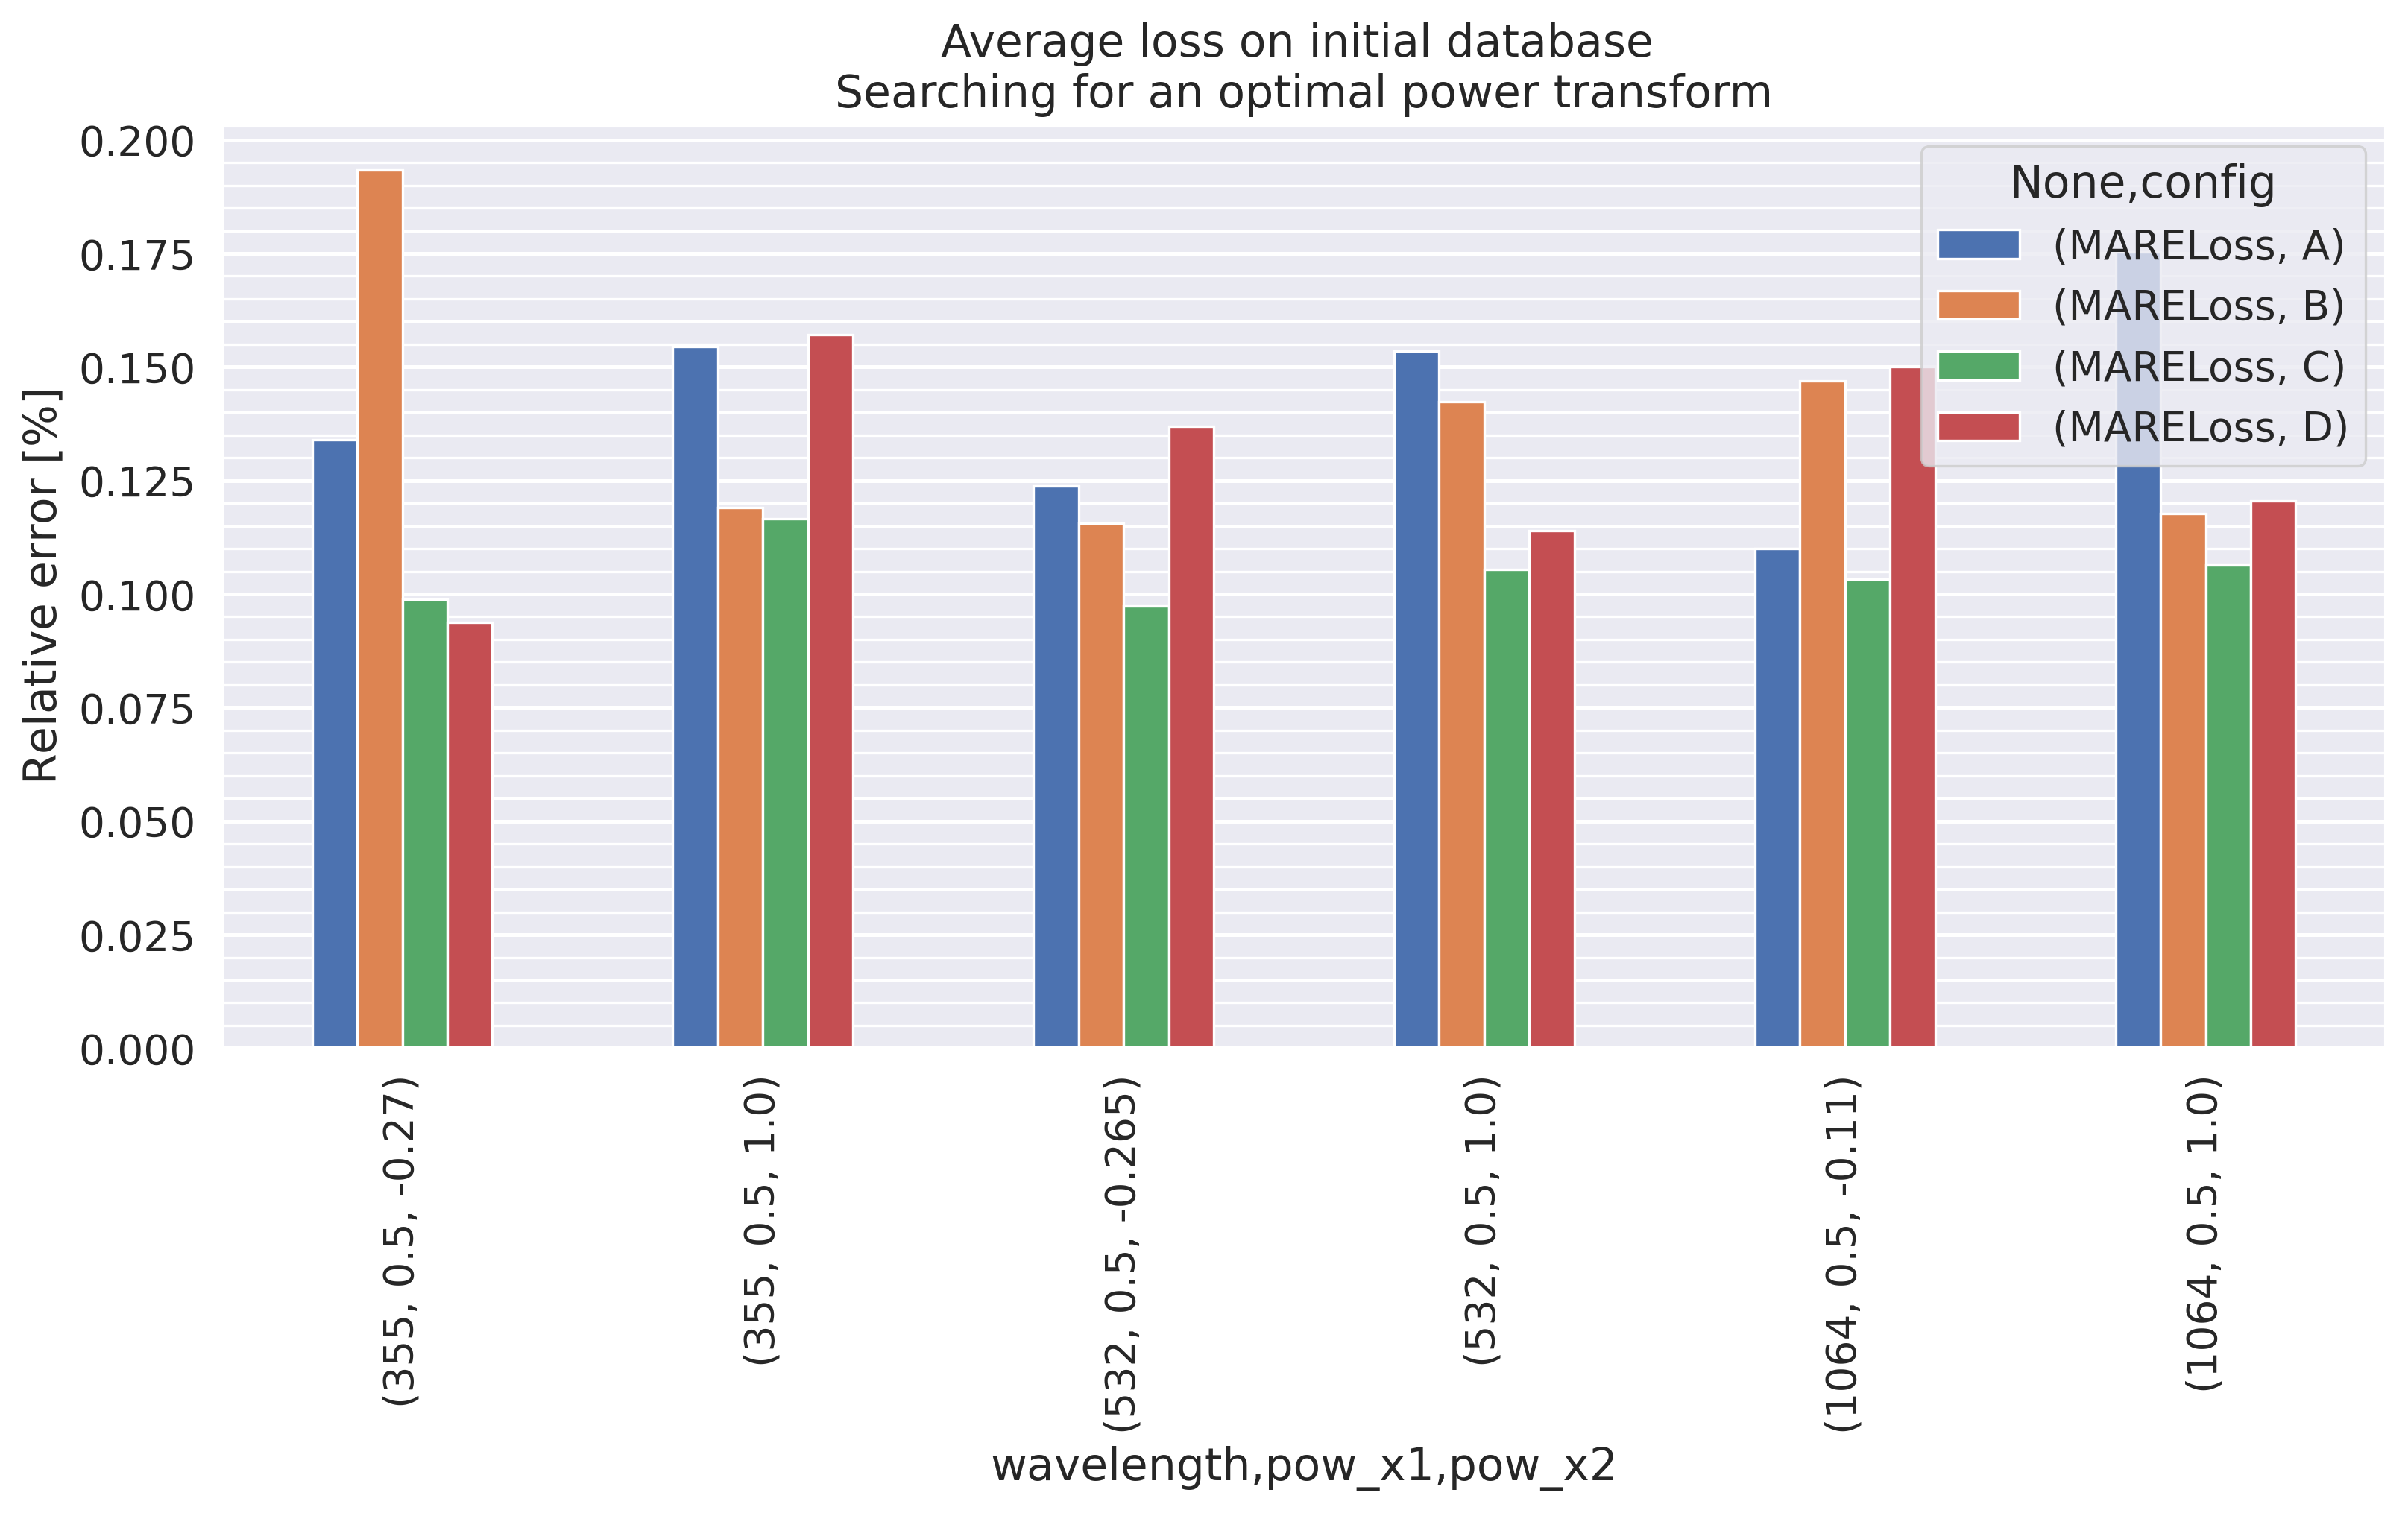

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-16-c9c96c5e9d22>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],


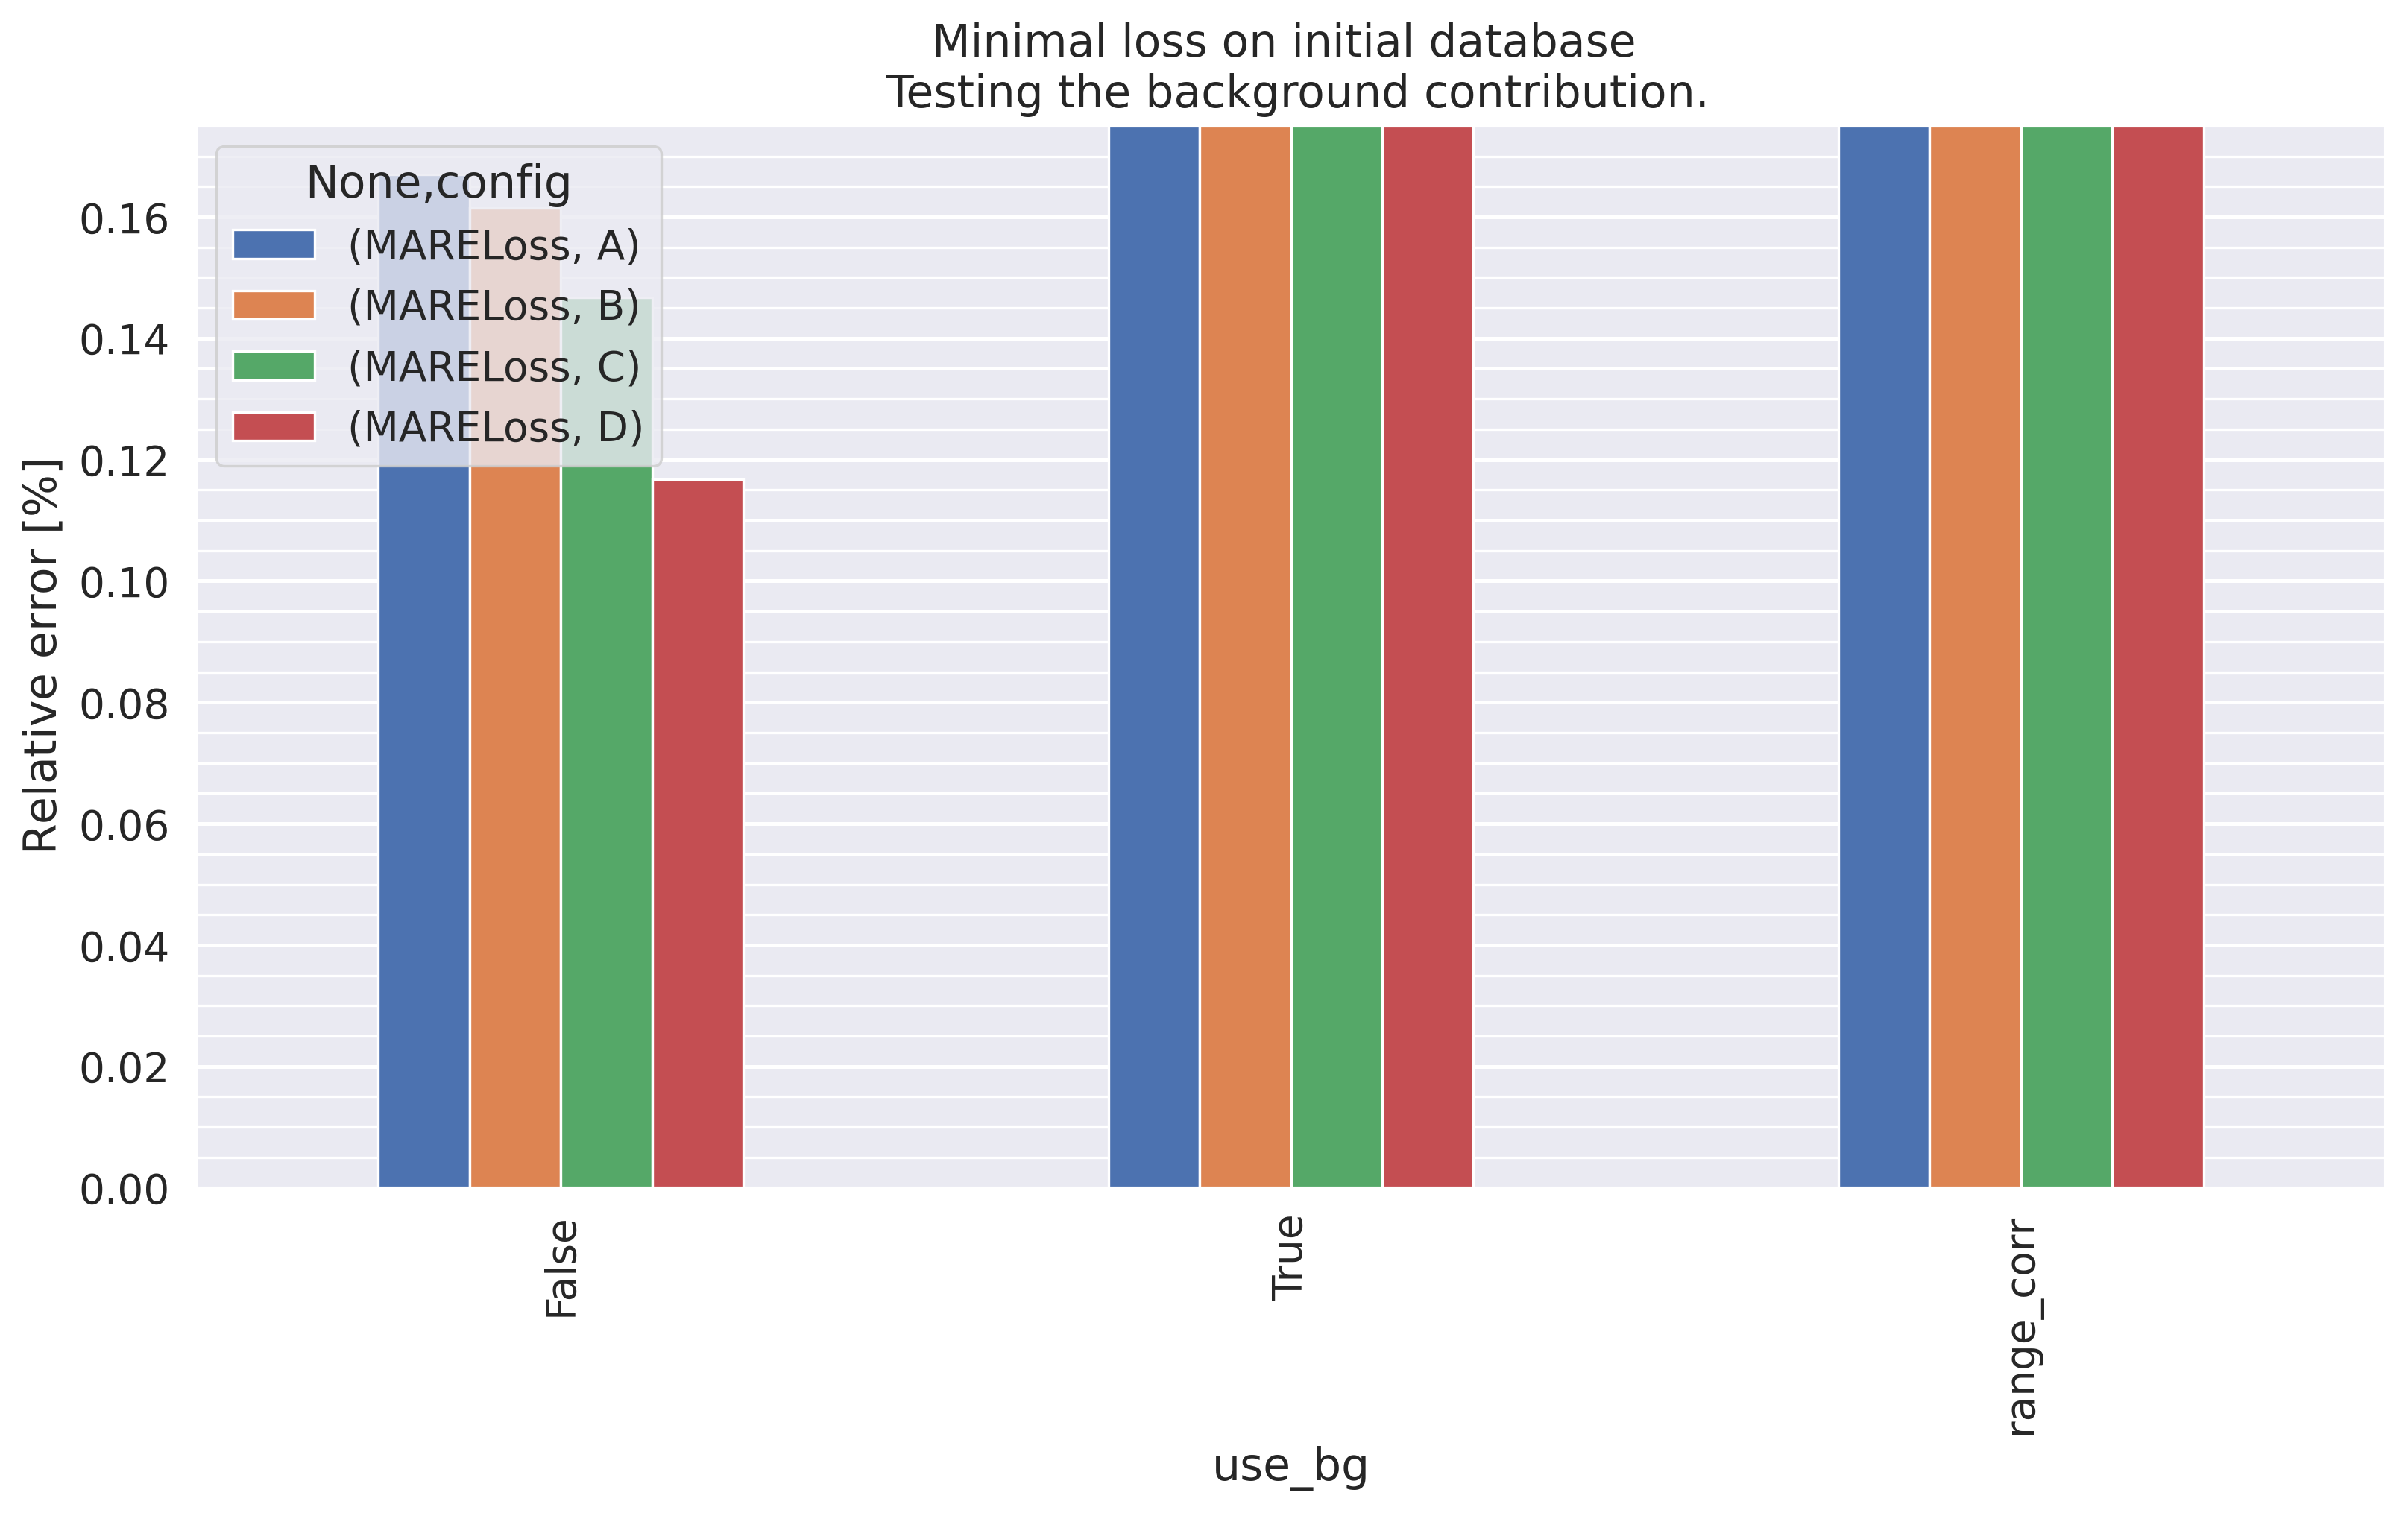

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution.')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.set_ylim([0.0, 0.175])
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-17-9bb2dd6716b6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],


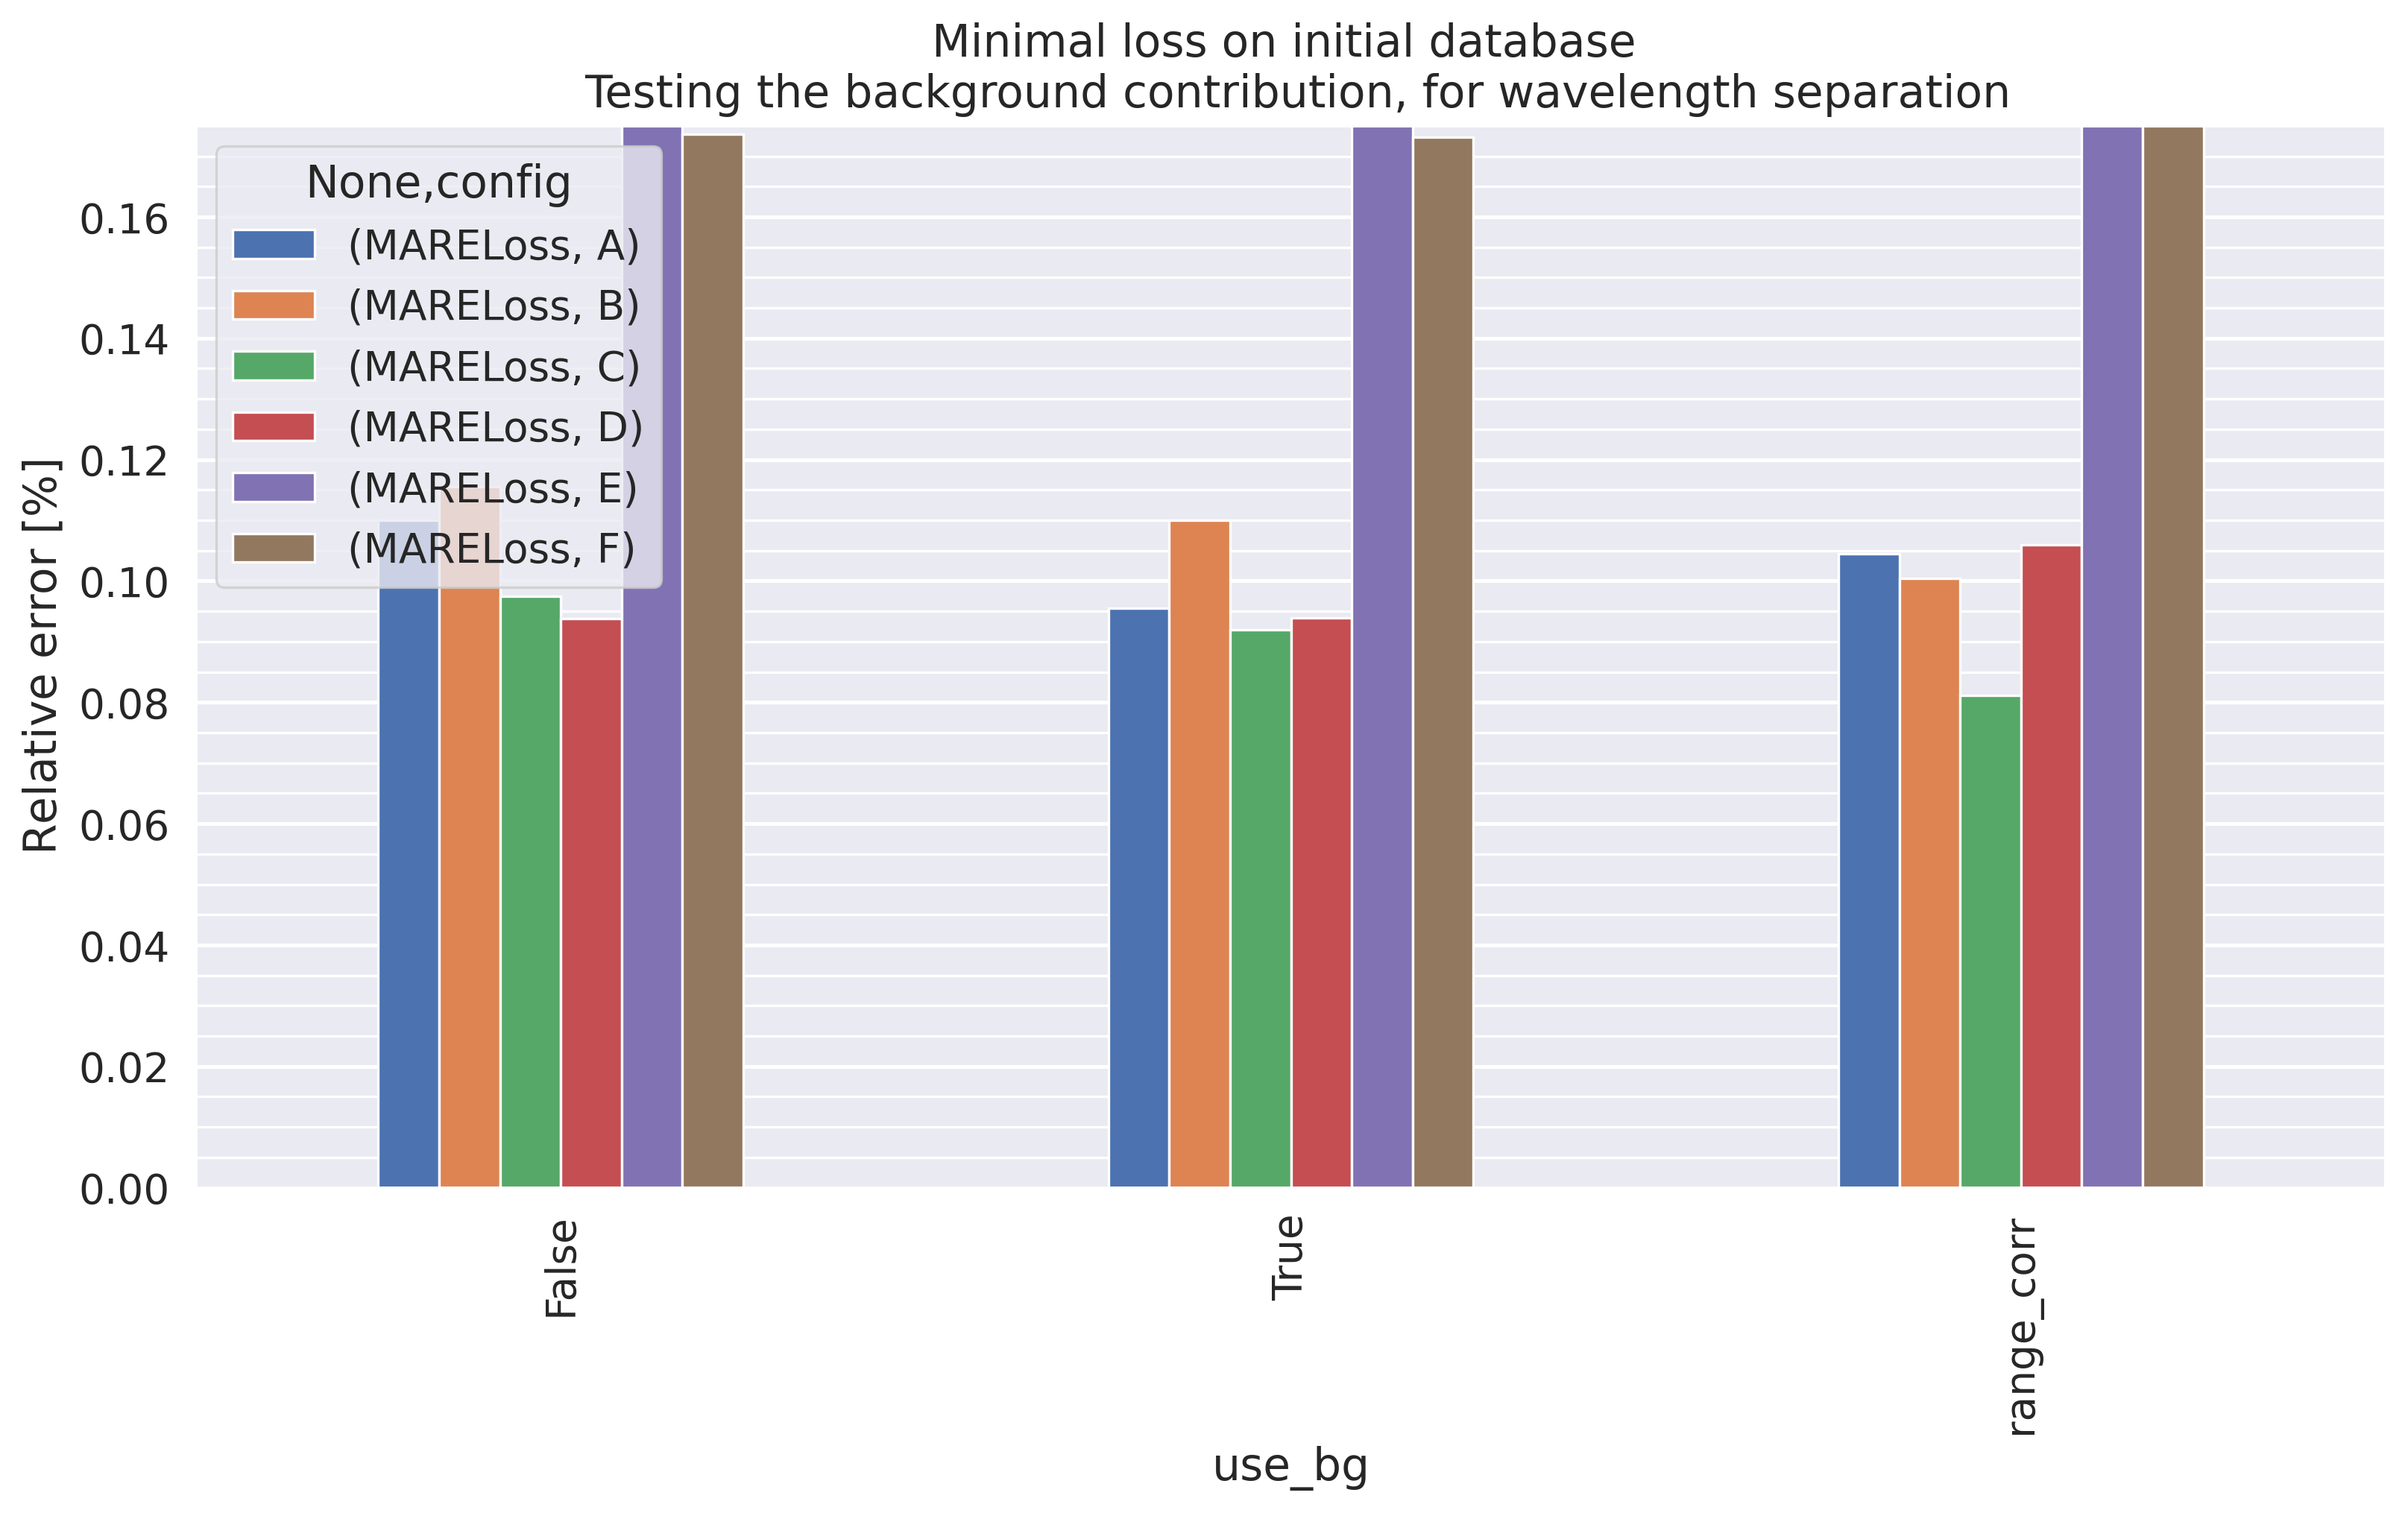

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution, for wavelength separation')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylim([0.0, 0.175])
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-18-b9fb5c6e891f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],


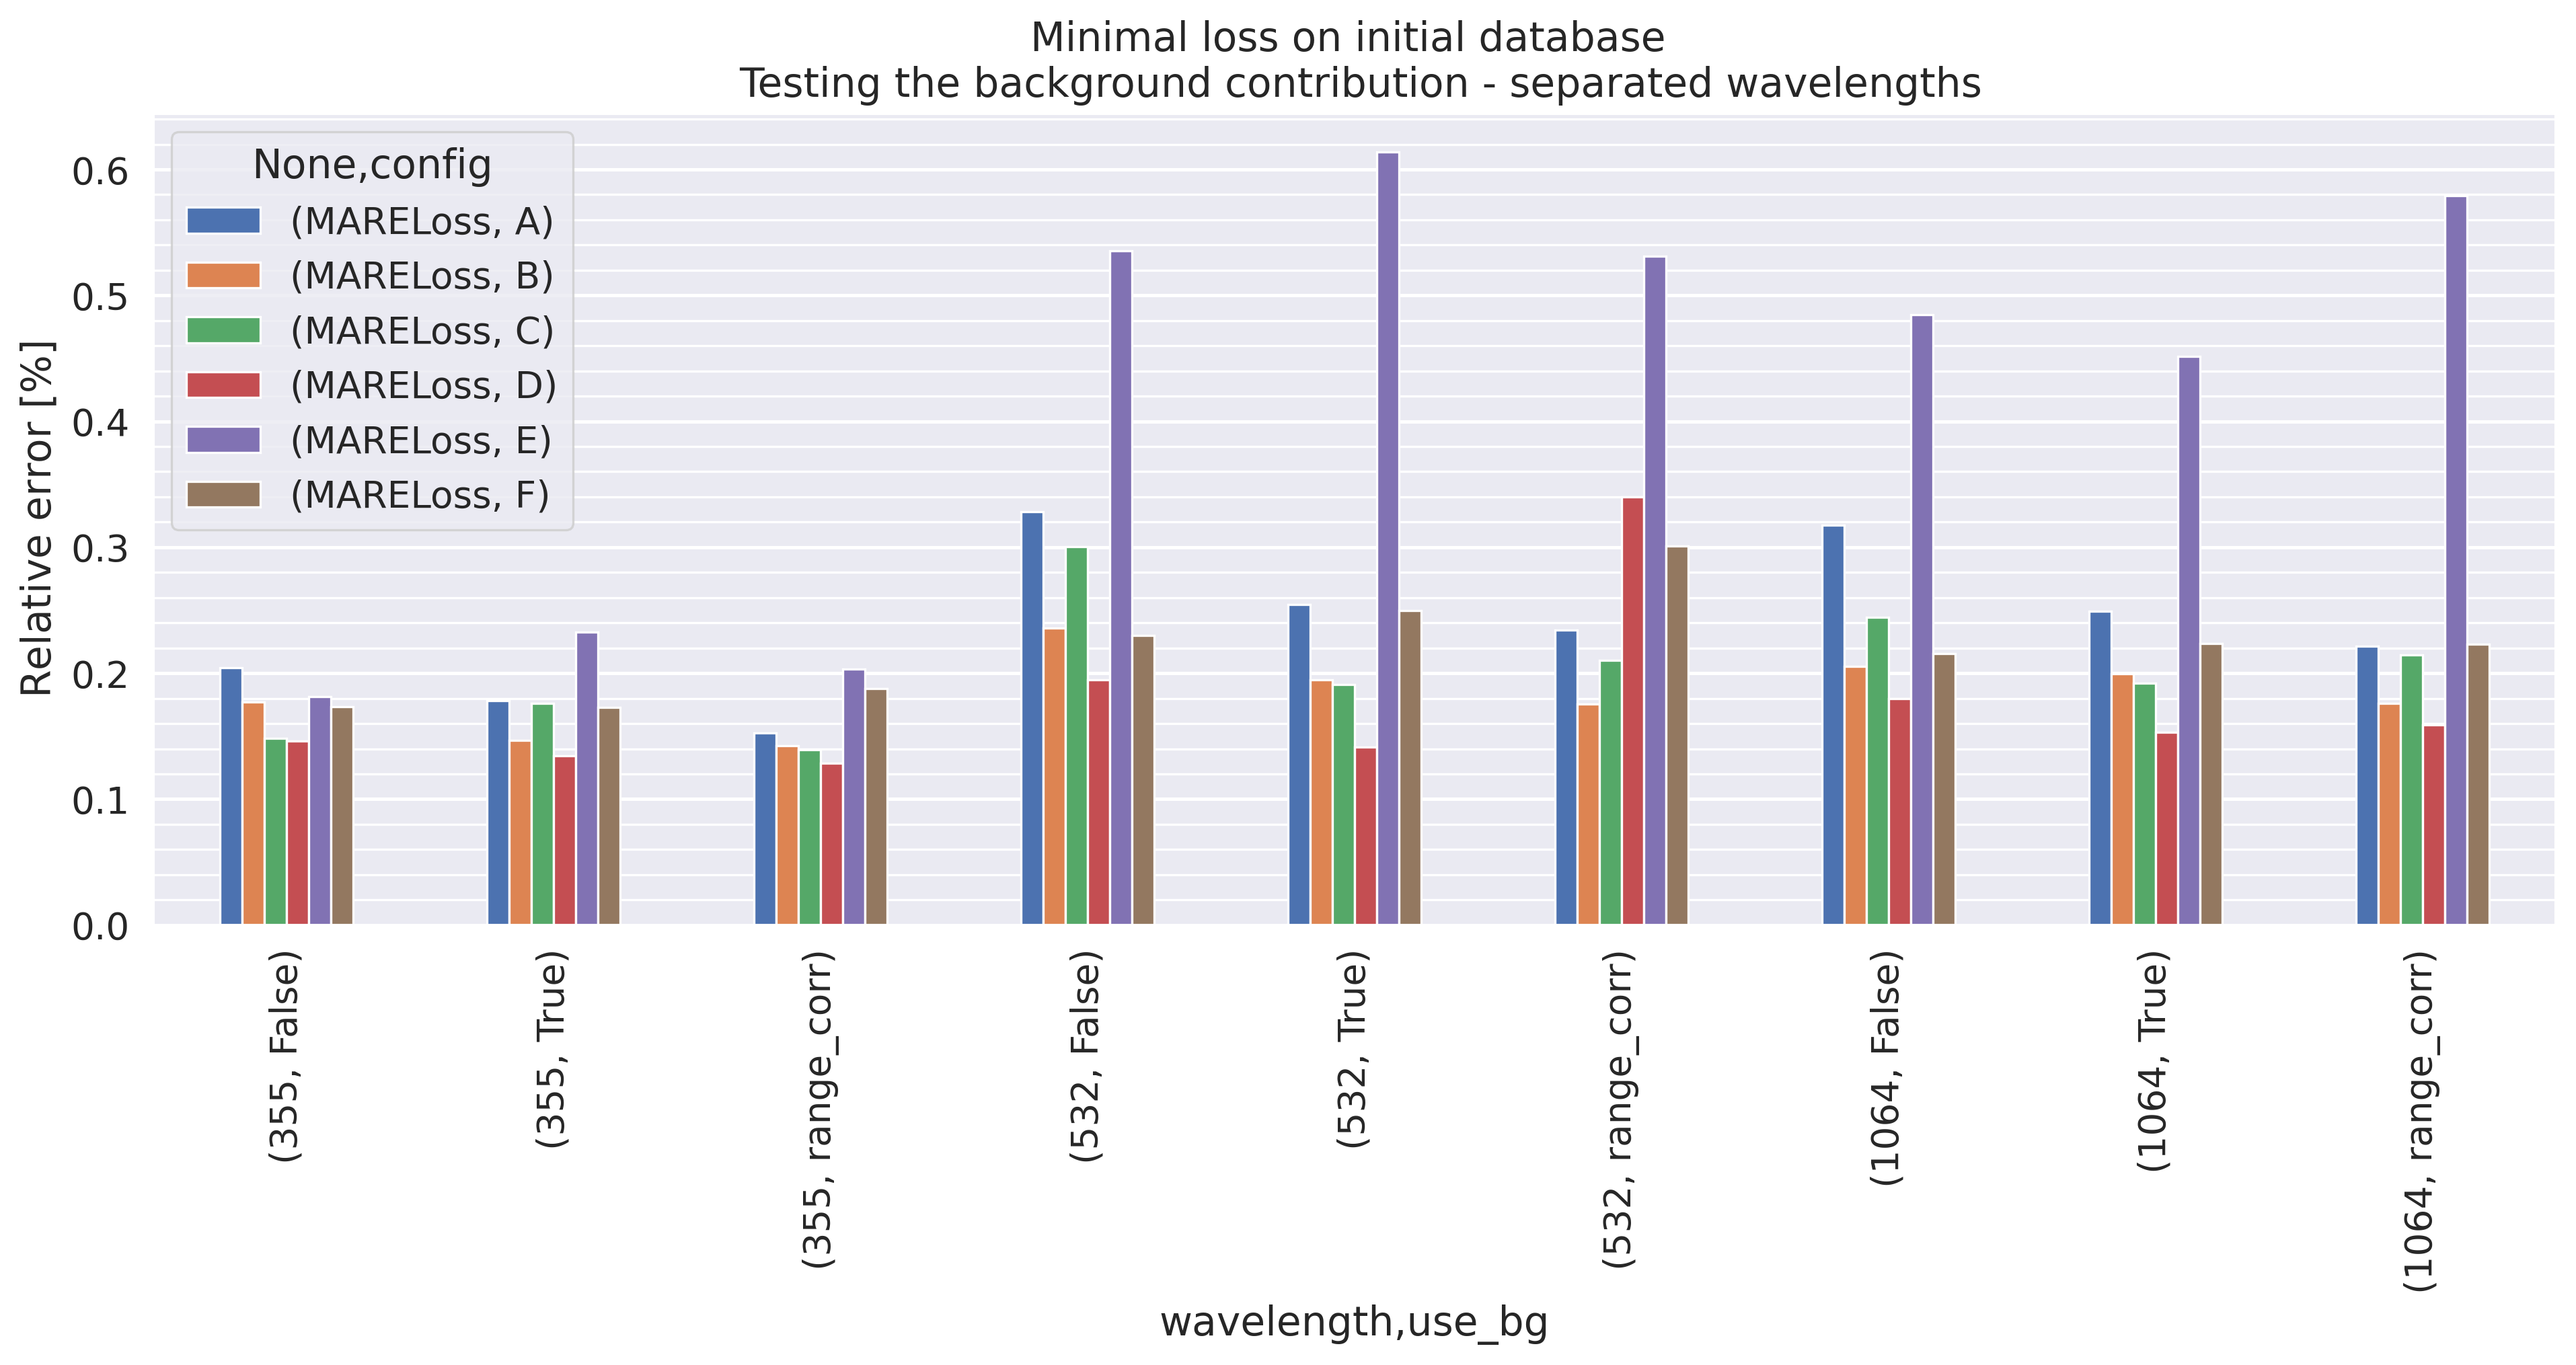

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_bg'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution - separated wavelengths')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


<ipython-input-19-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


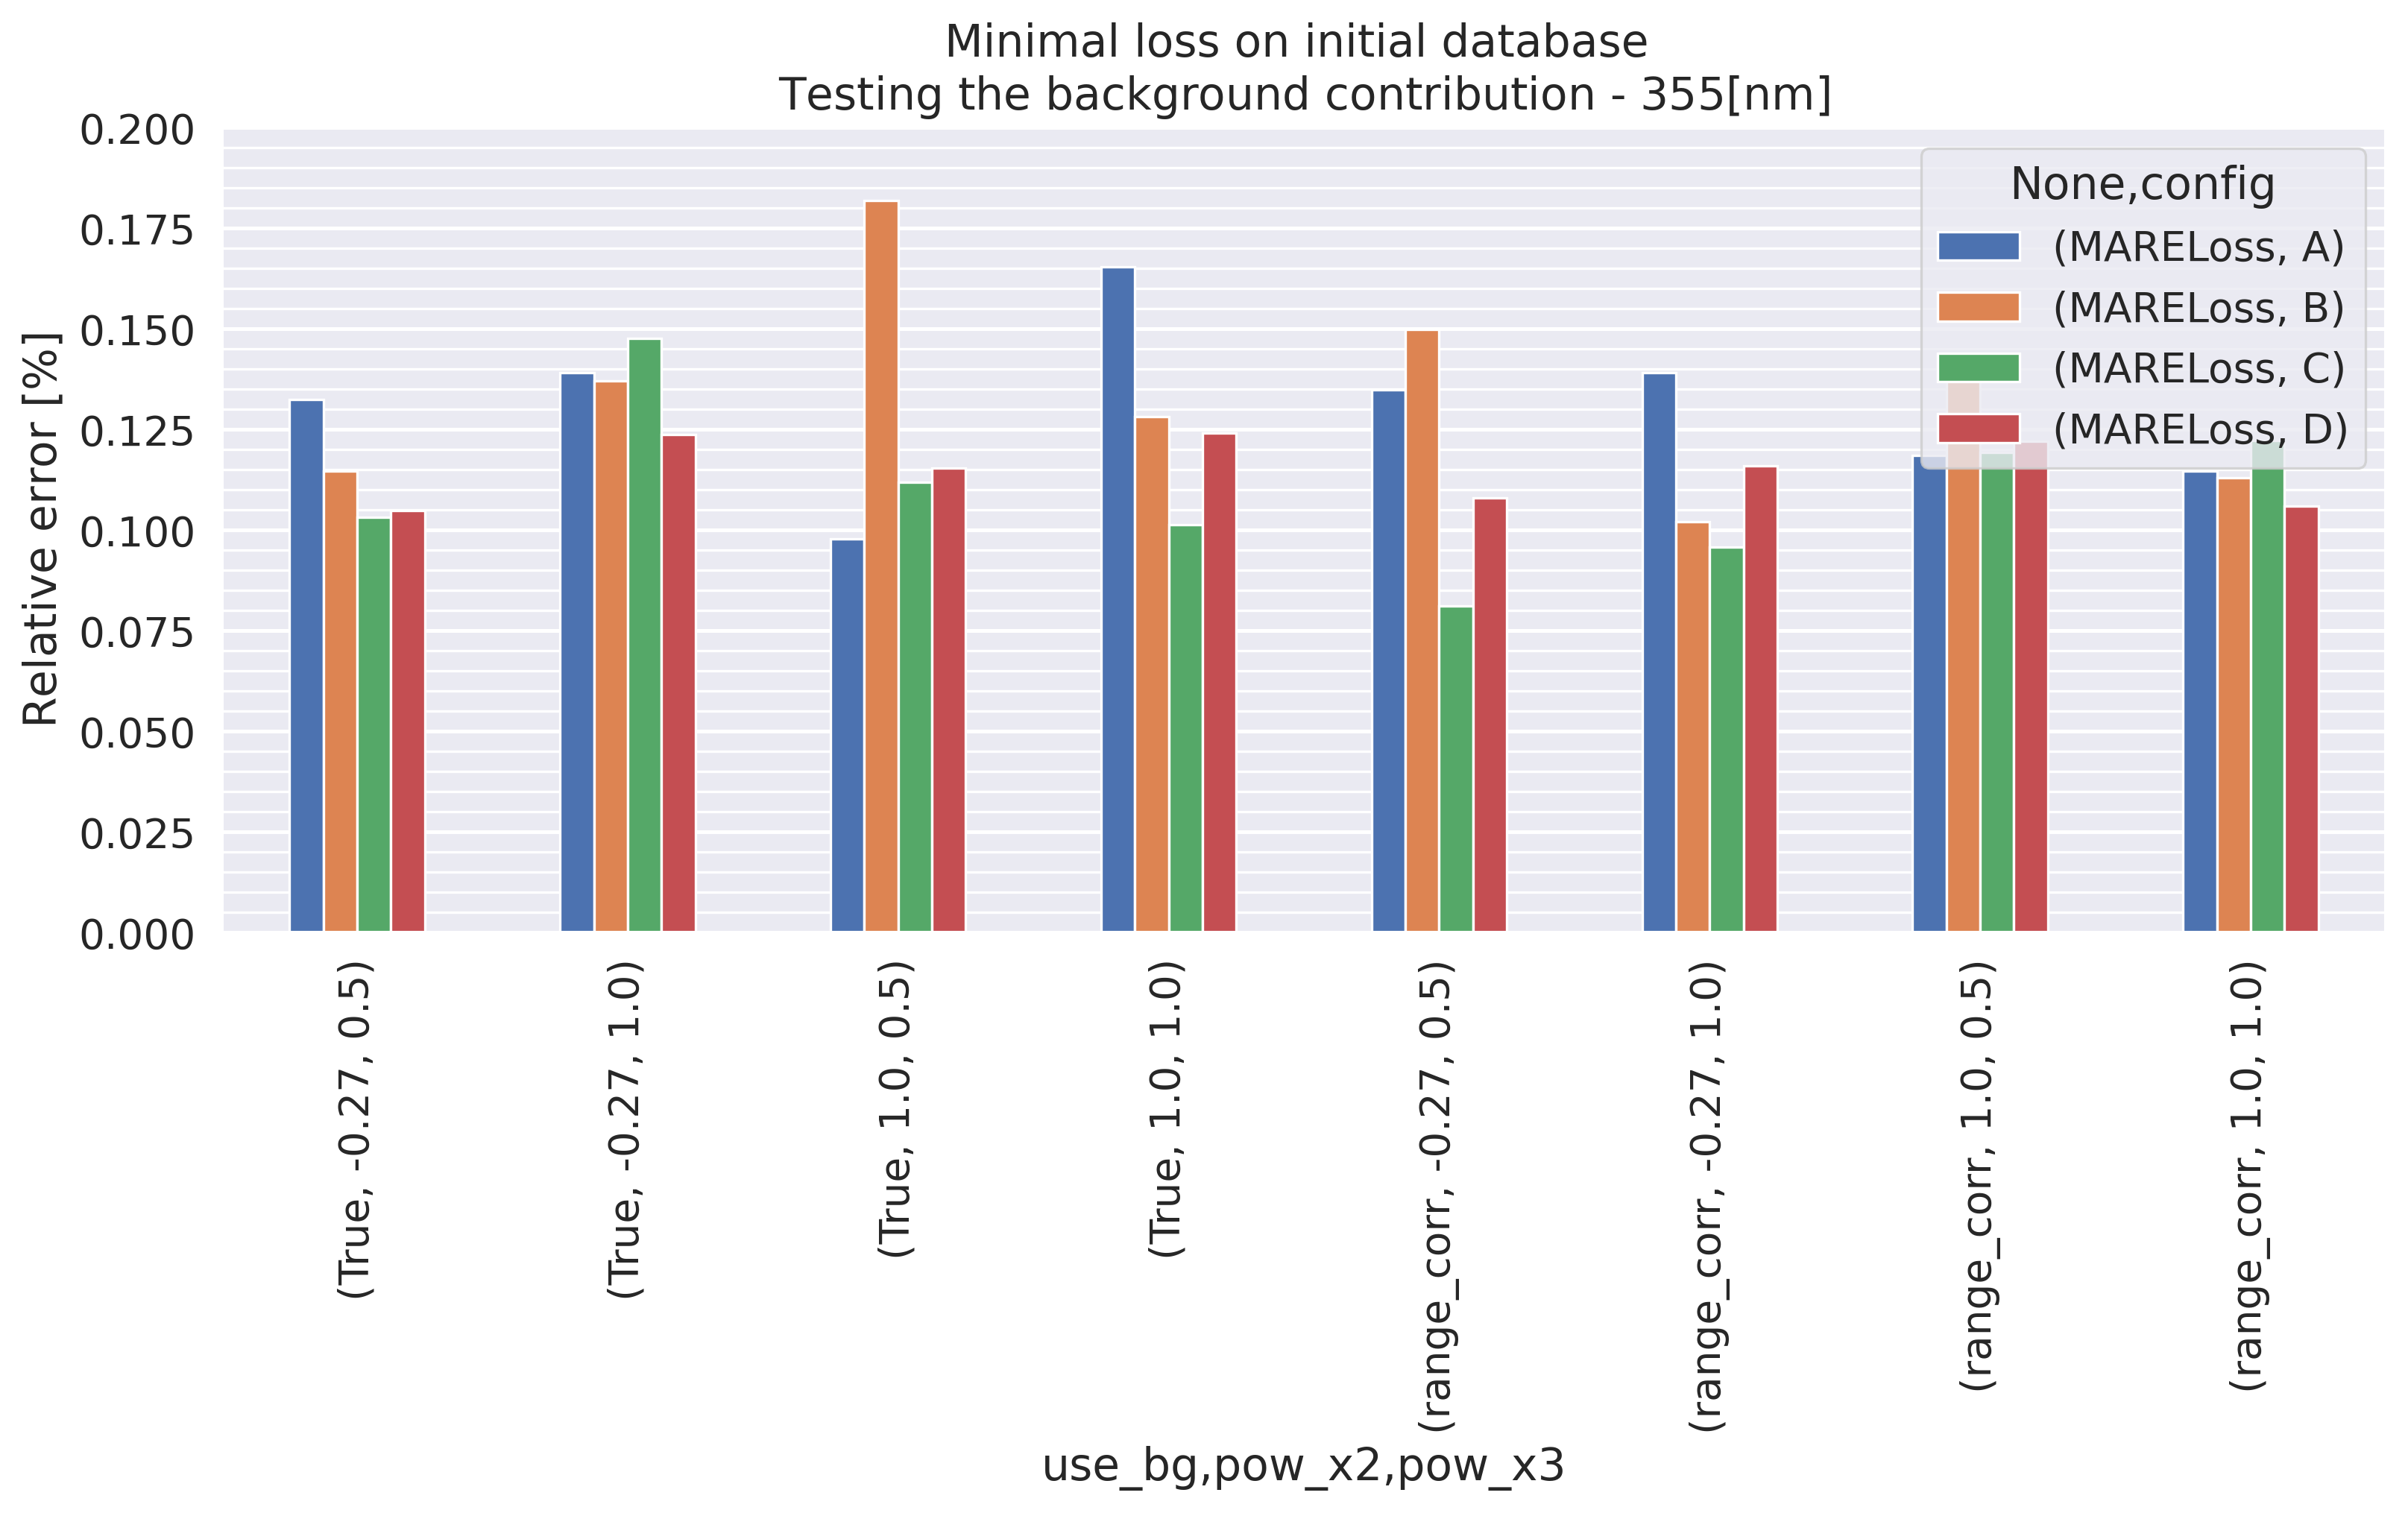

<ipython-input-19-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


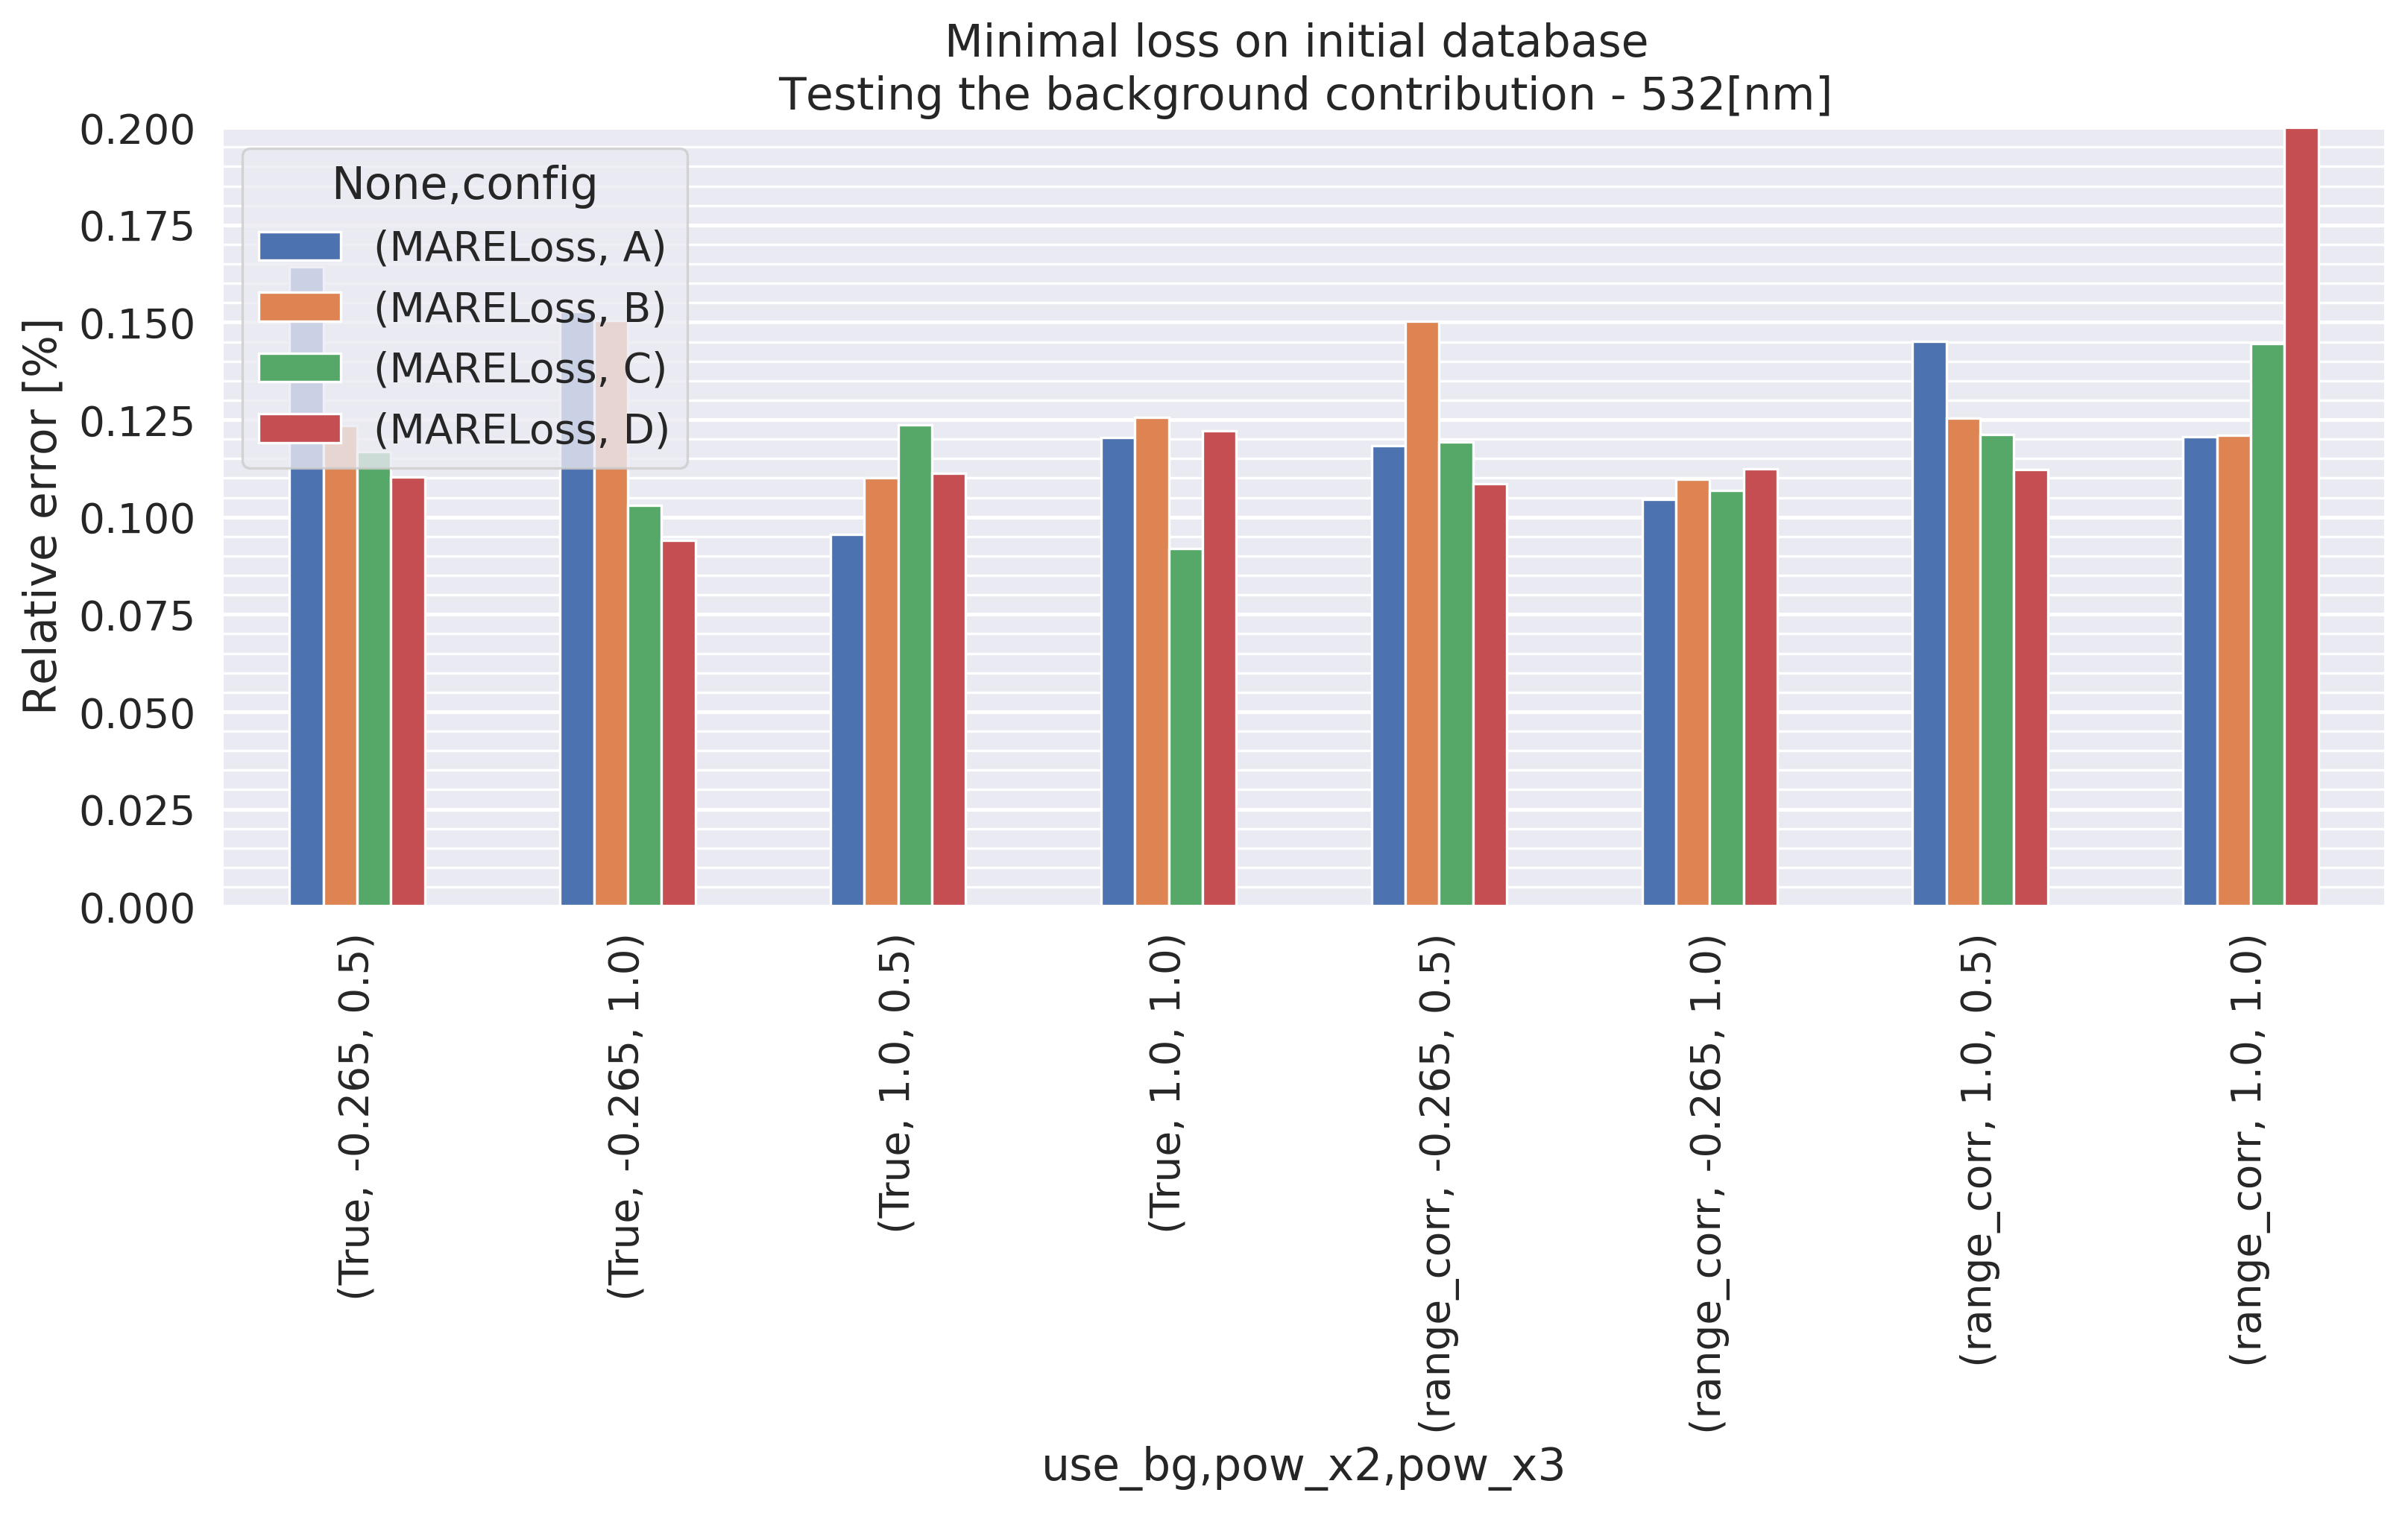

<ipython-input-19-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


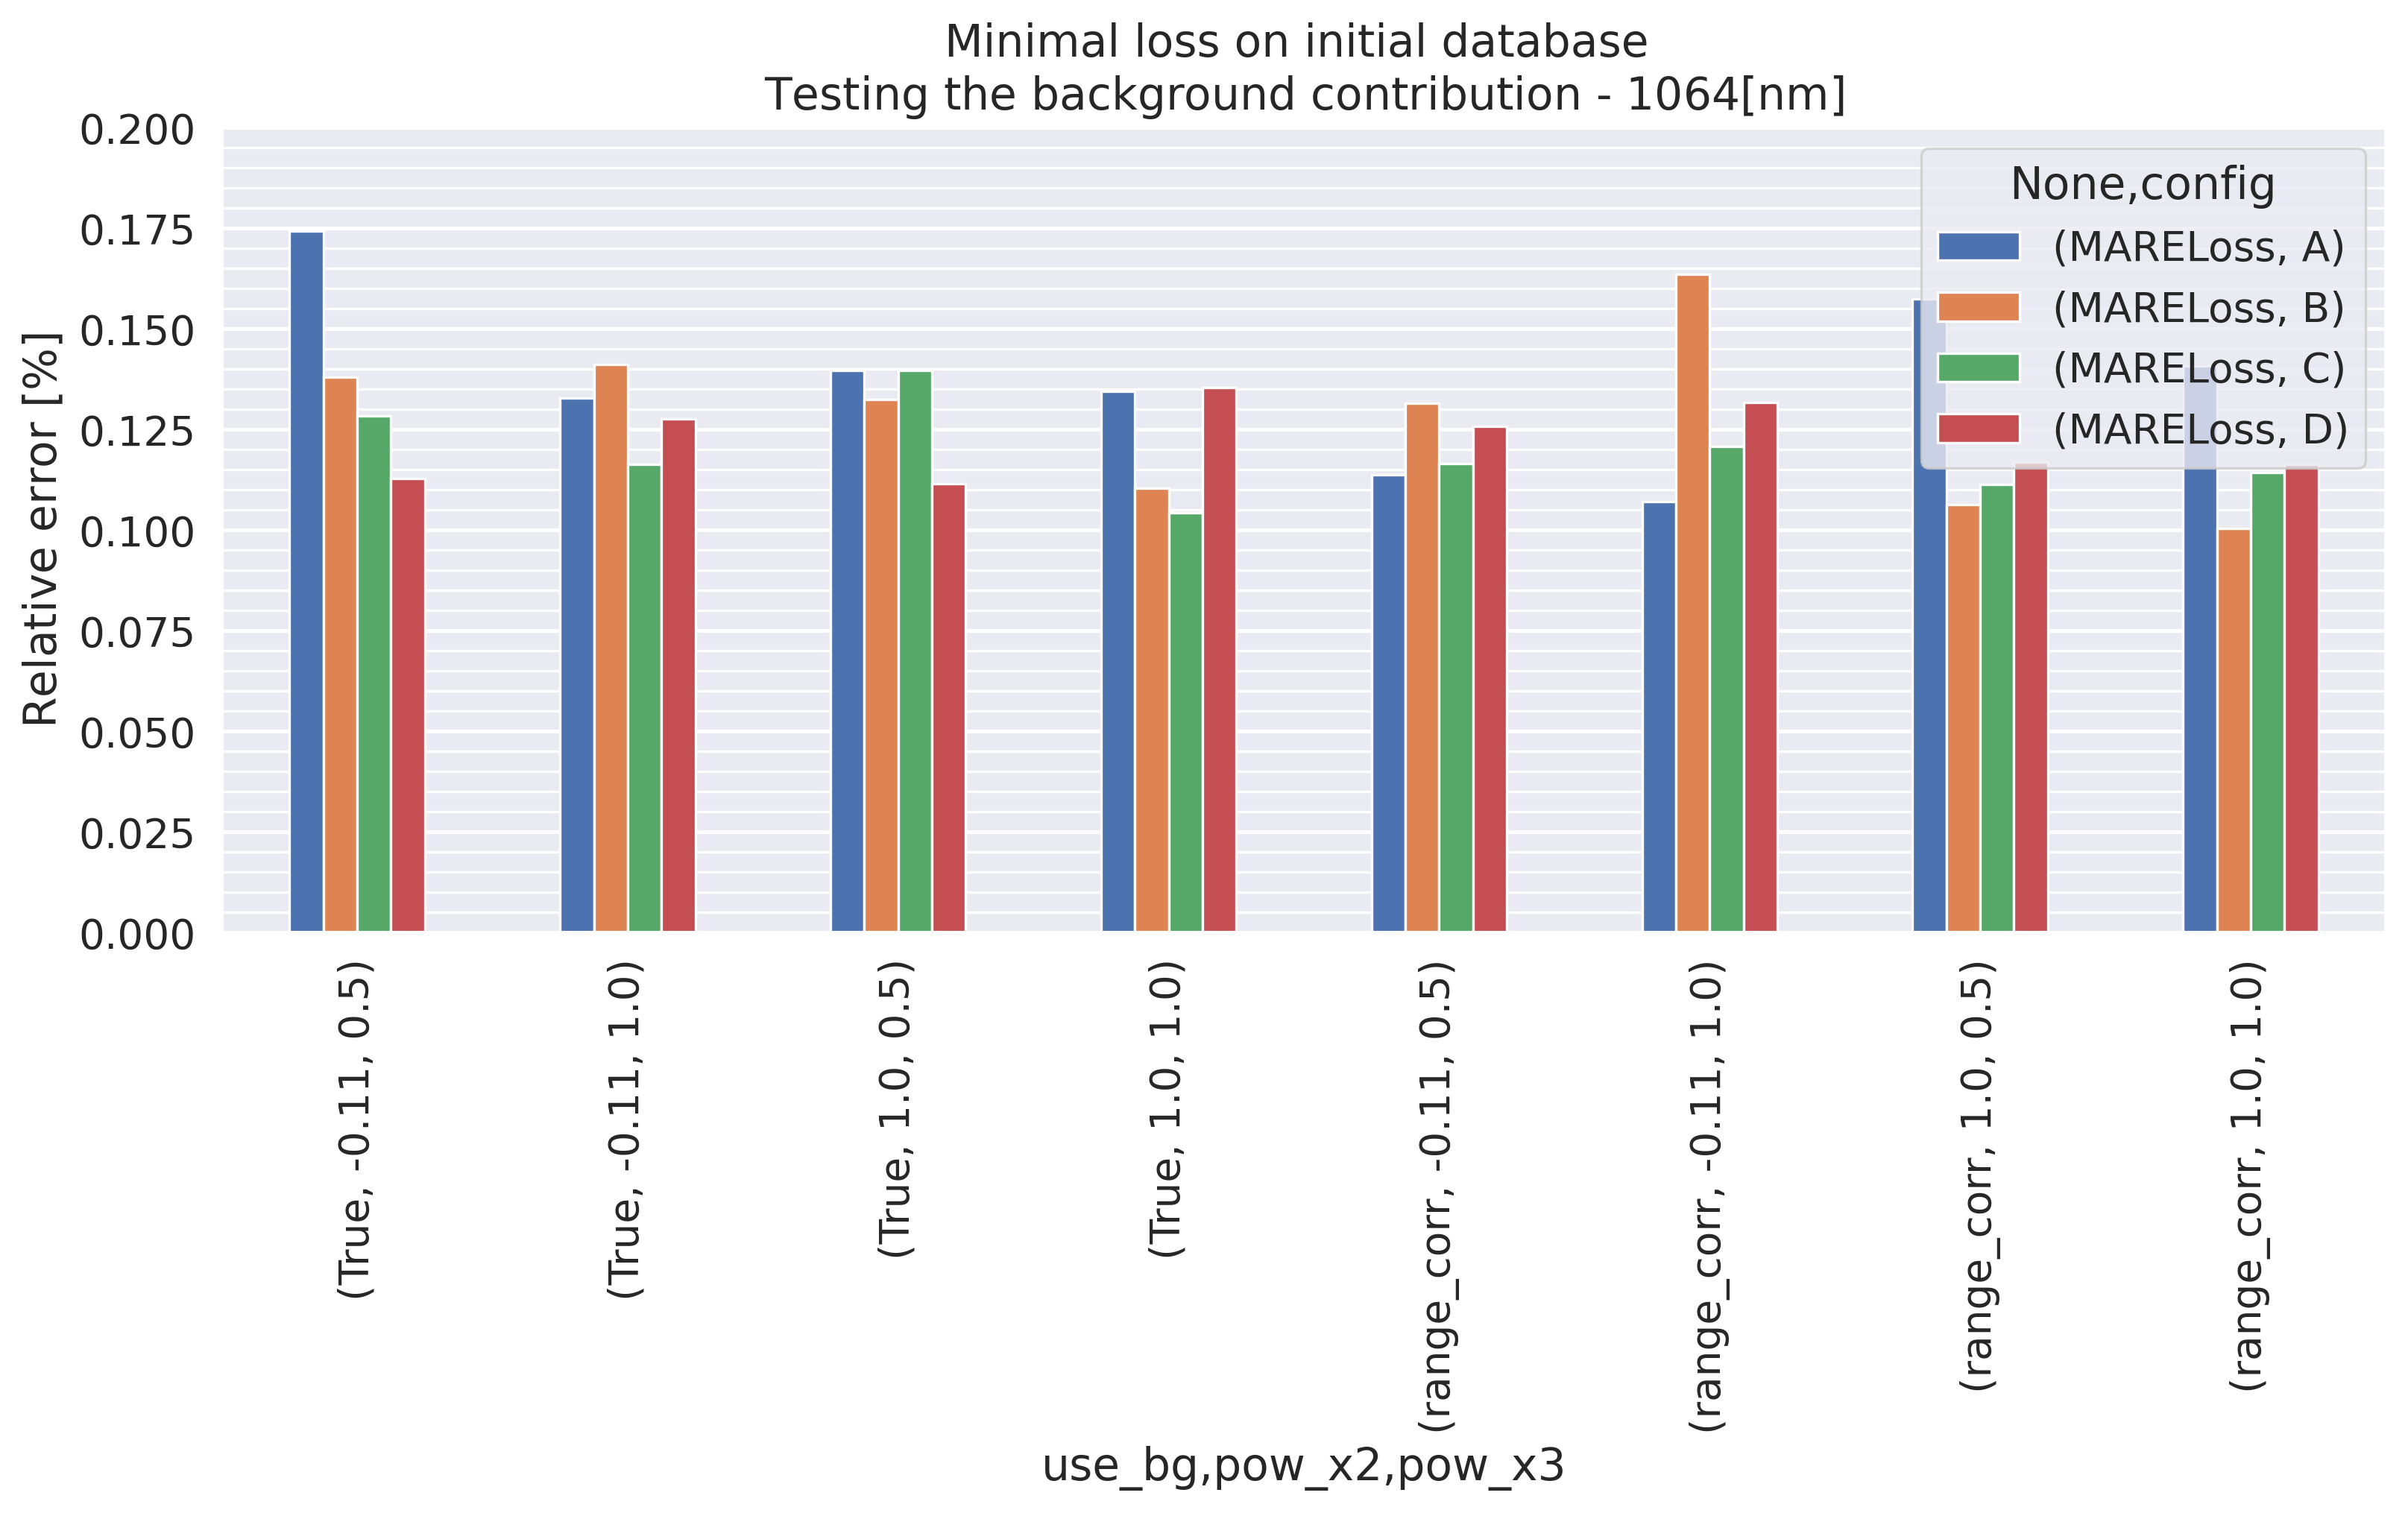

In [19]:
#wavelength =532
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on initial database \n'+fr'Testing the background contribution - ${wavelength}[\rm nm]$')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()

<ipython-input-20-a5742928cd4f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr']


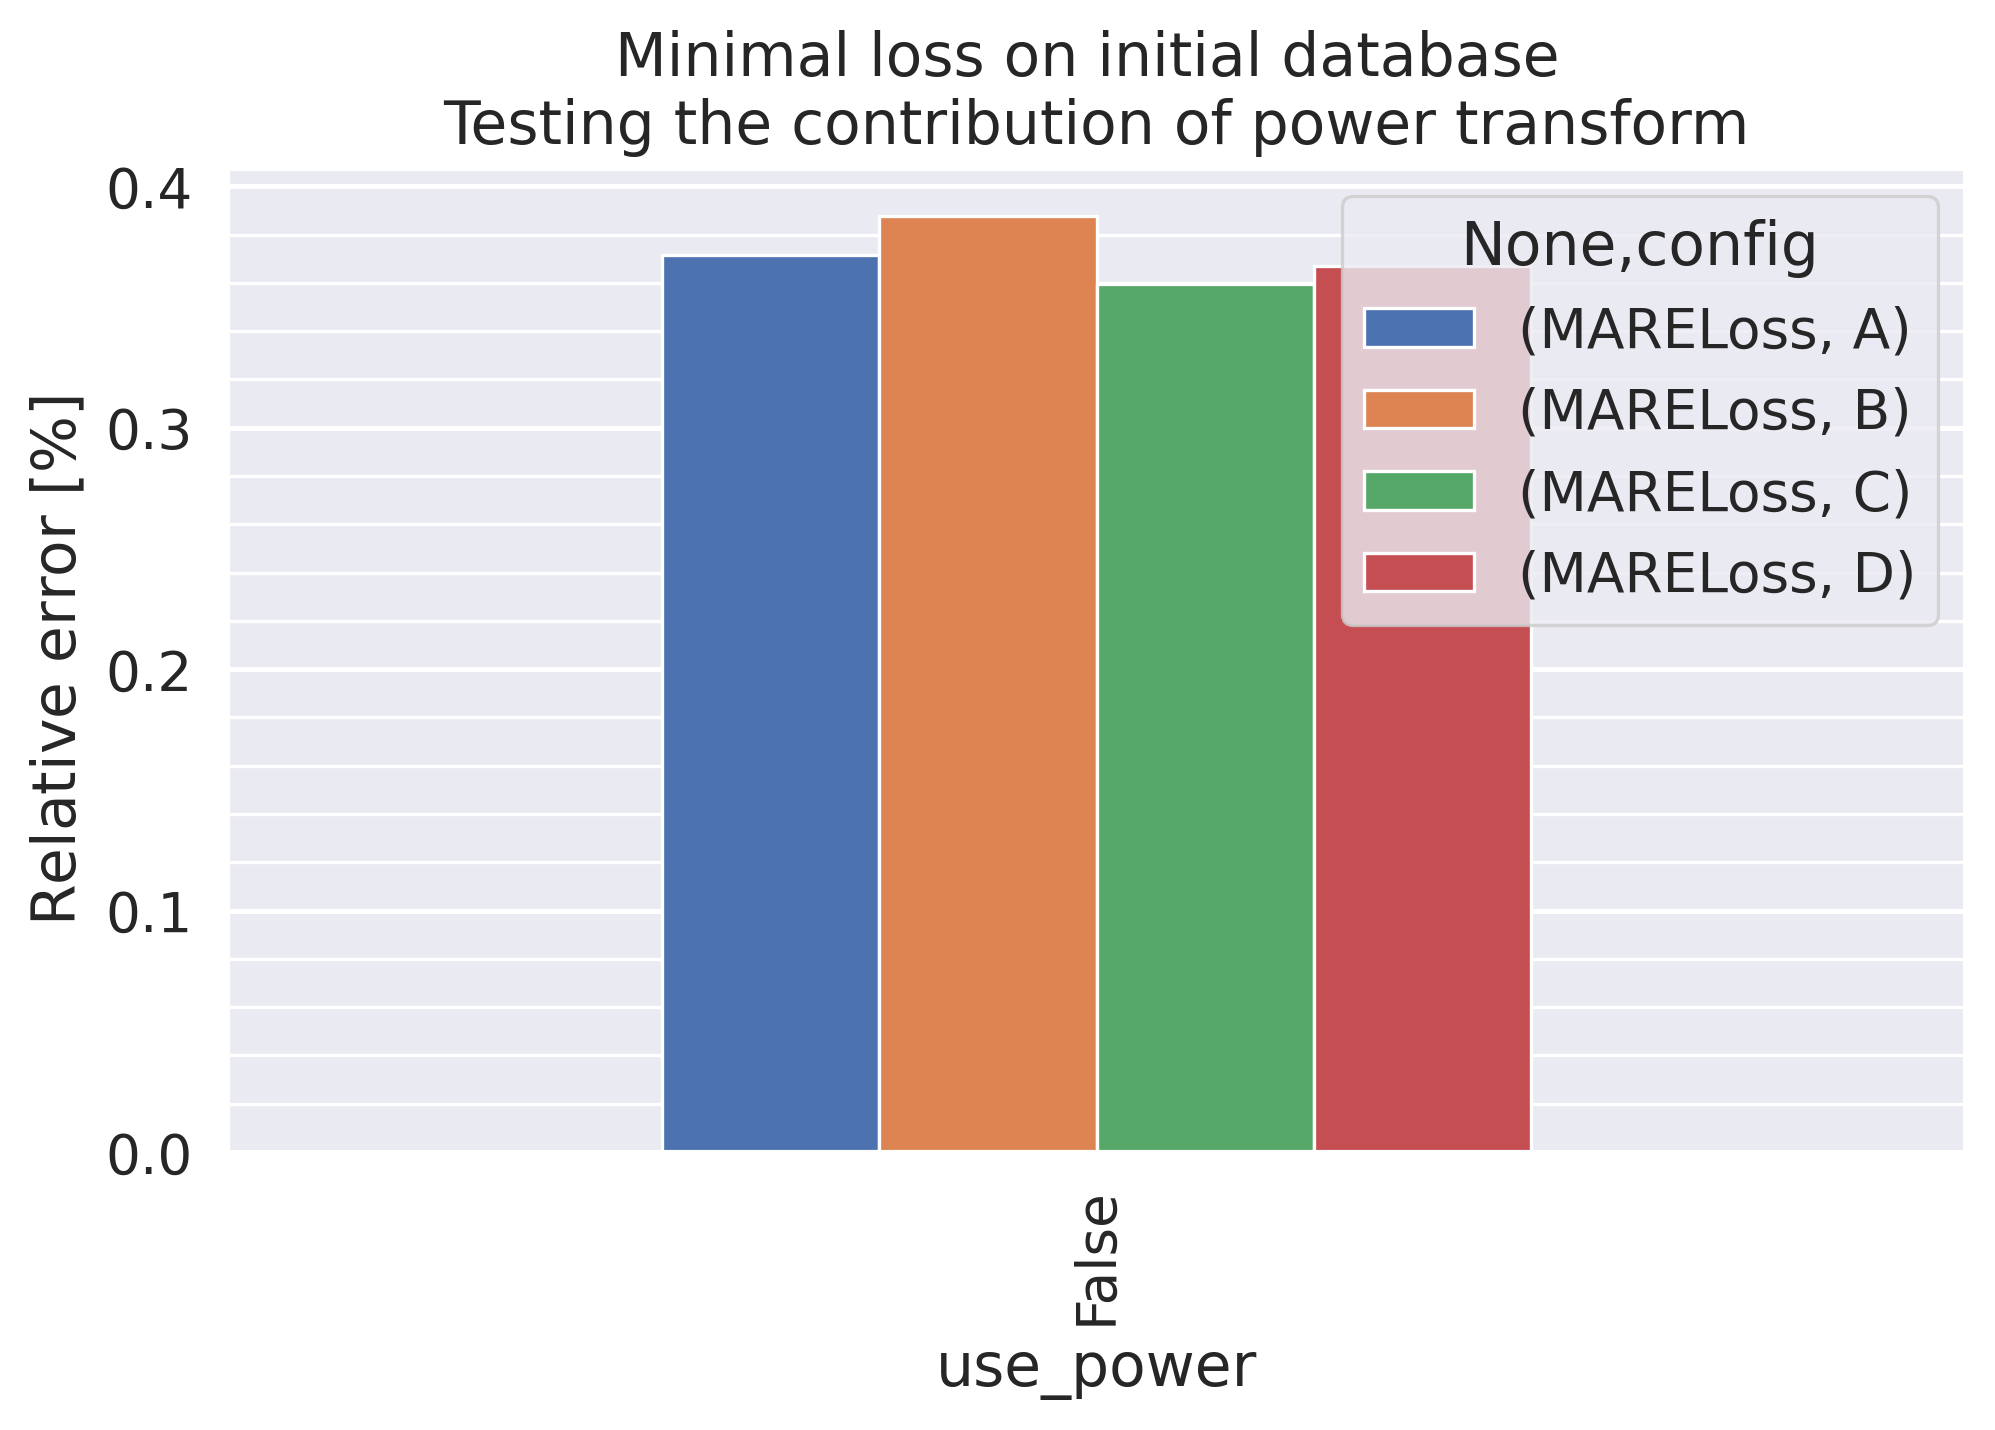

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.note=='extended_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the contribution of power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-21-94cf29c27284>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


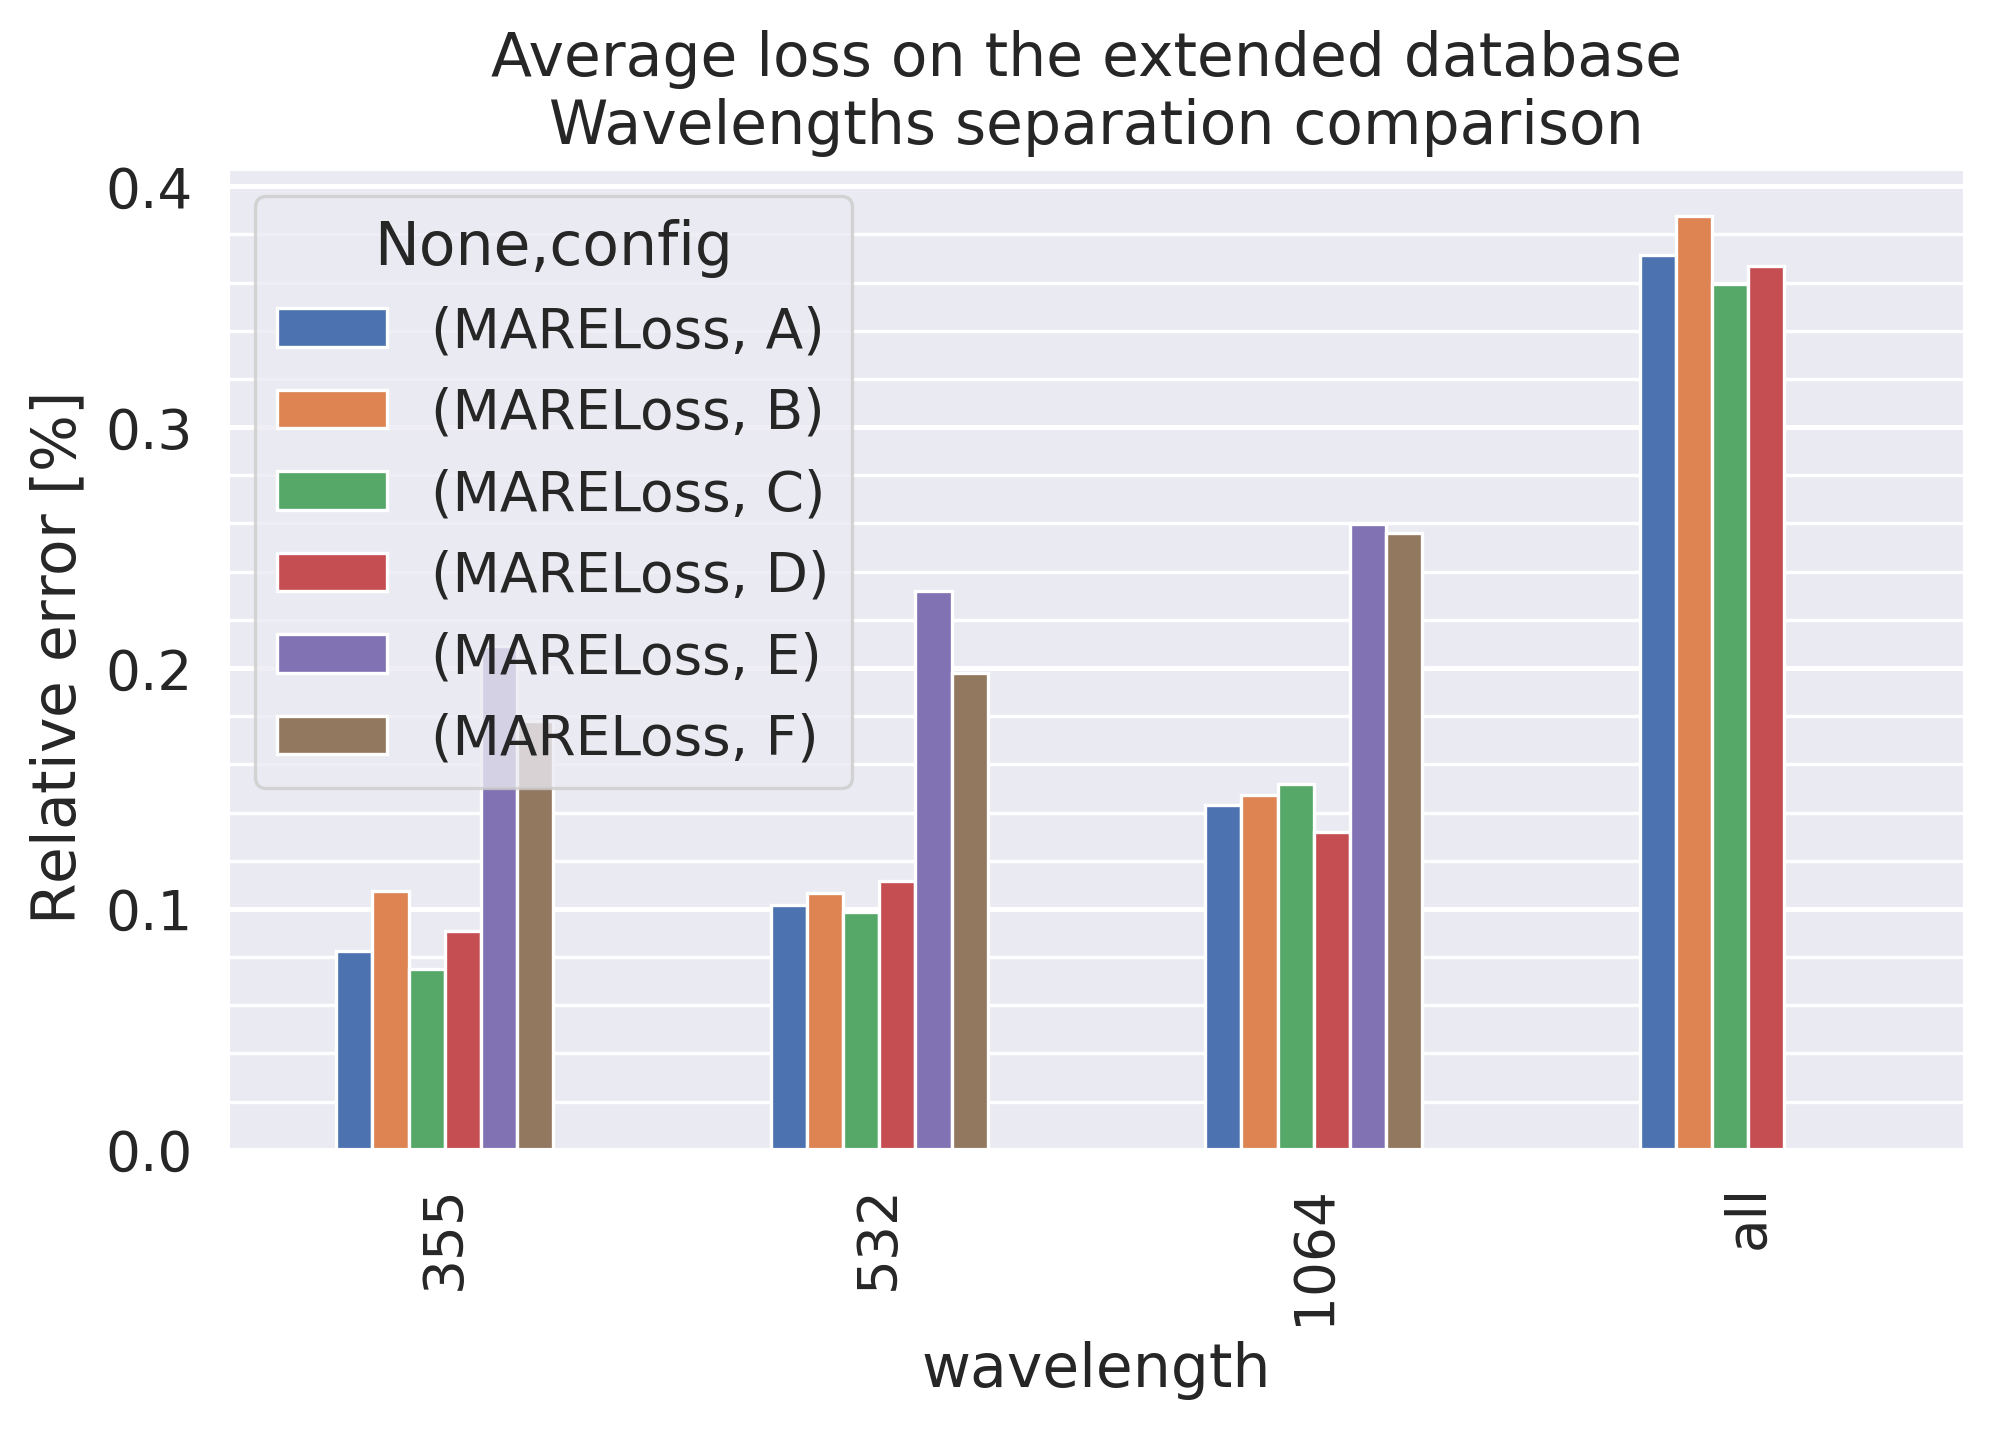

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Average loss on the extended database \n Wavelengths separation comparison ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-22-527ef60f31bd>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='extended_db'],


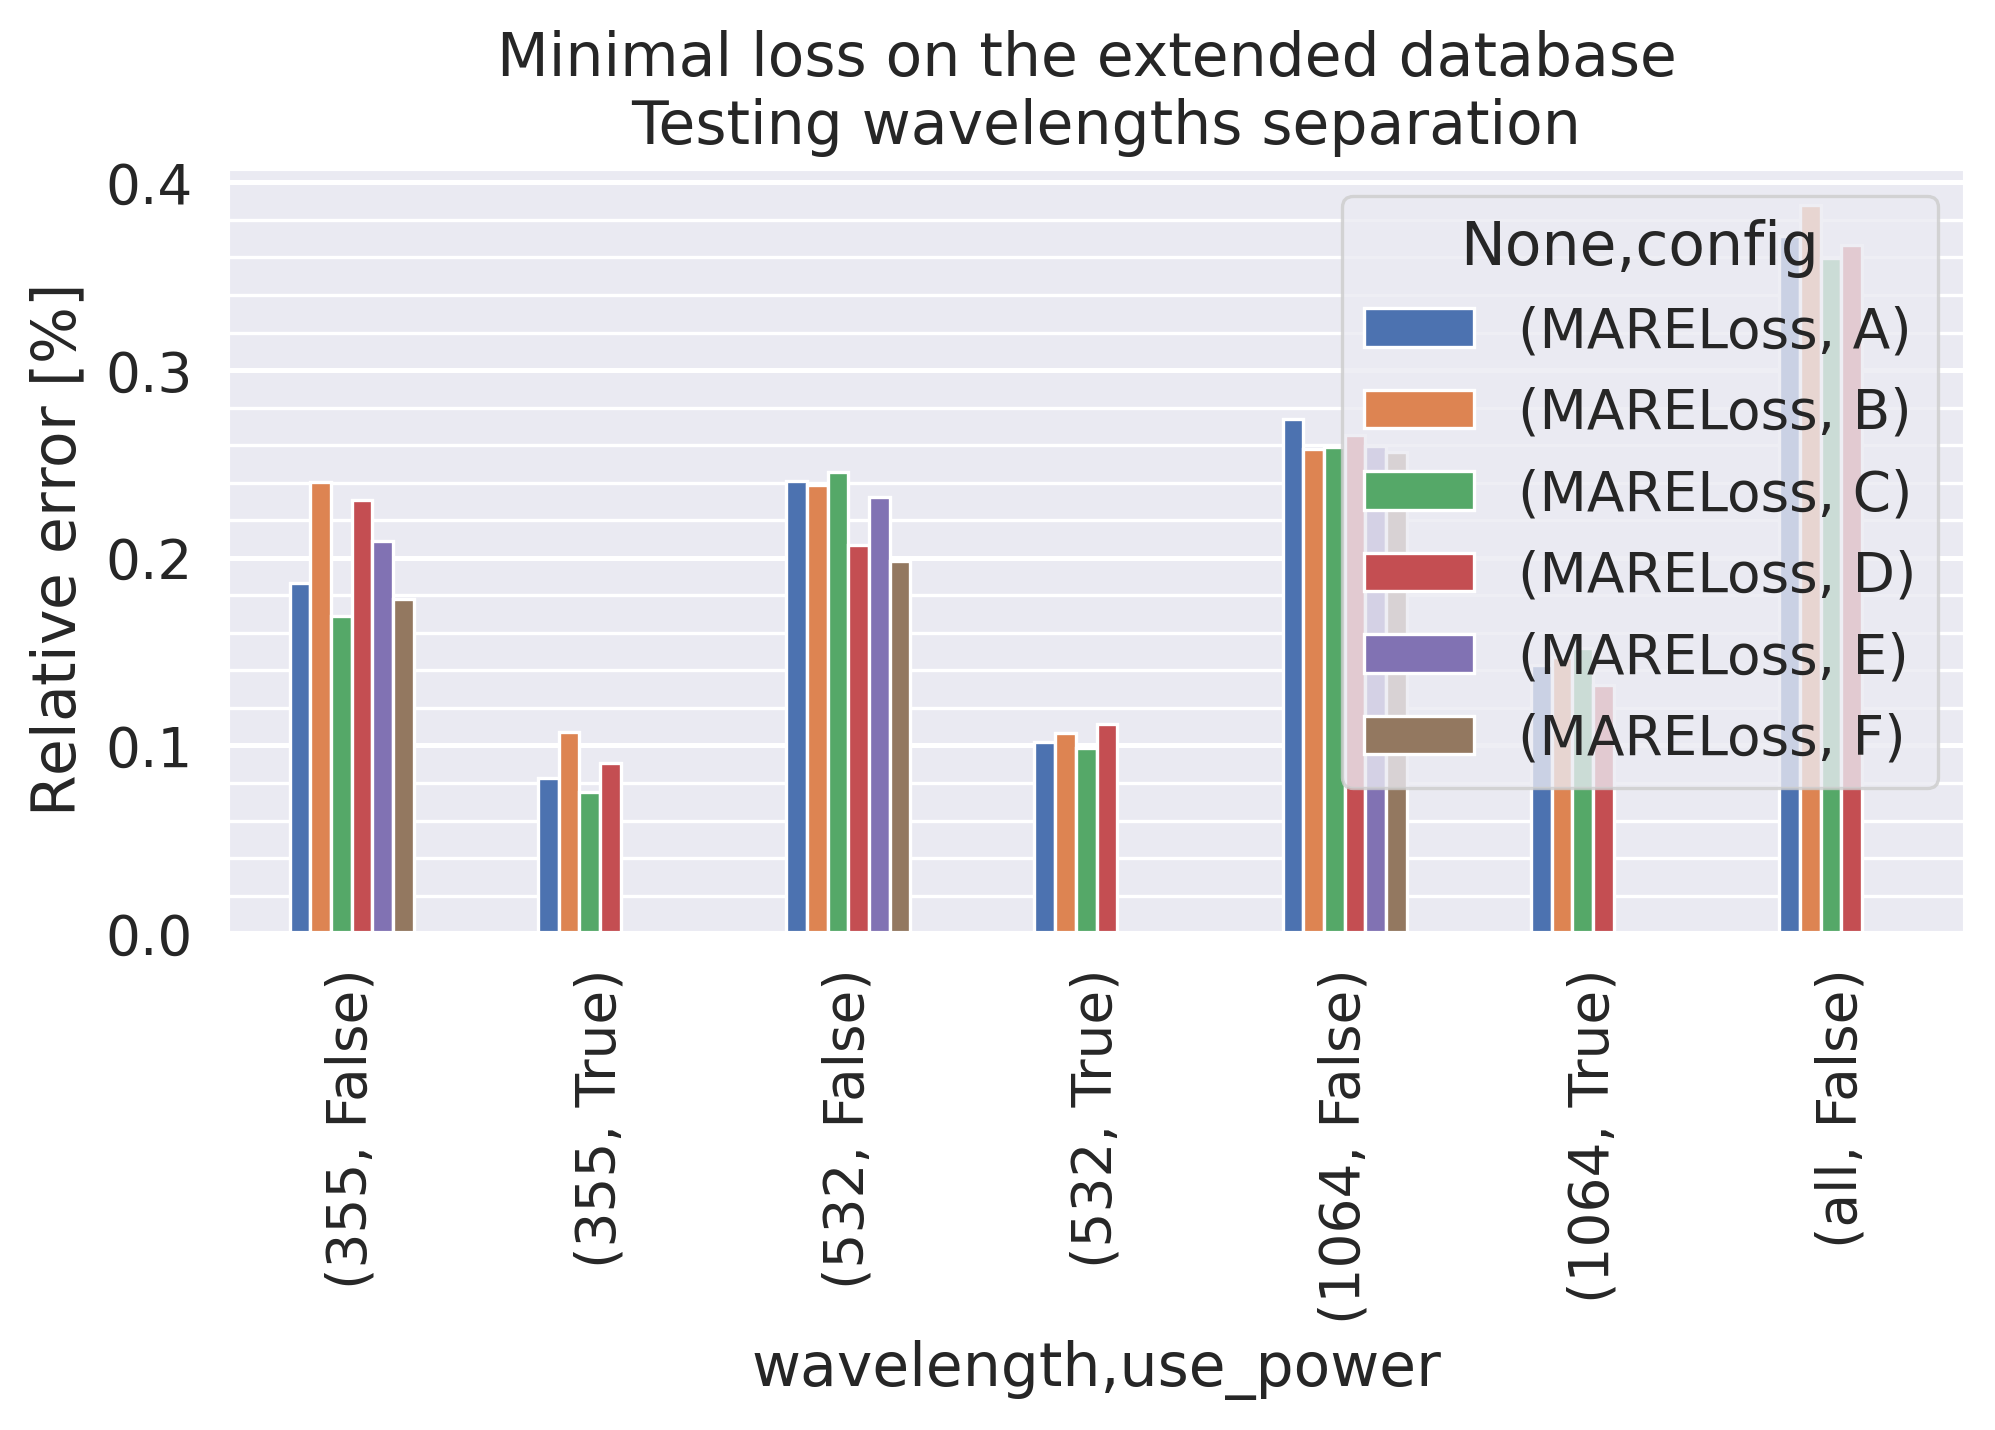

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on the extended database \n Testing wavelengths separation')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-23-1838f254c99e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


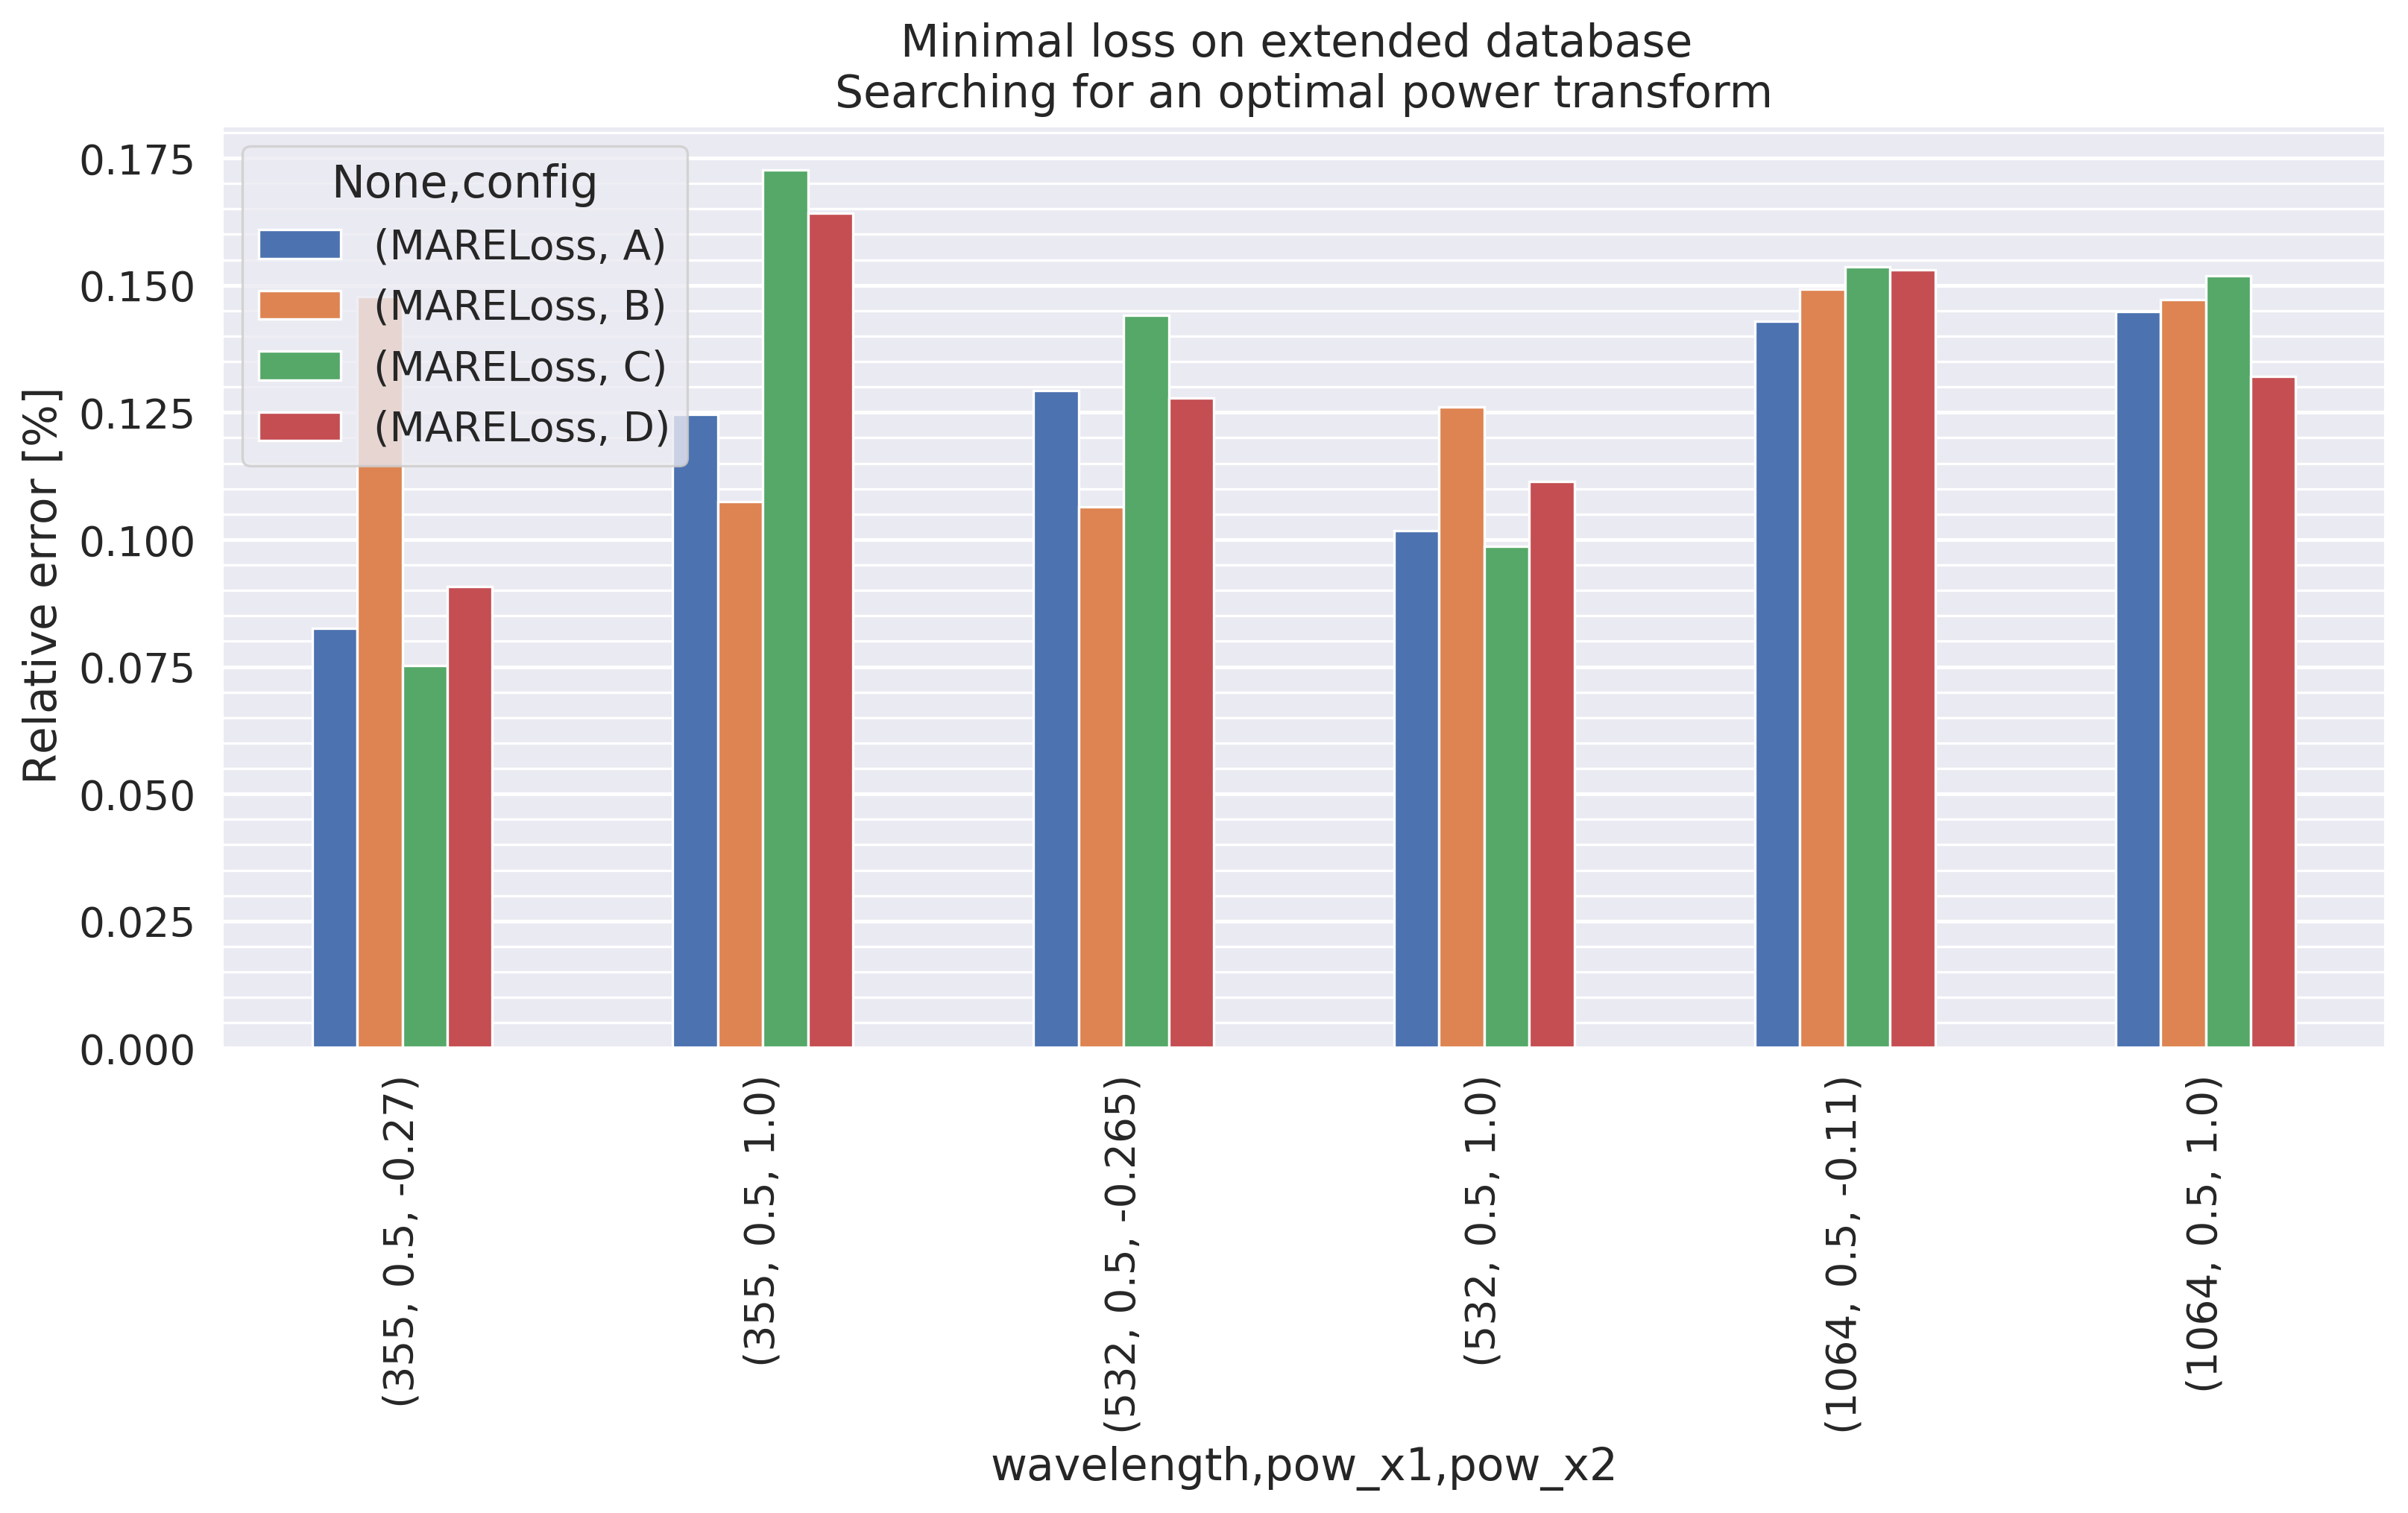

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on extended database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [24]:
all_wavs_configABCD[all_wavs_configABCD.wavelength==532][all_wavs_configABCD.use_bg==False].note

<ipython-input-24-88fa8e8ae773>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_wavs_configABCD[all_wavs_configABCD.wavelength==532][all_wavs_configABCD.use_bg==False].note


89              initial_db
90              initial_db
91              initial_db
92              initial_db
94              initial_db
              ...         
847    extended_db_overlap
900     initial_db_overlap
917     initial_db_overlap
918     initial_db_overlap
921     initial_db_overlap
Name: note, Length: 72, dtype: object

<ipython-input-25-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],


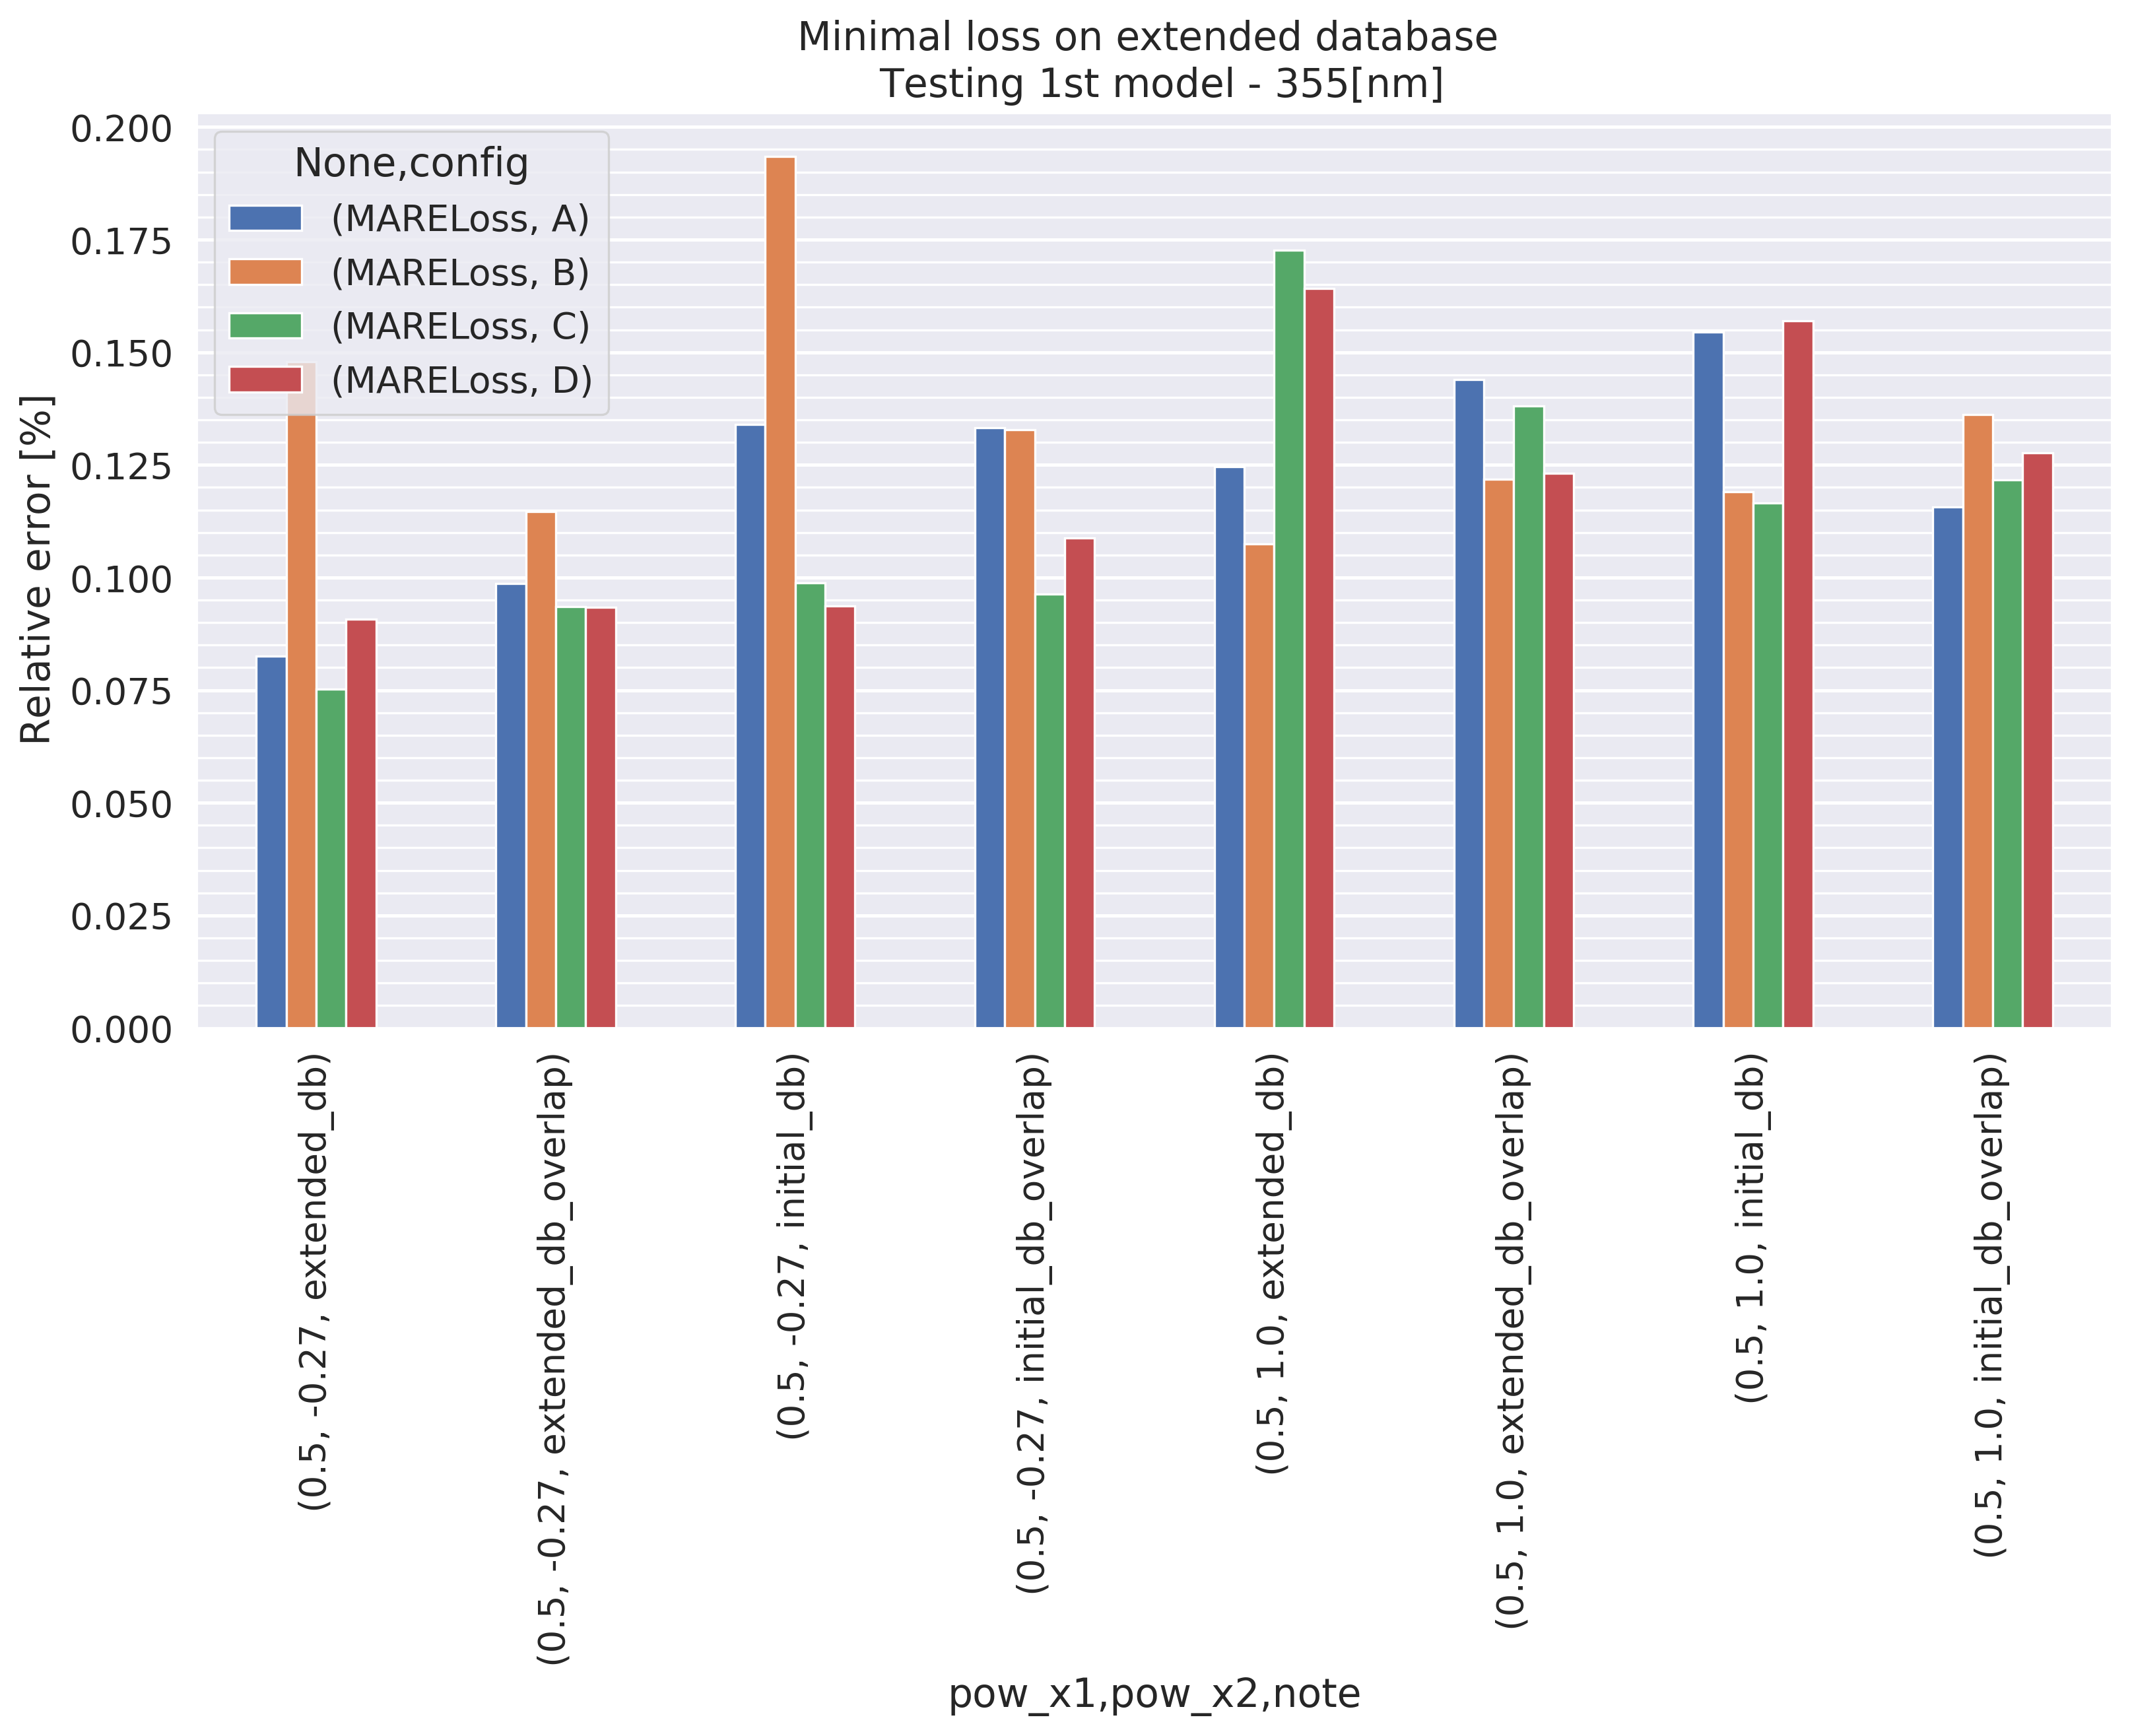

<ipython-input-25-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],


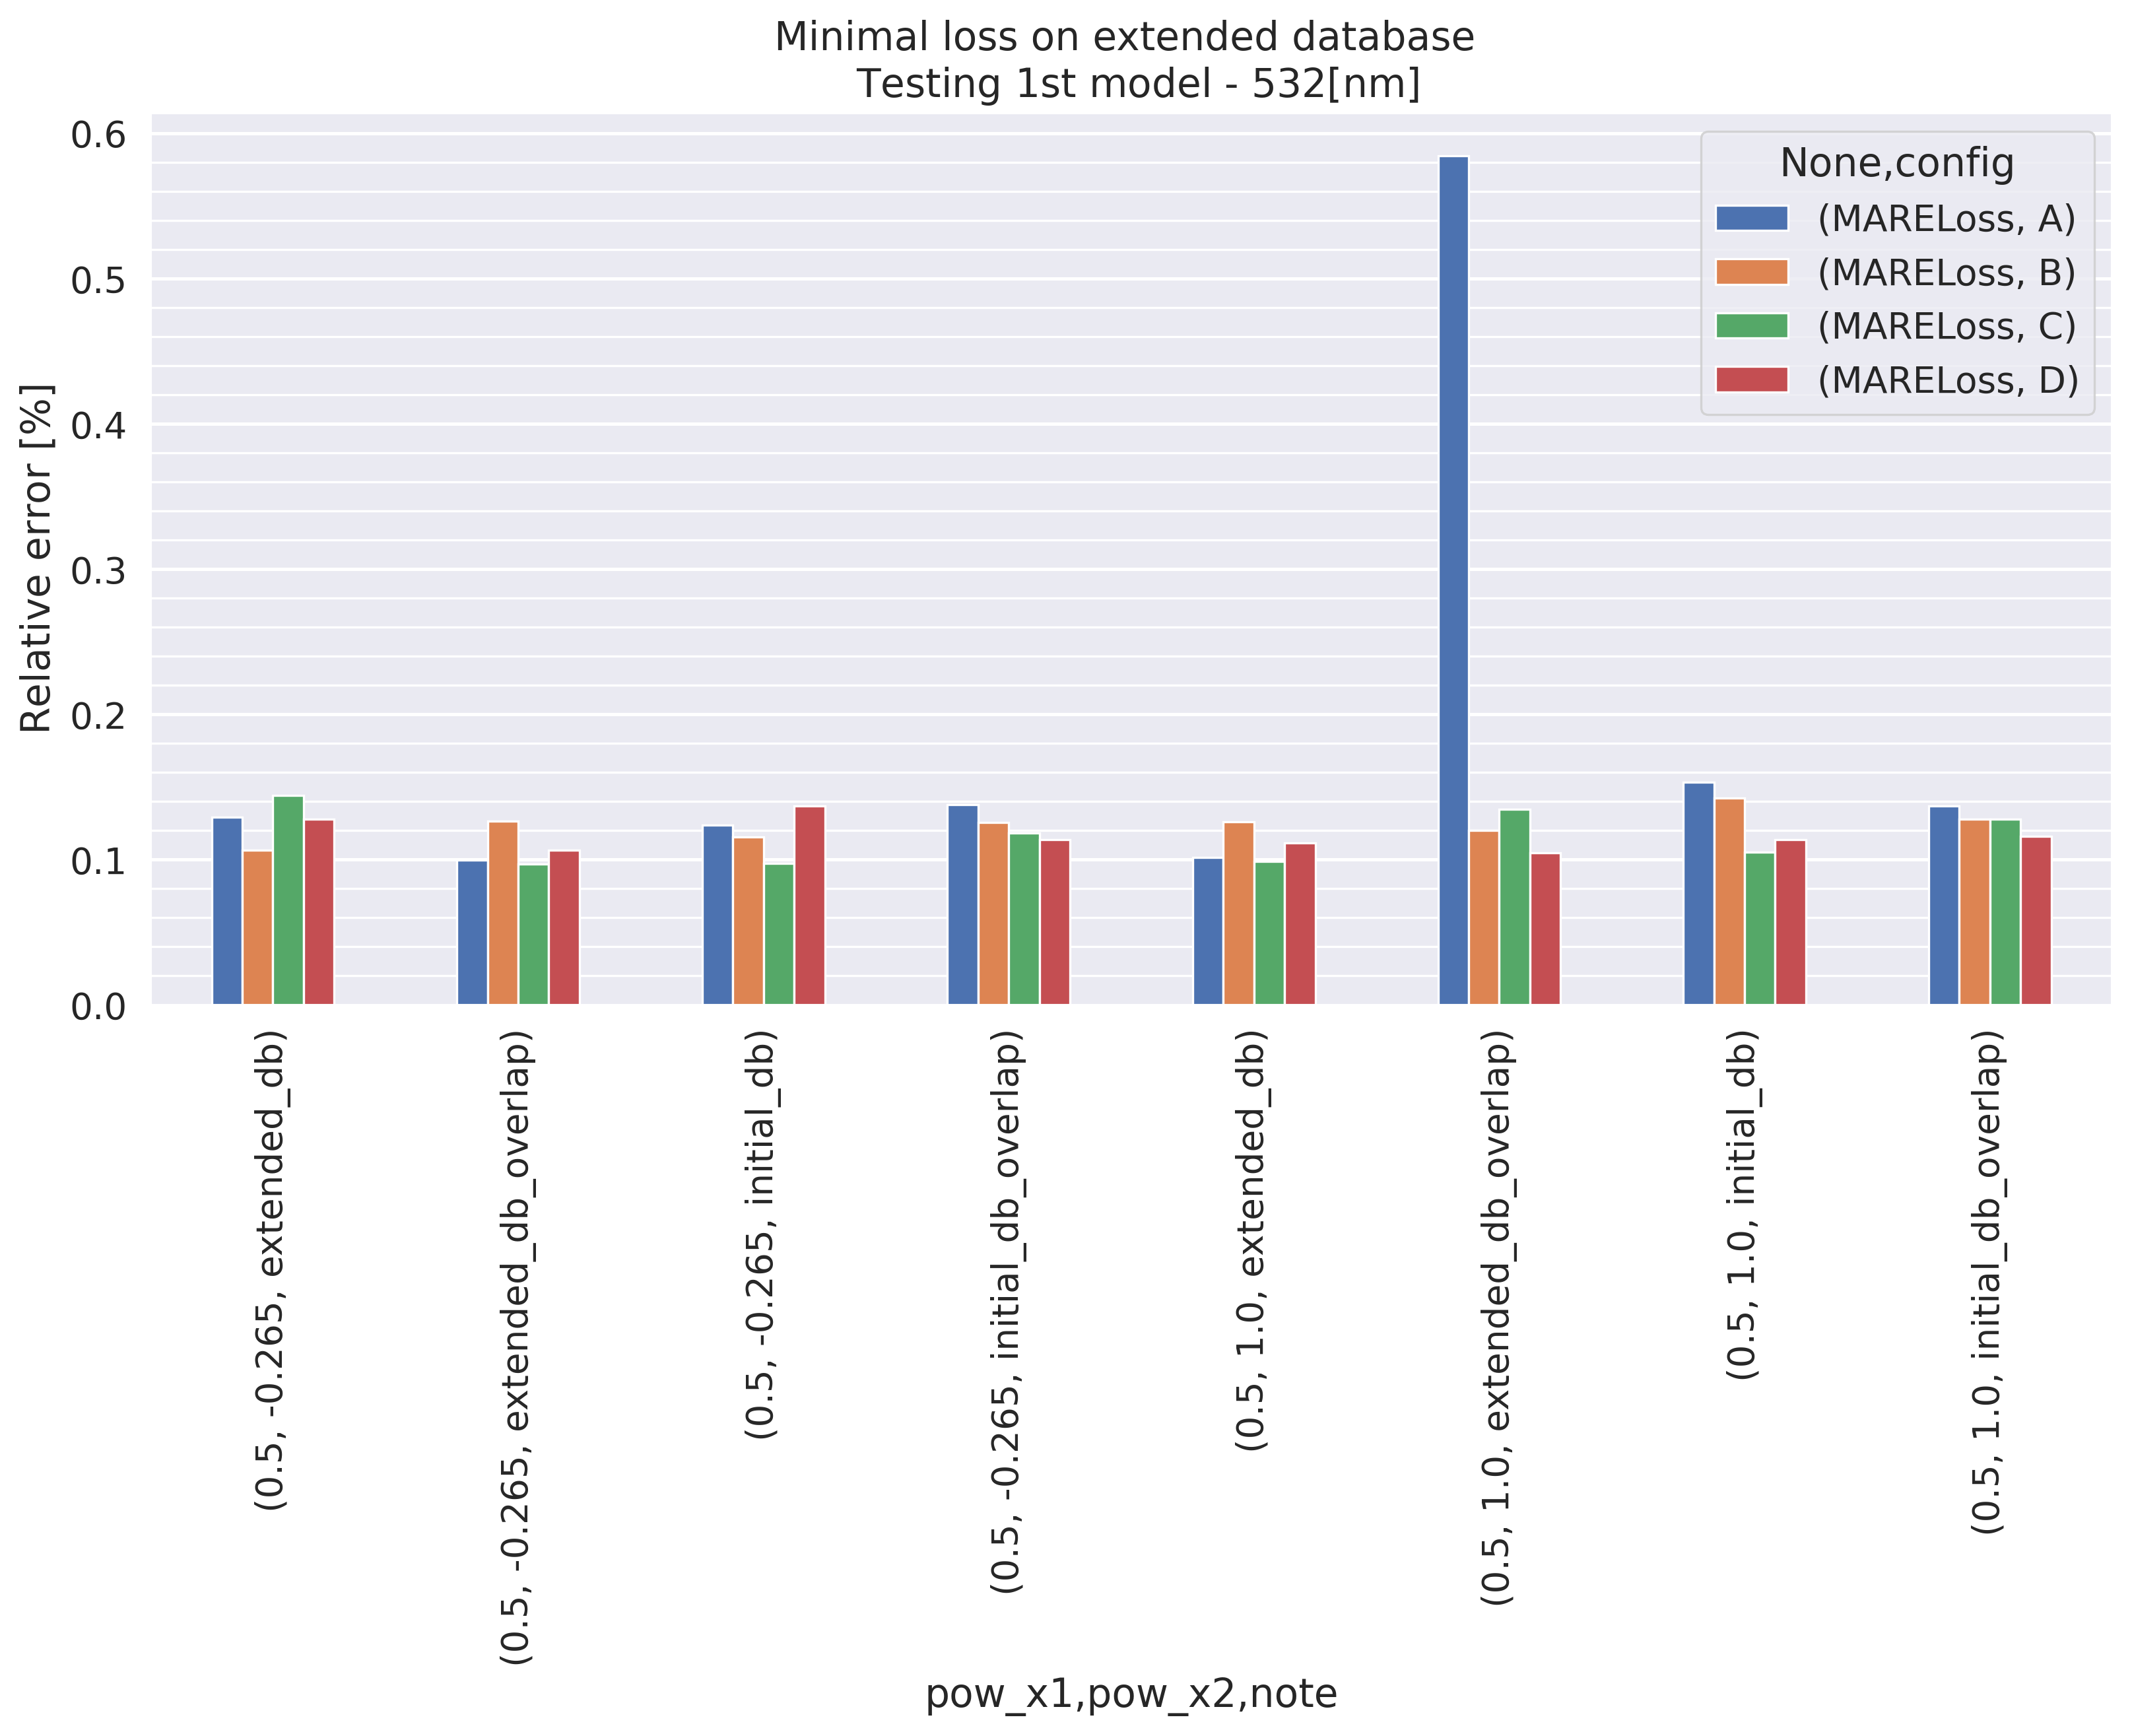

<ipython-input-25-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],


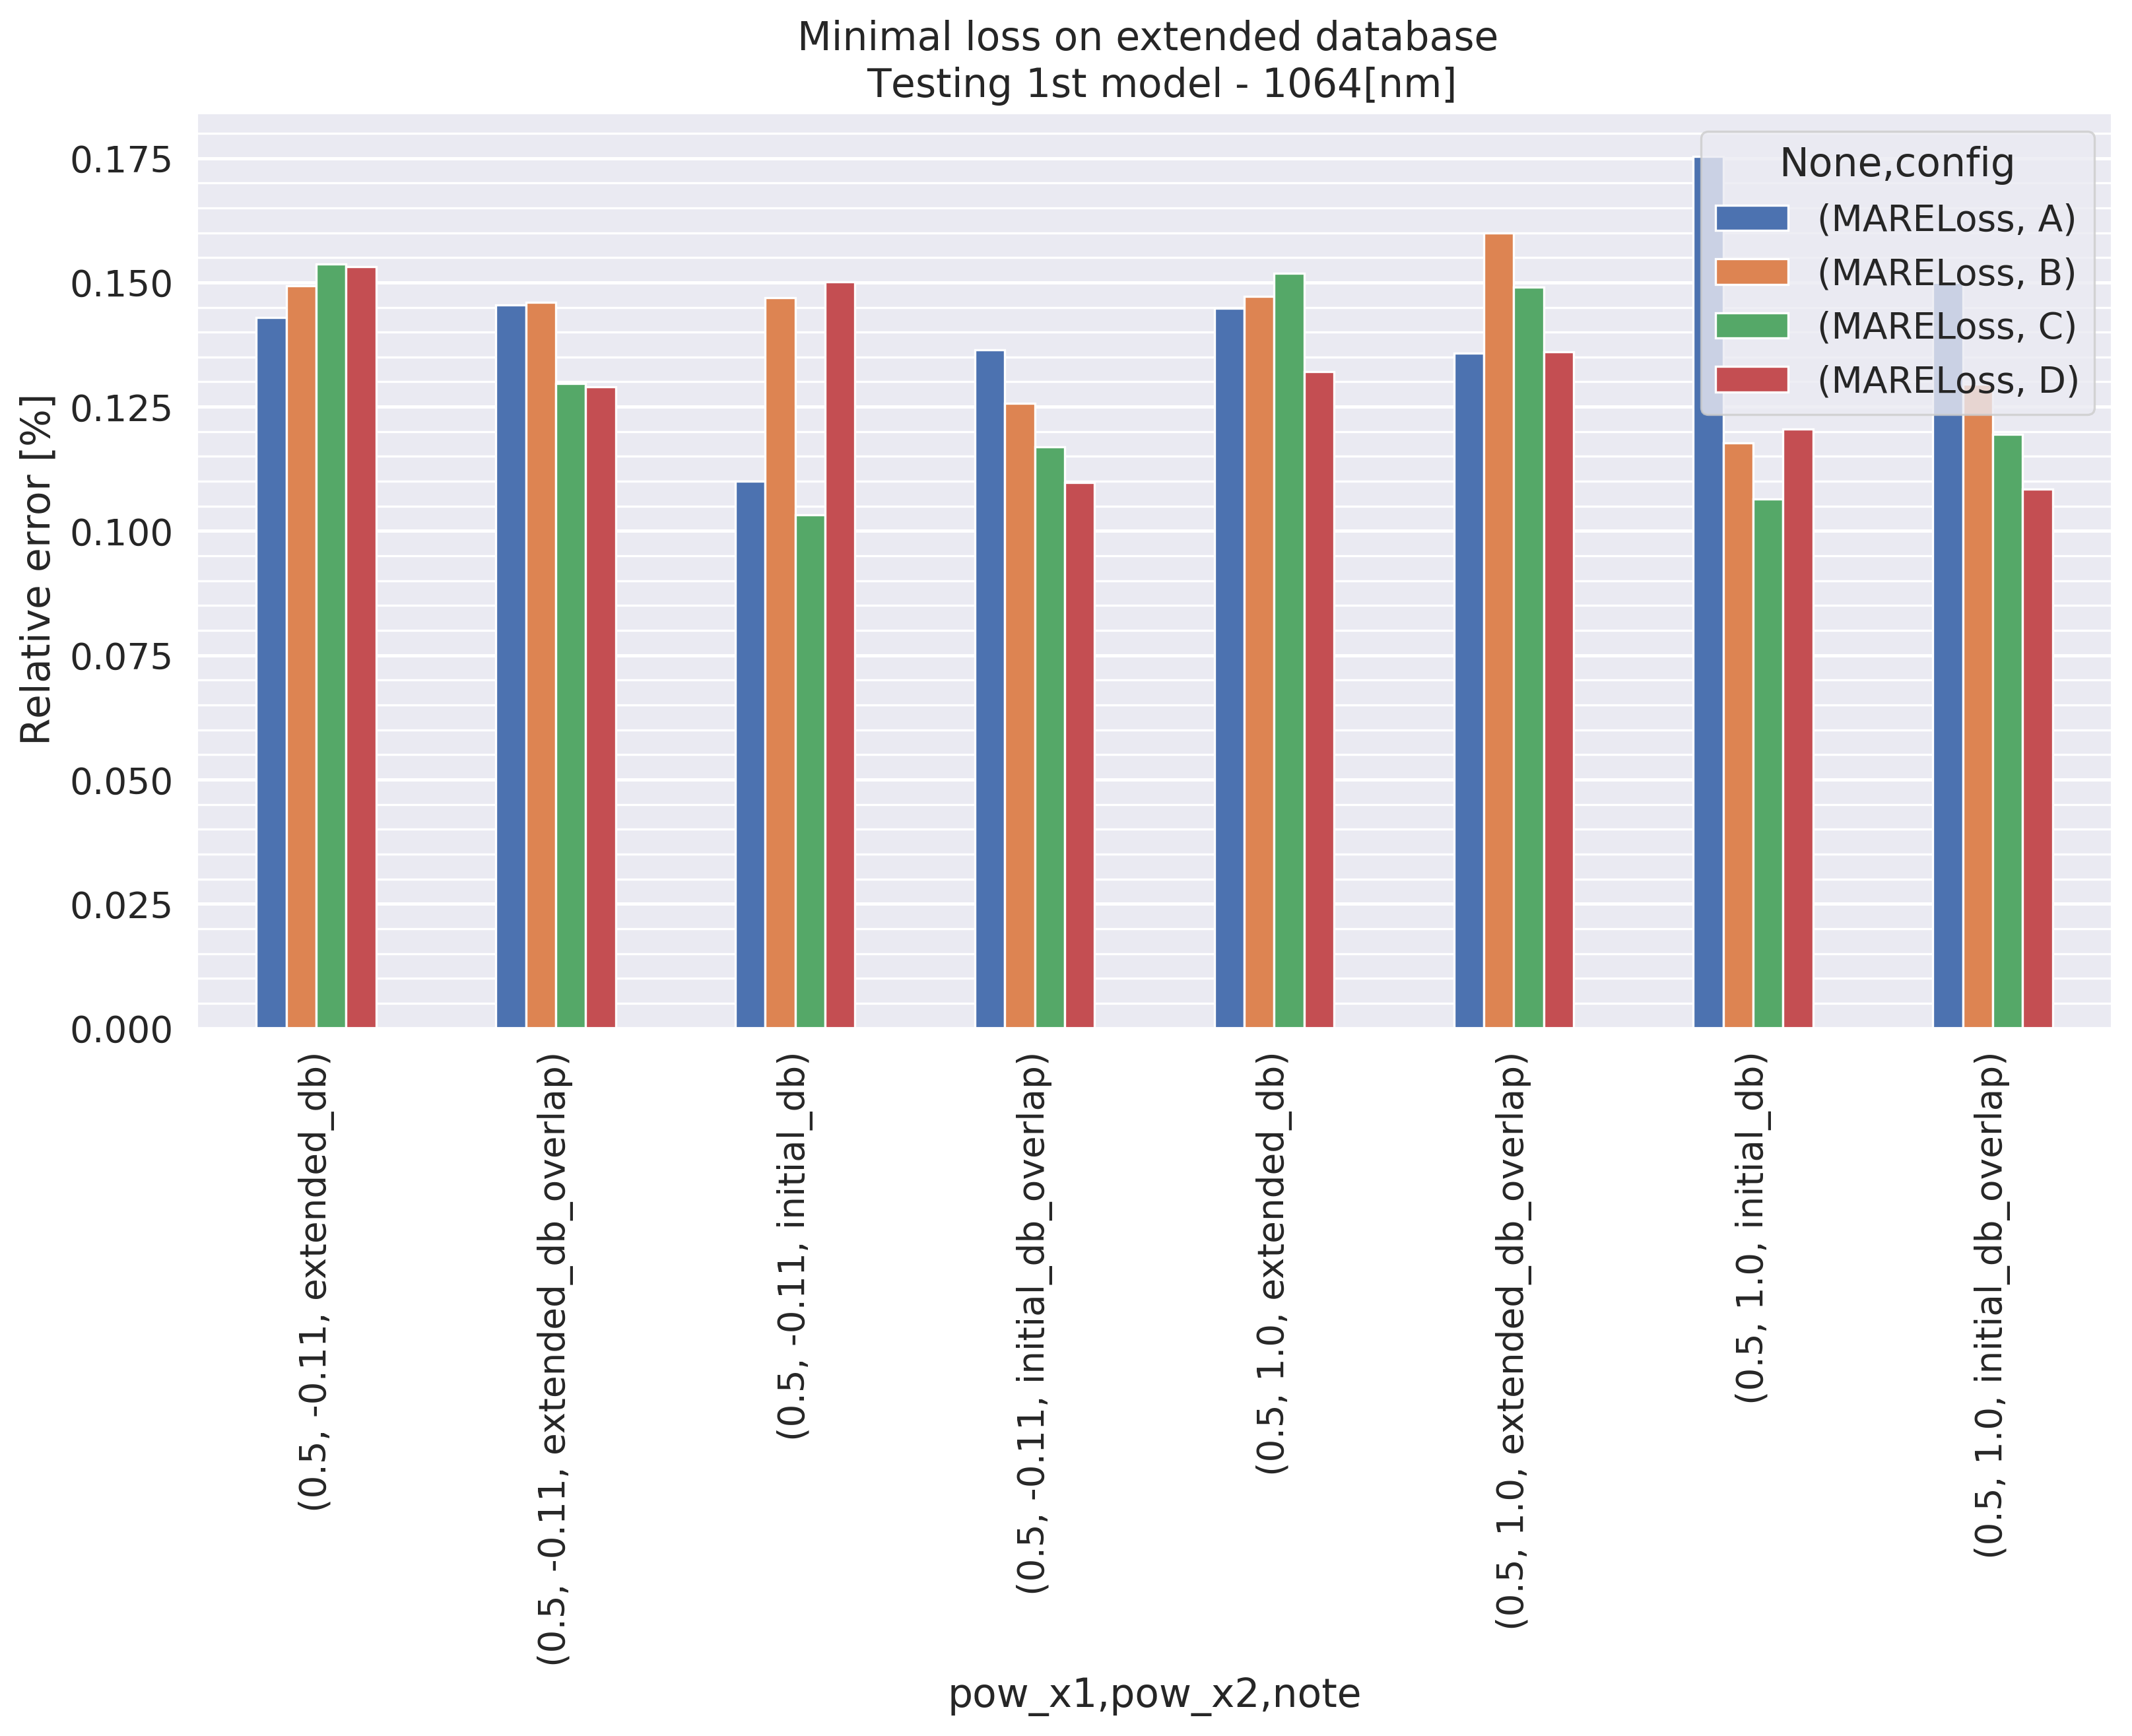

In [25]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 9))
    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['pow_x1','pow_x2','note'],
                   aggfunc=np.mean).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n Testing 1st model - '+ fr'${wavelength}[\rm nm]$' )
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    plt.tight_layout()
    plt.show()

<ipython-input-26-1ade521e2fb3>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']


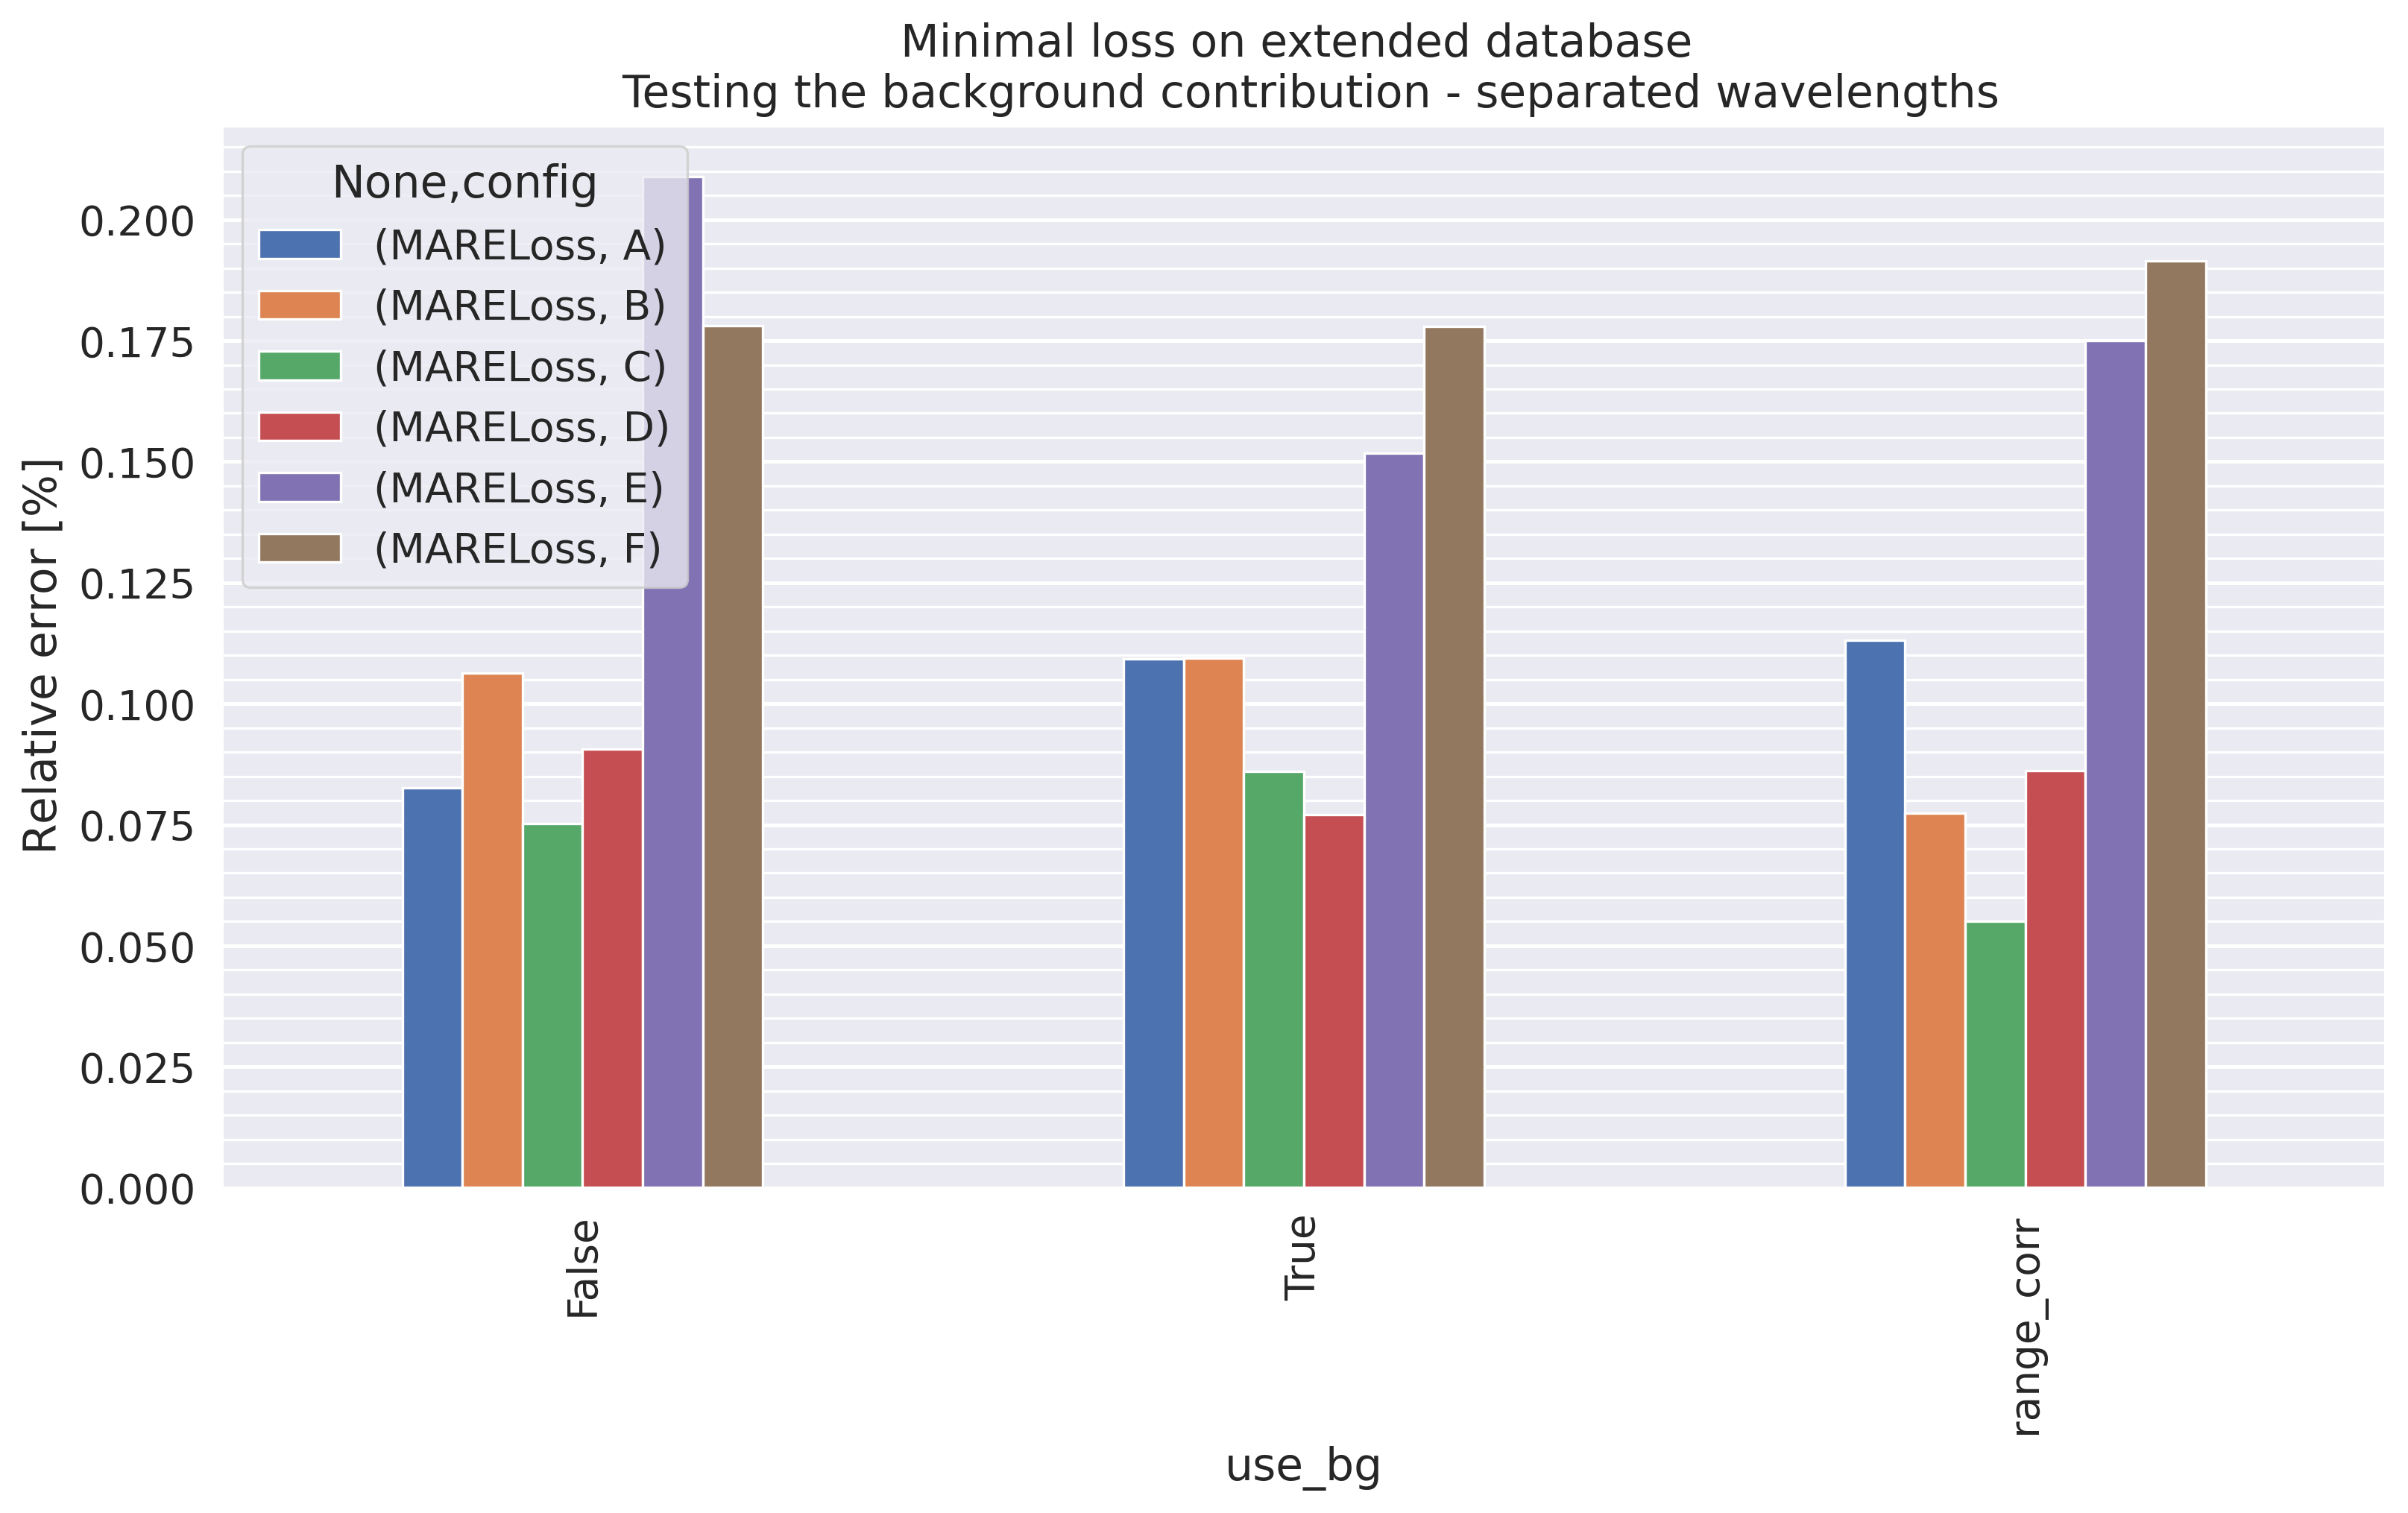

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on extended database \n Testing the background contribution - separated wavelengths')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-27-b4baf008d0ee>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power][all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],


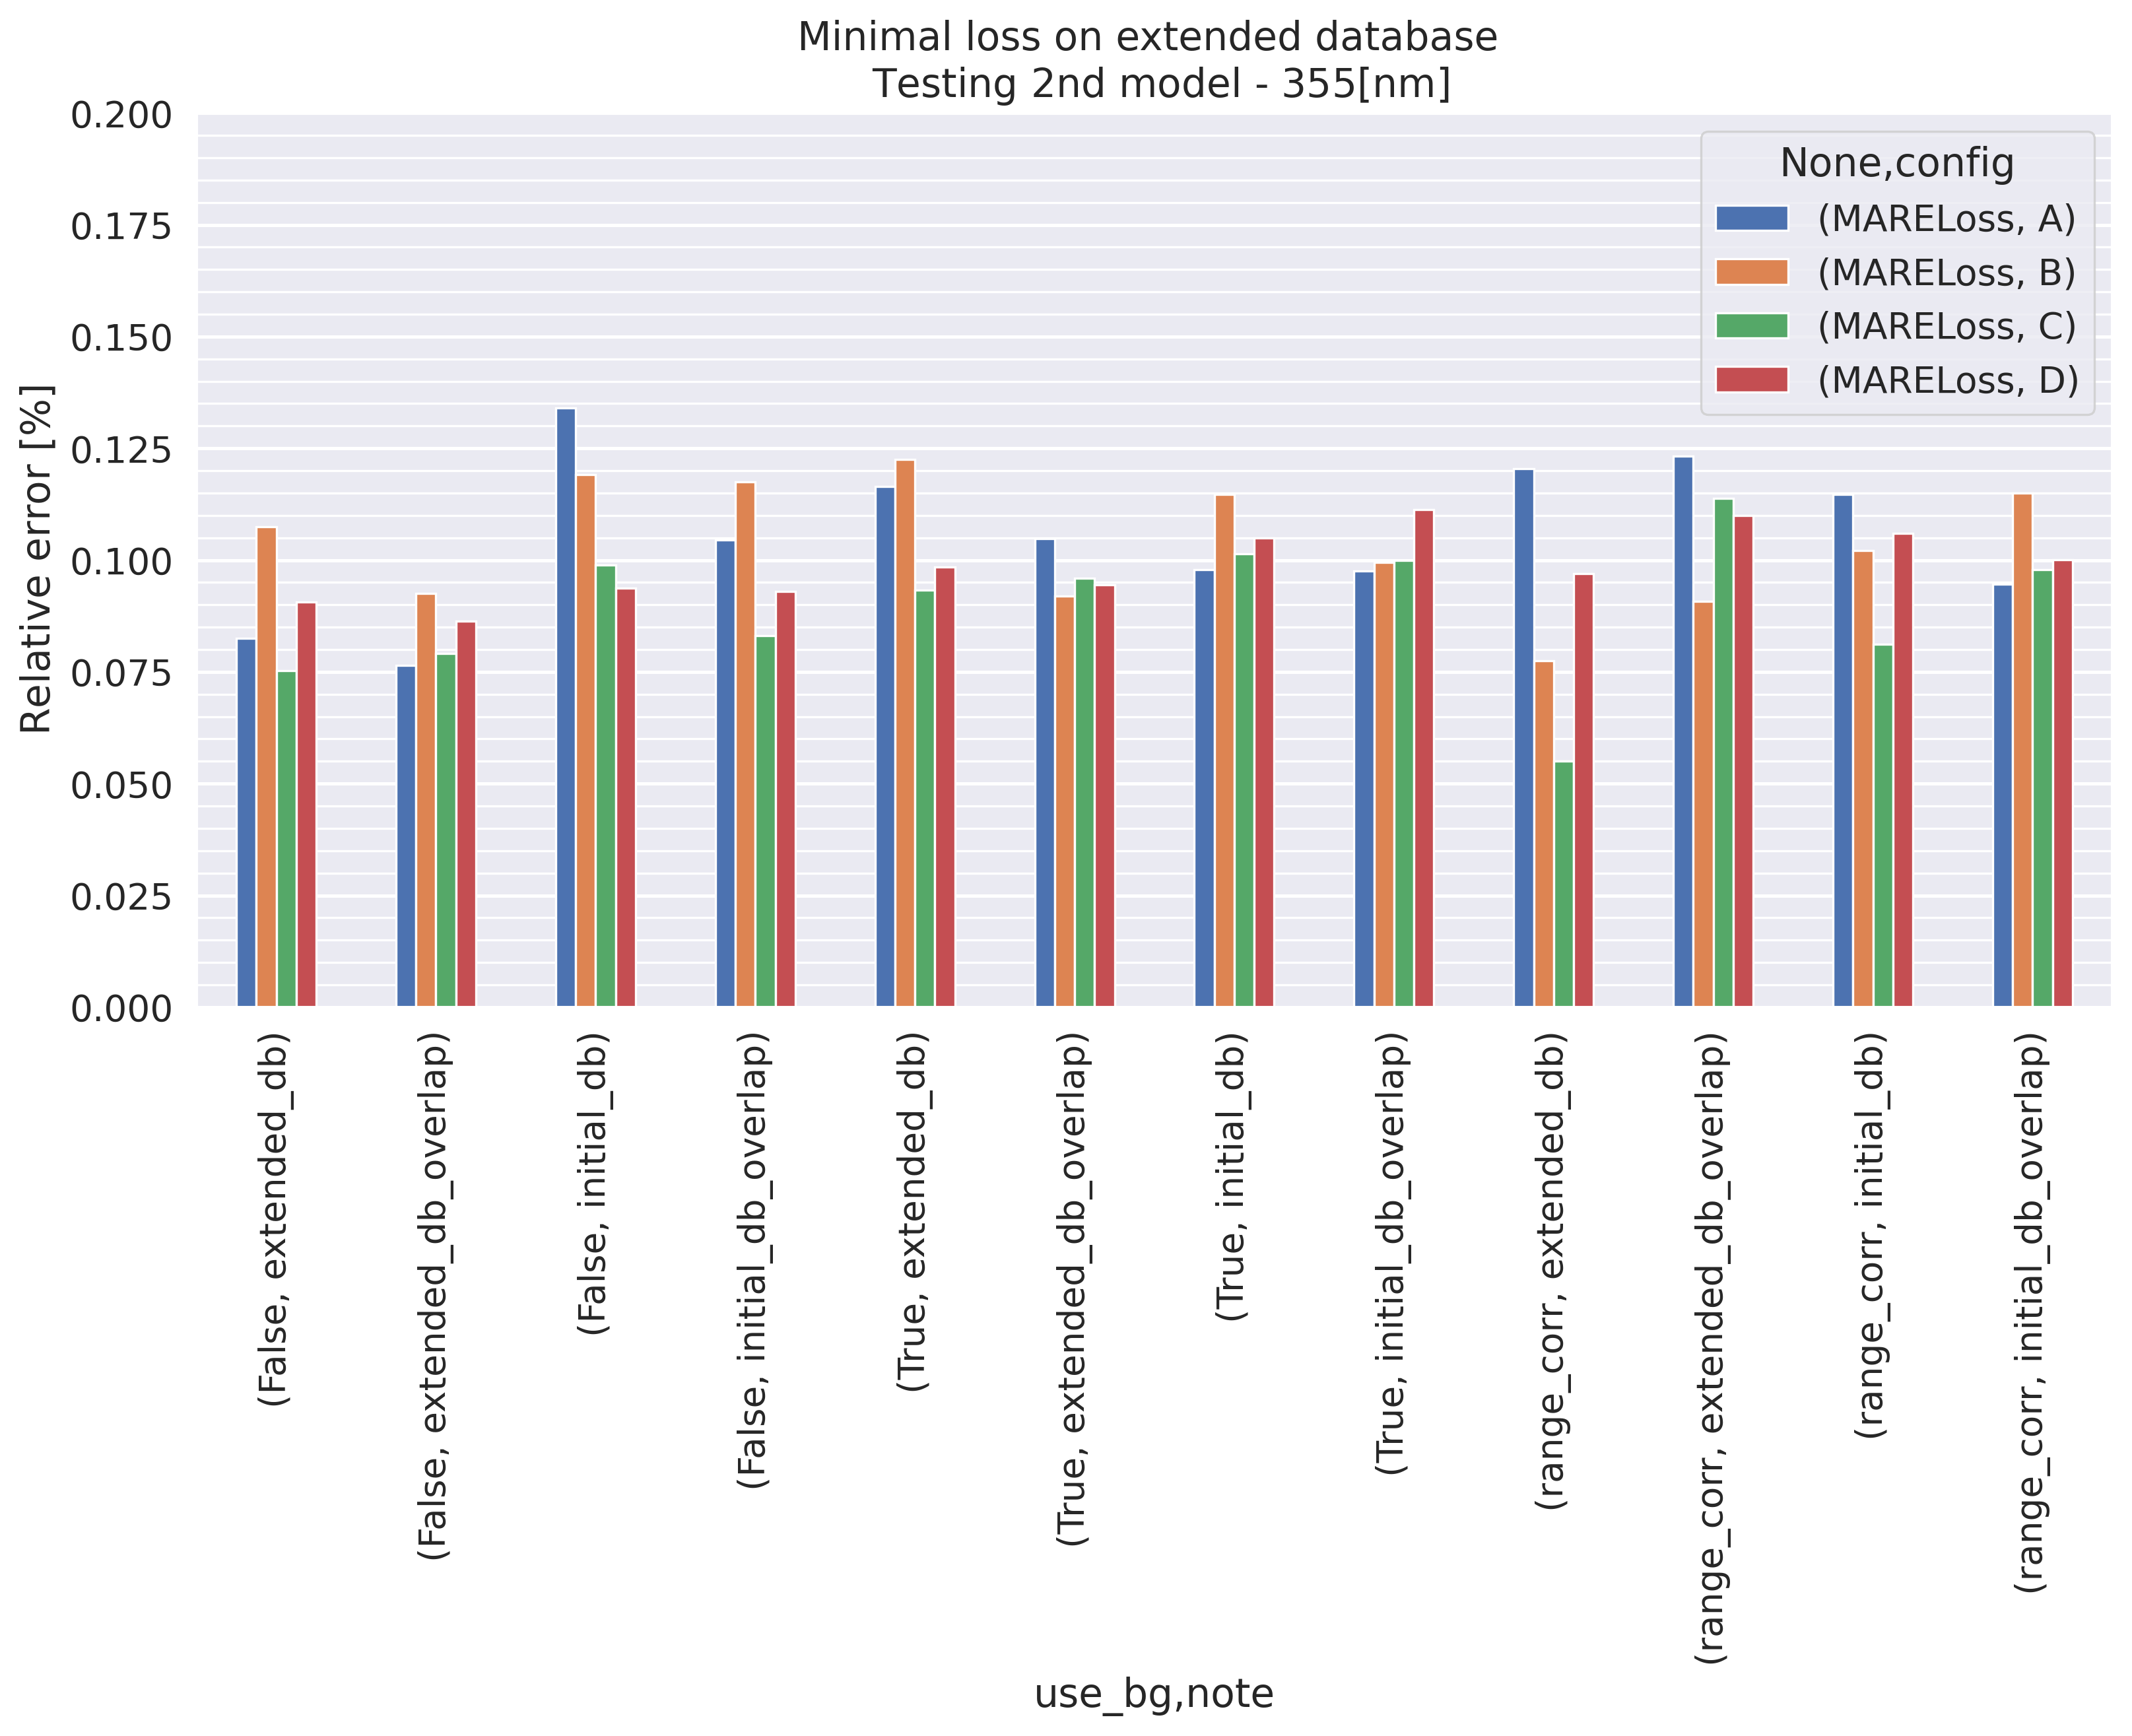

<ipython-input-27-b4baf008d0ee>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power][all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],


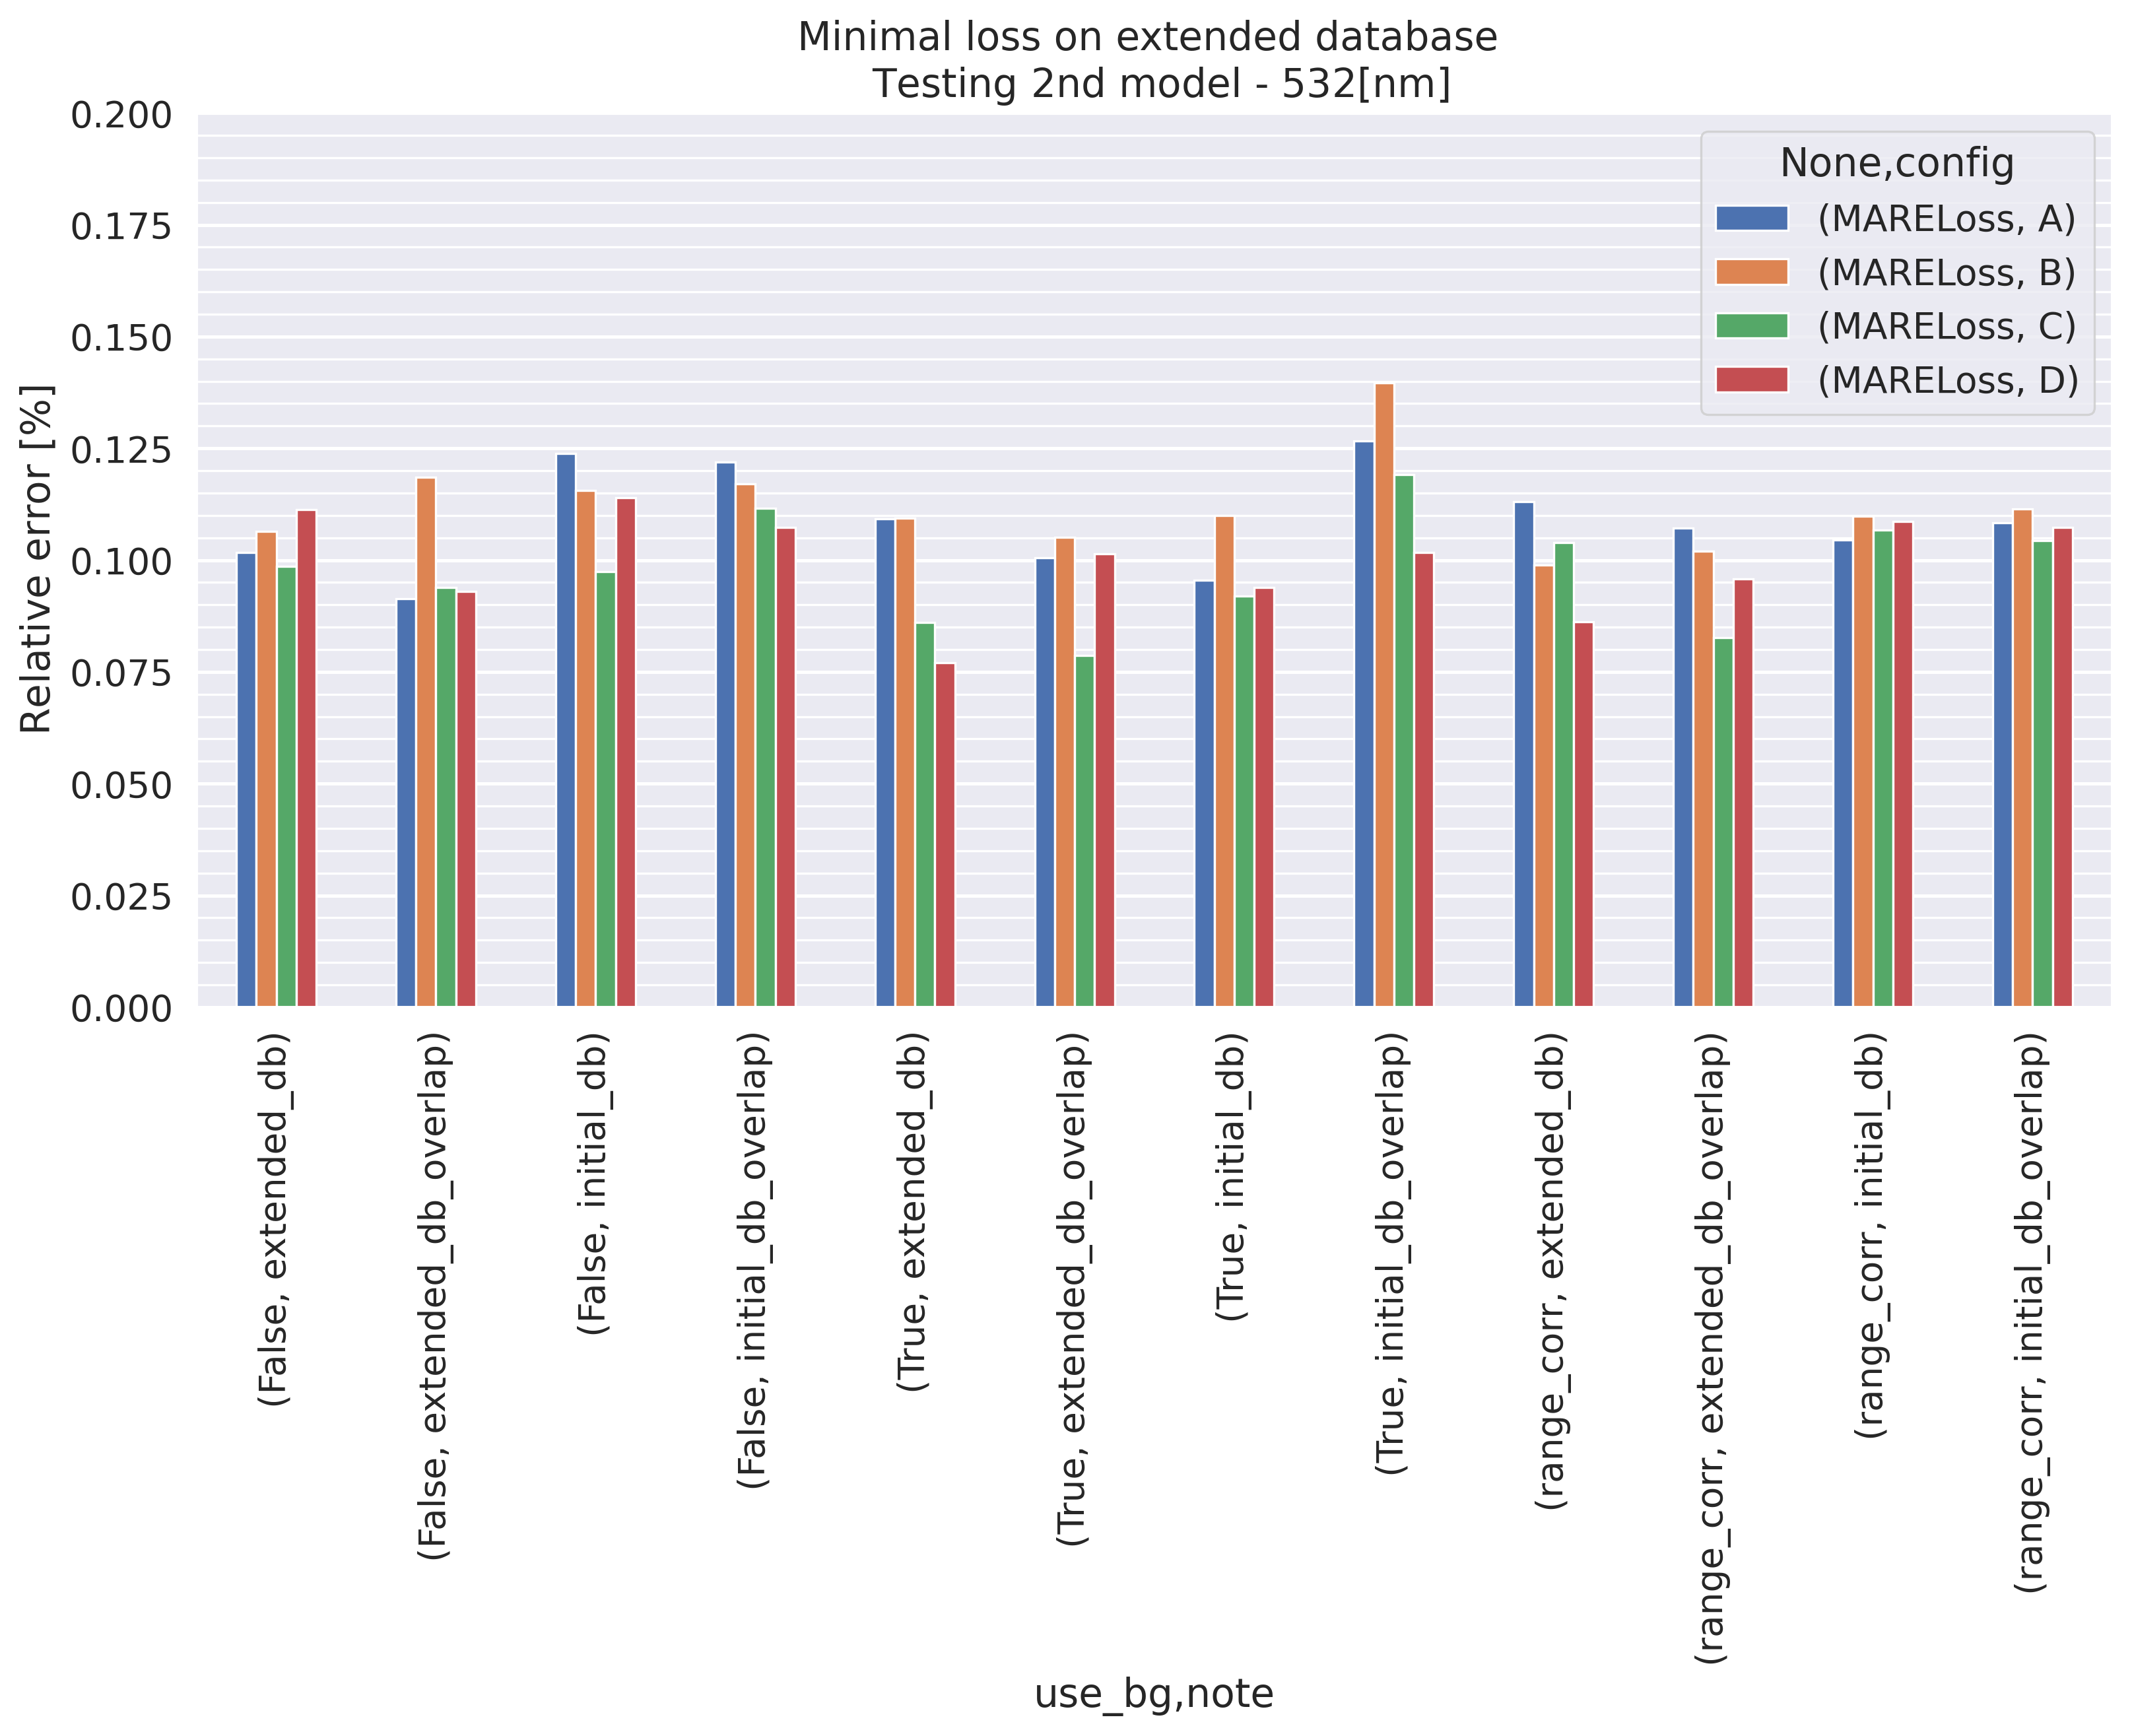

<ipython-input-27-b4baf008d0ee>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power][all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],


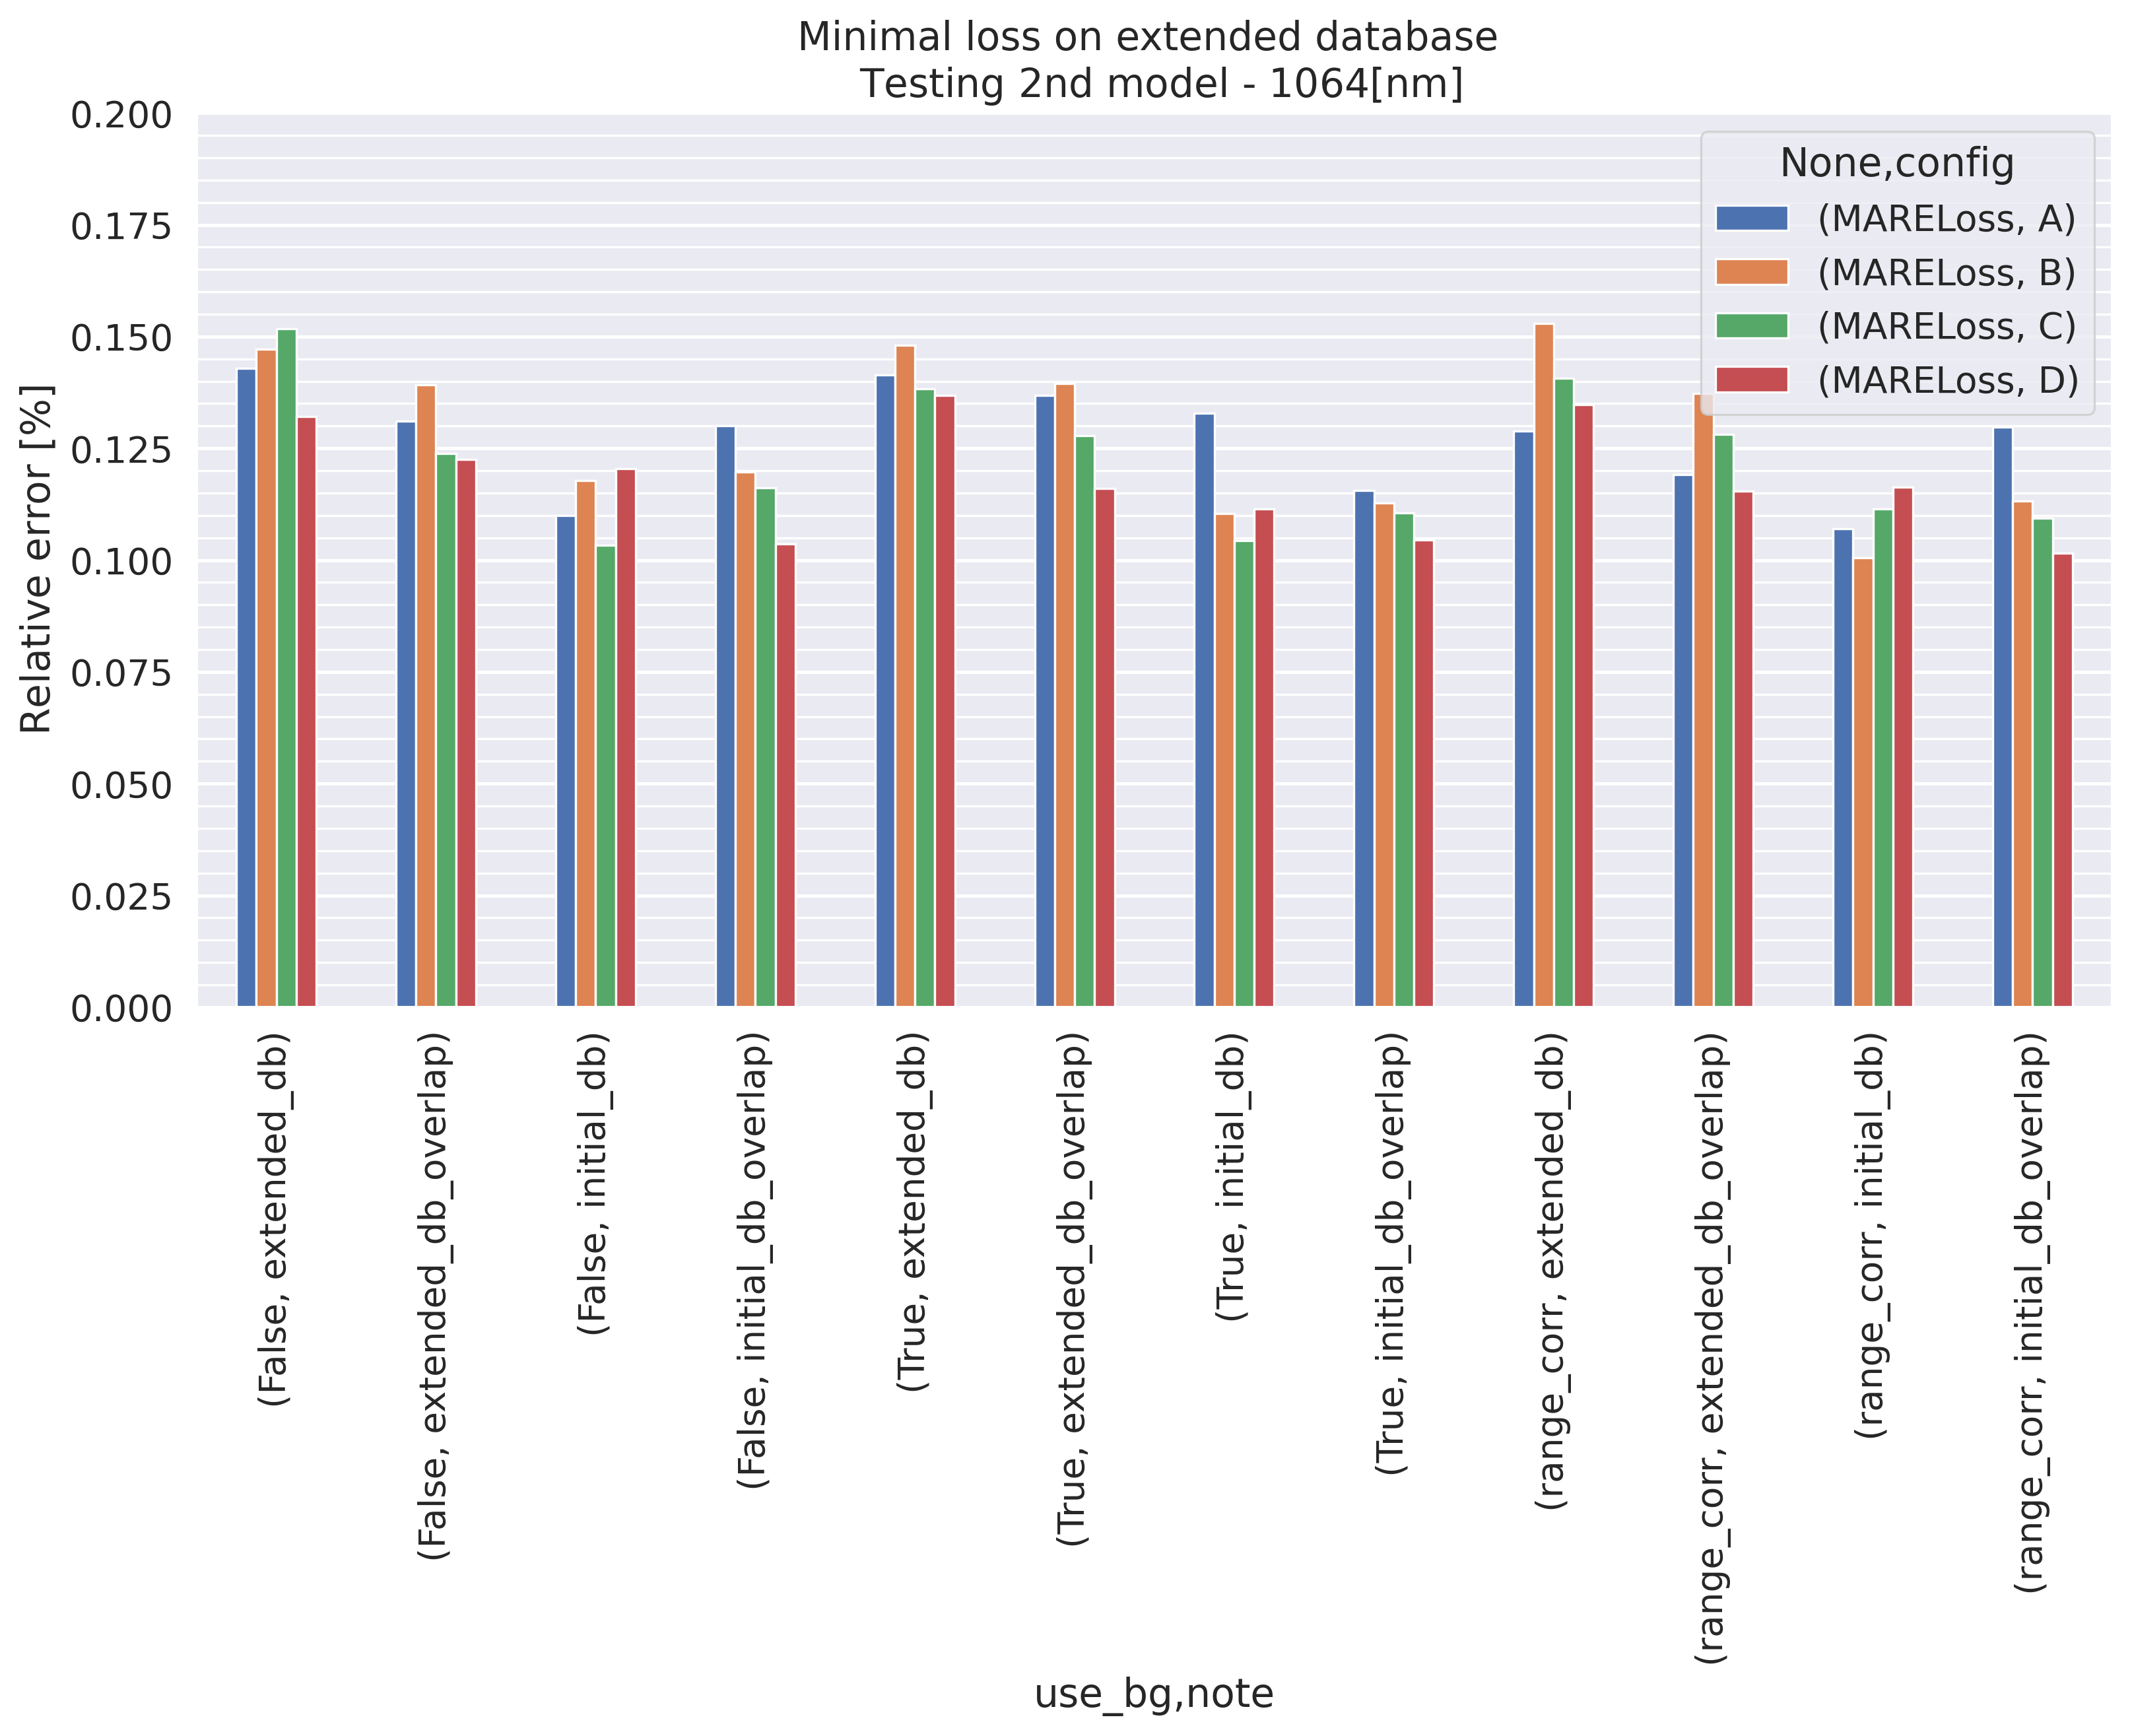

In [27]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 9))
    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power][all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'note'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n Testing 2nd model - '+ fr'${wavelength}[\rm nm]$' )
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()


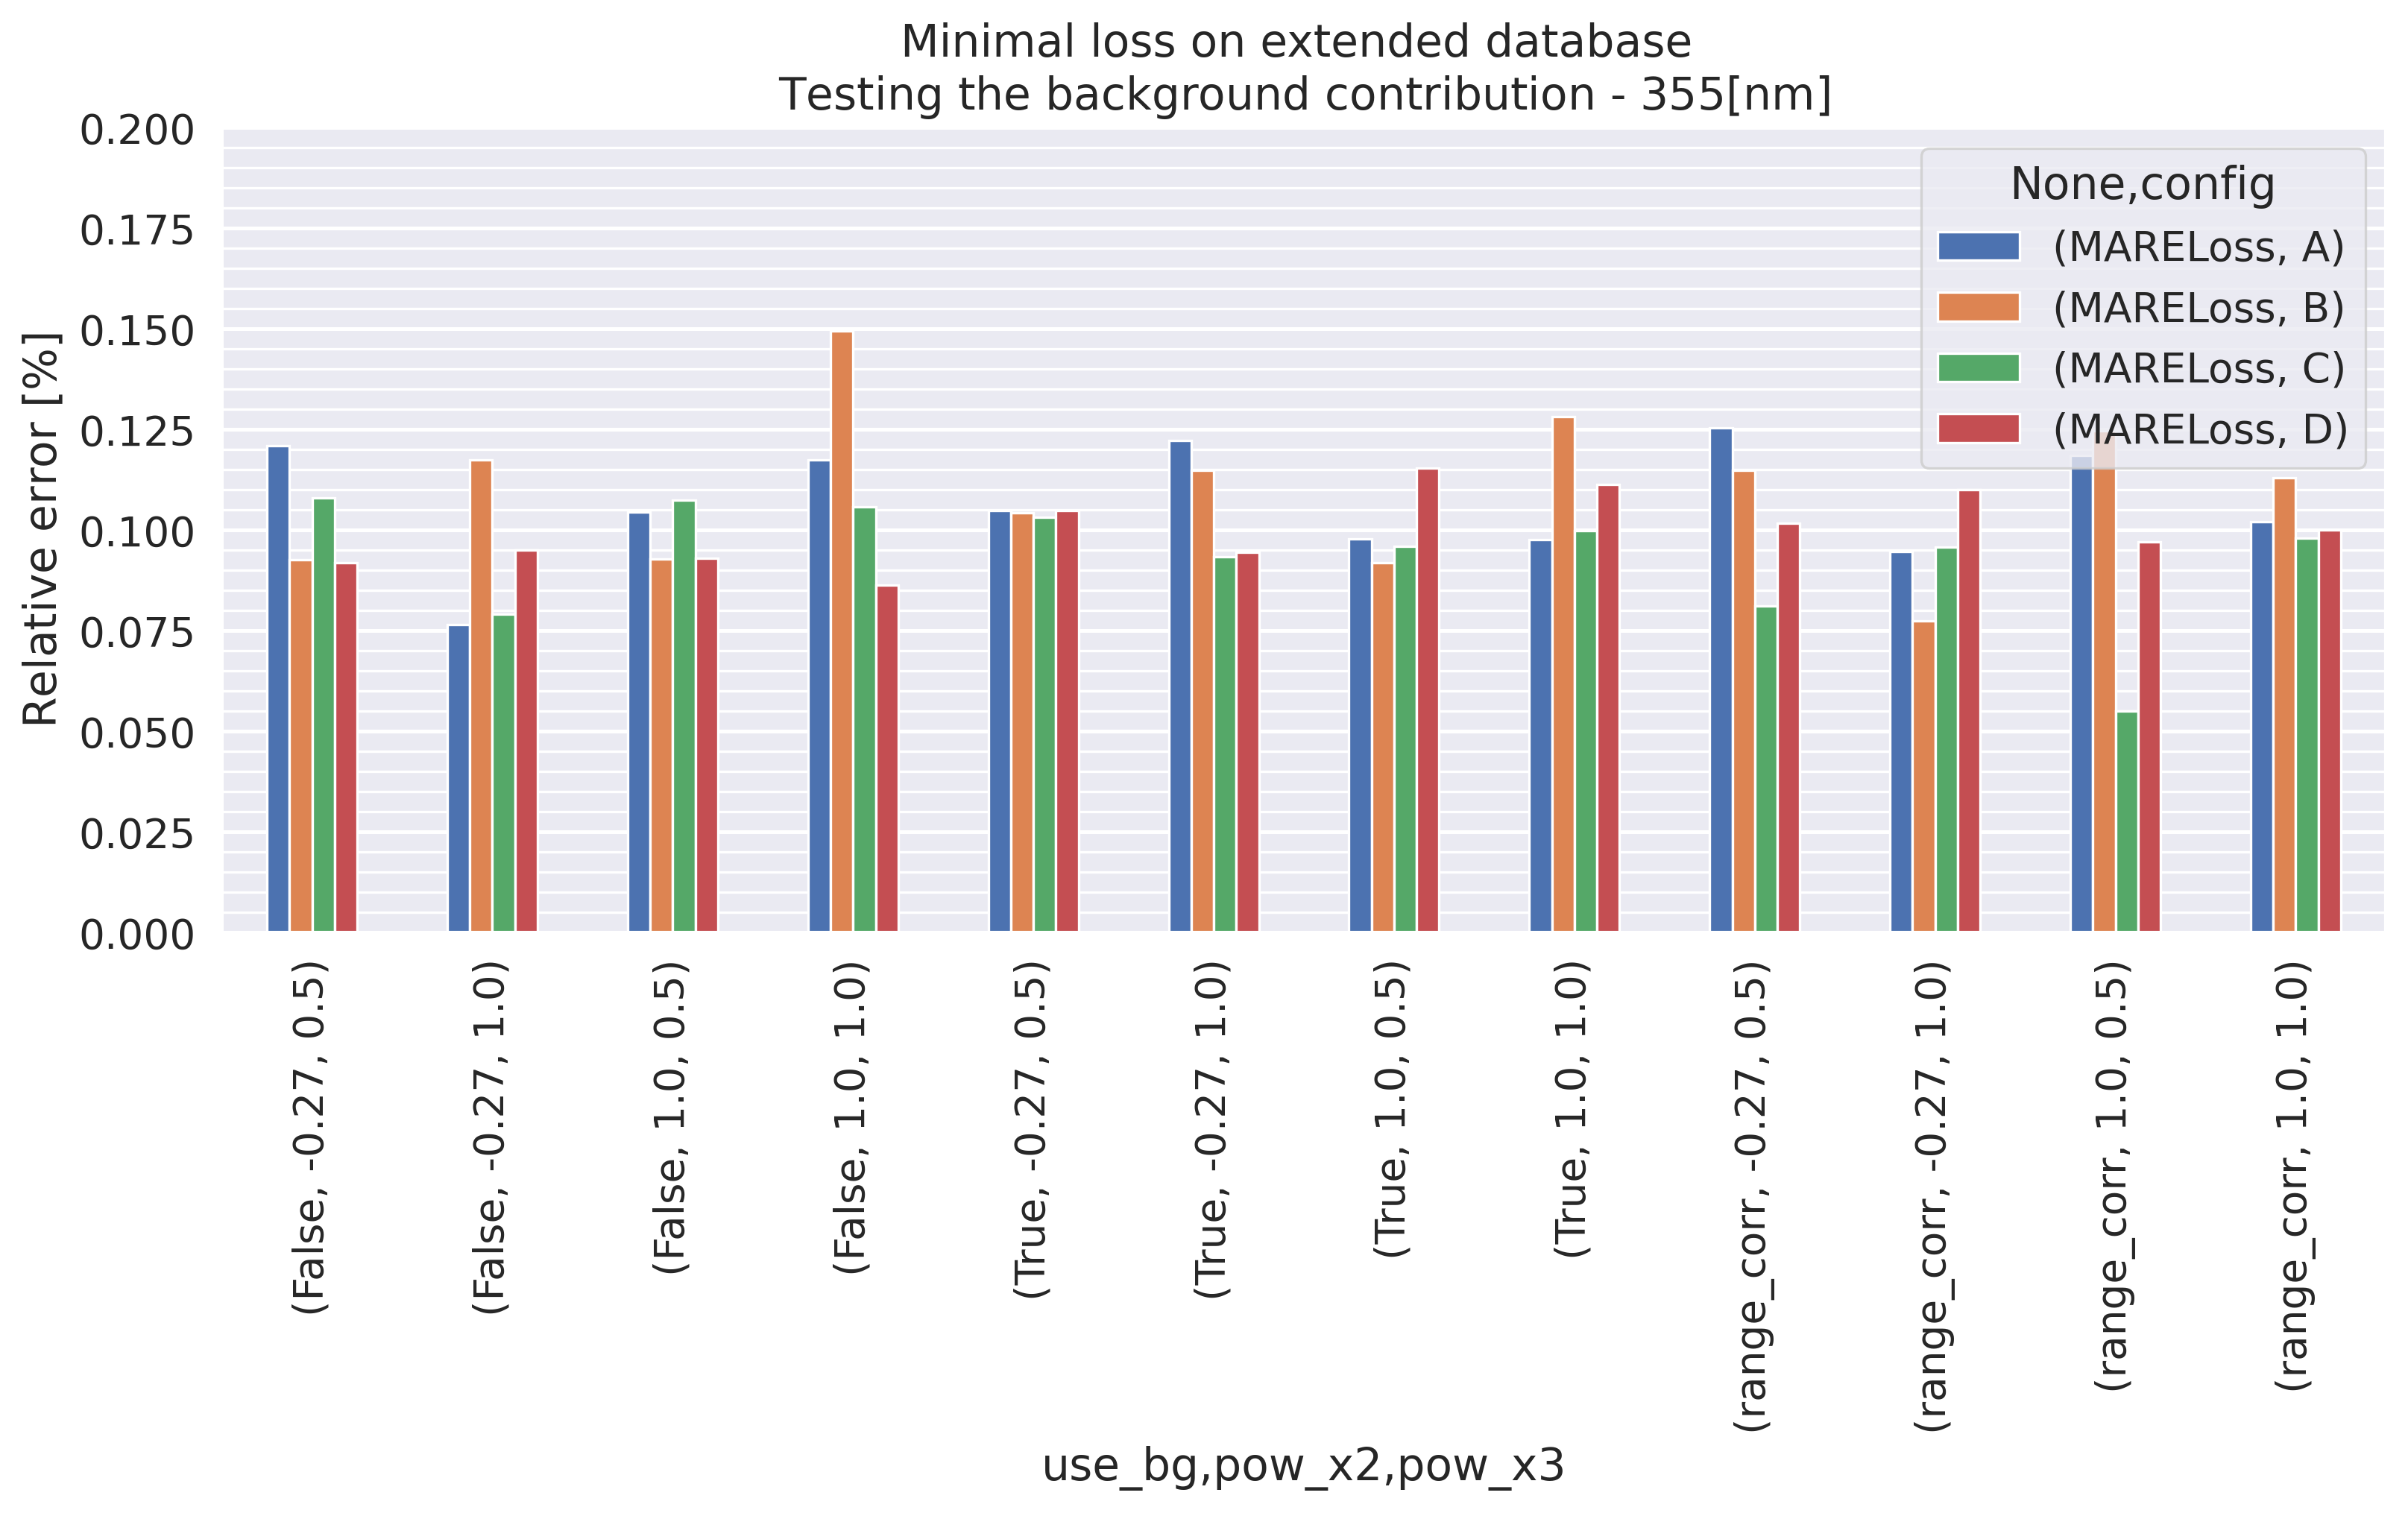

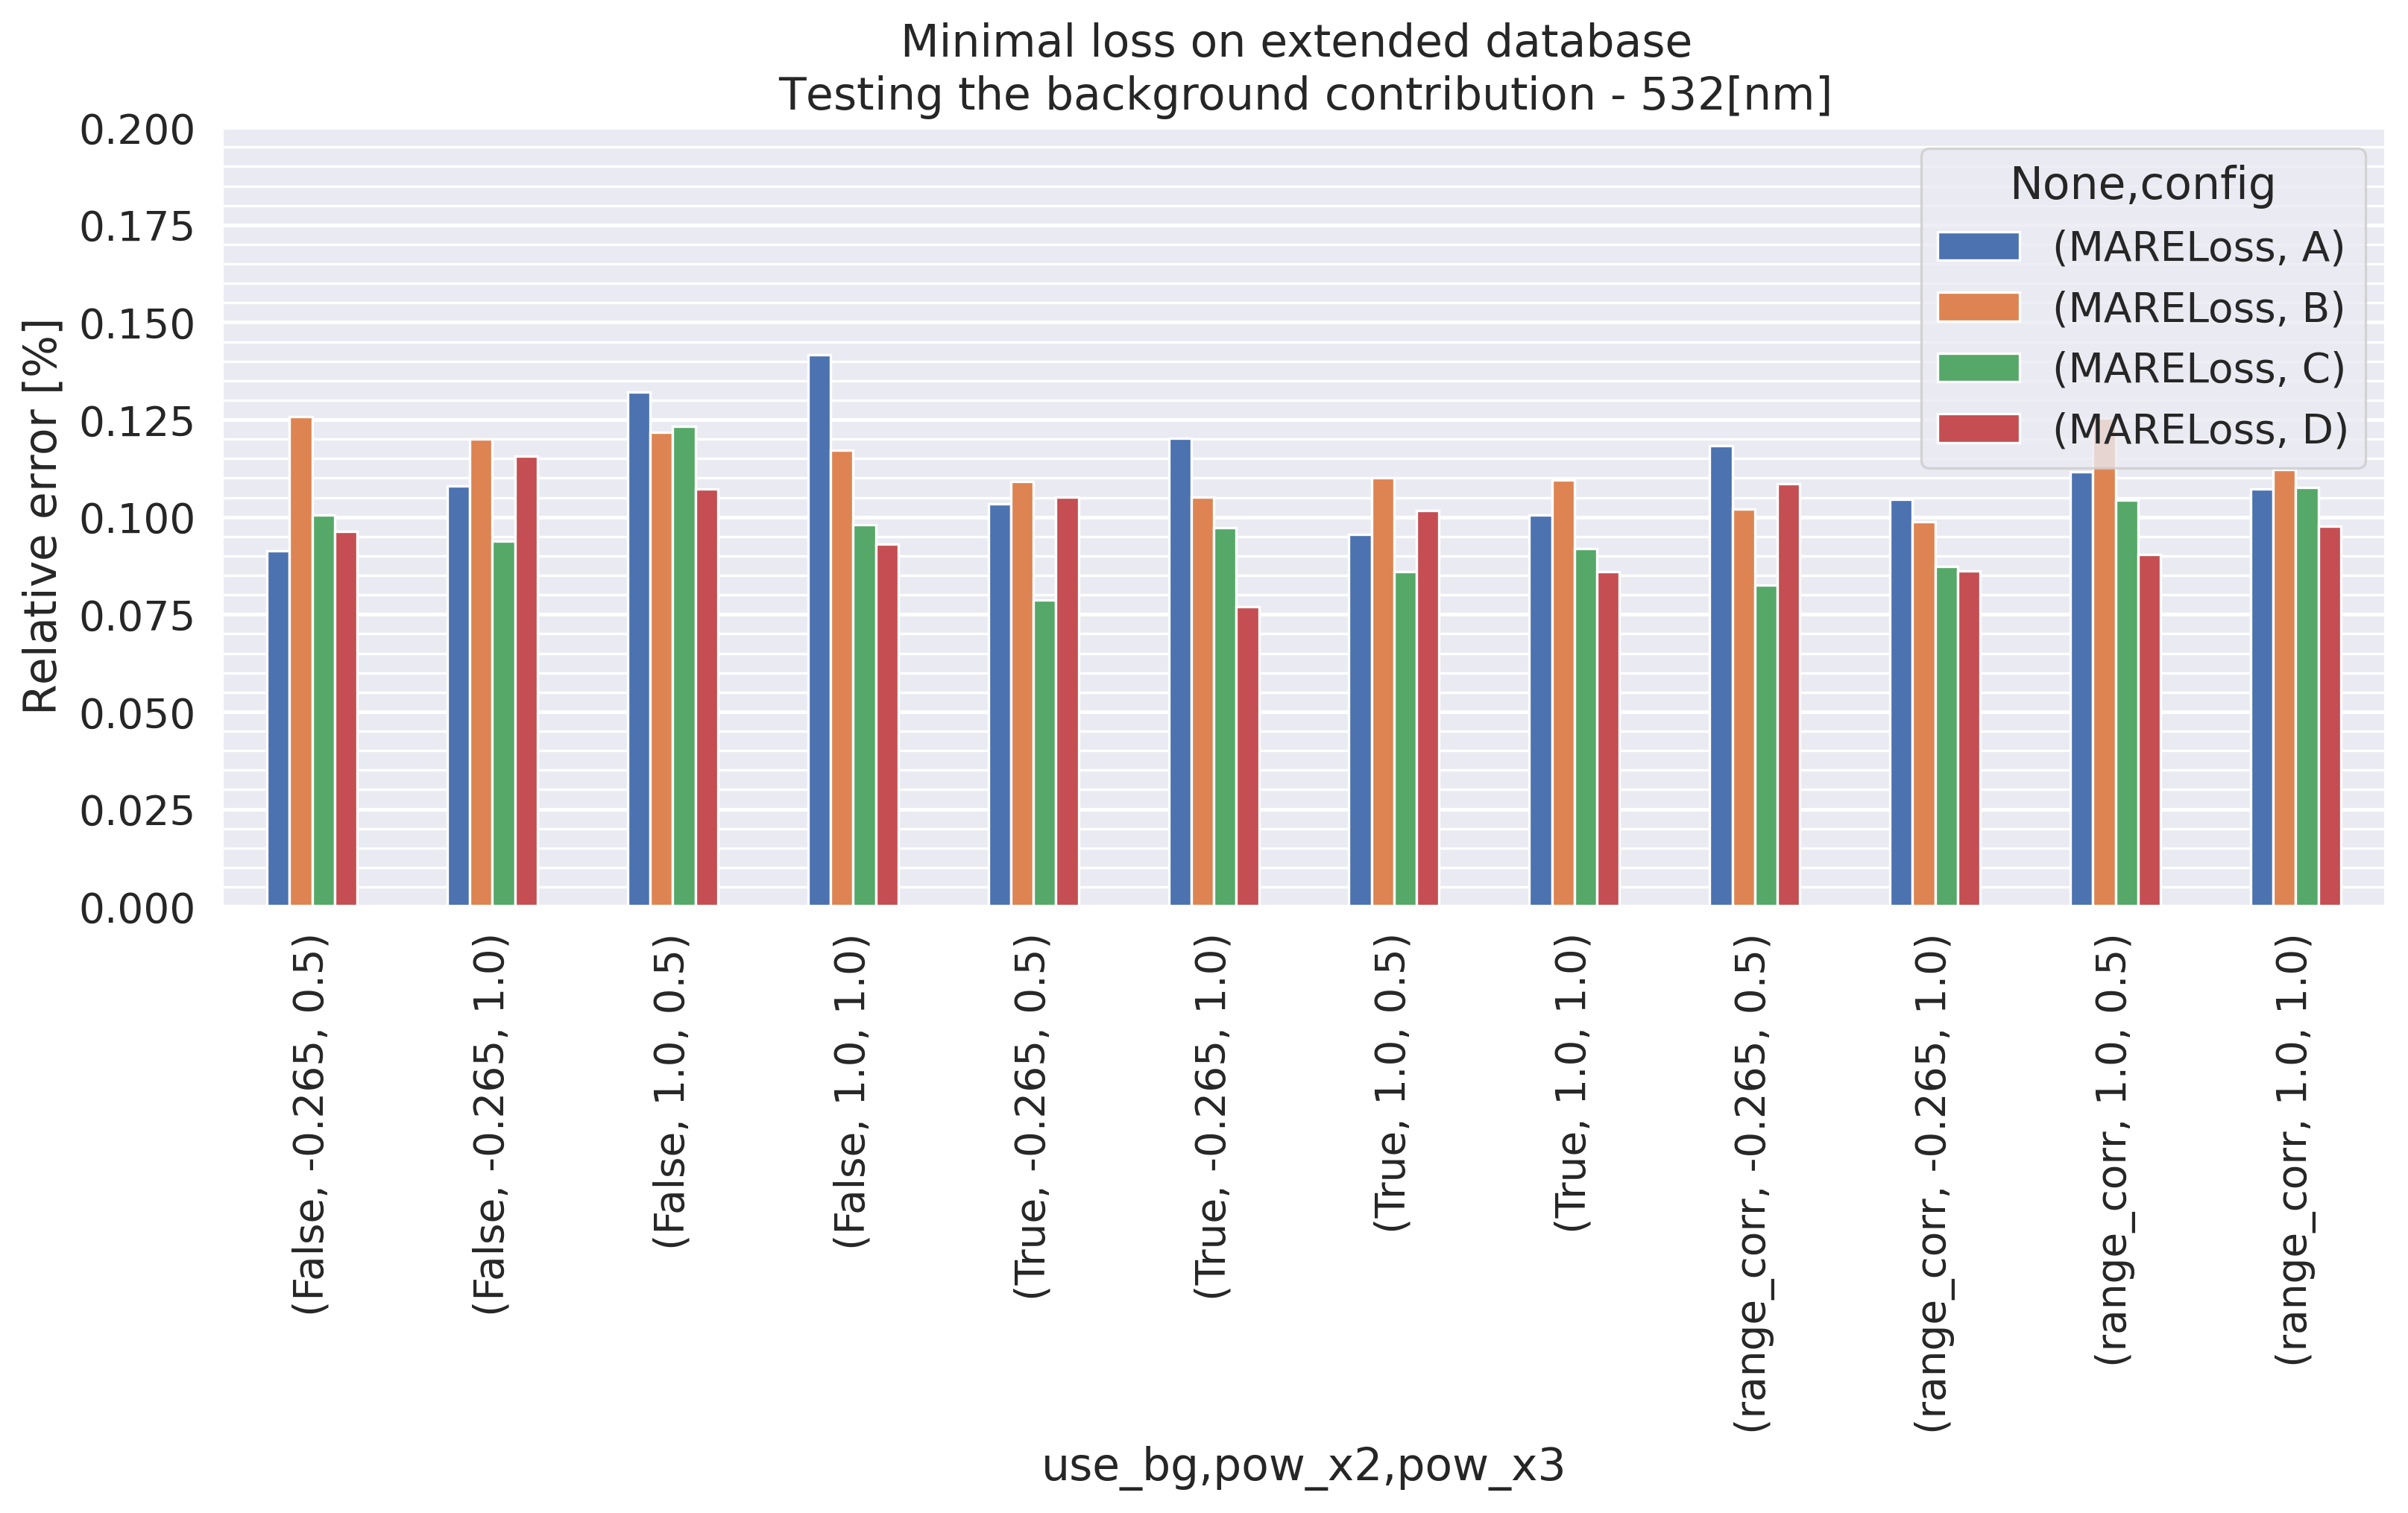

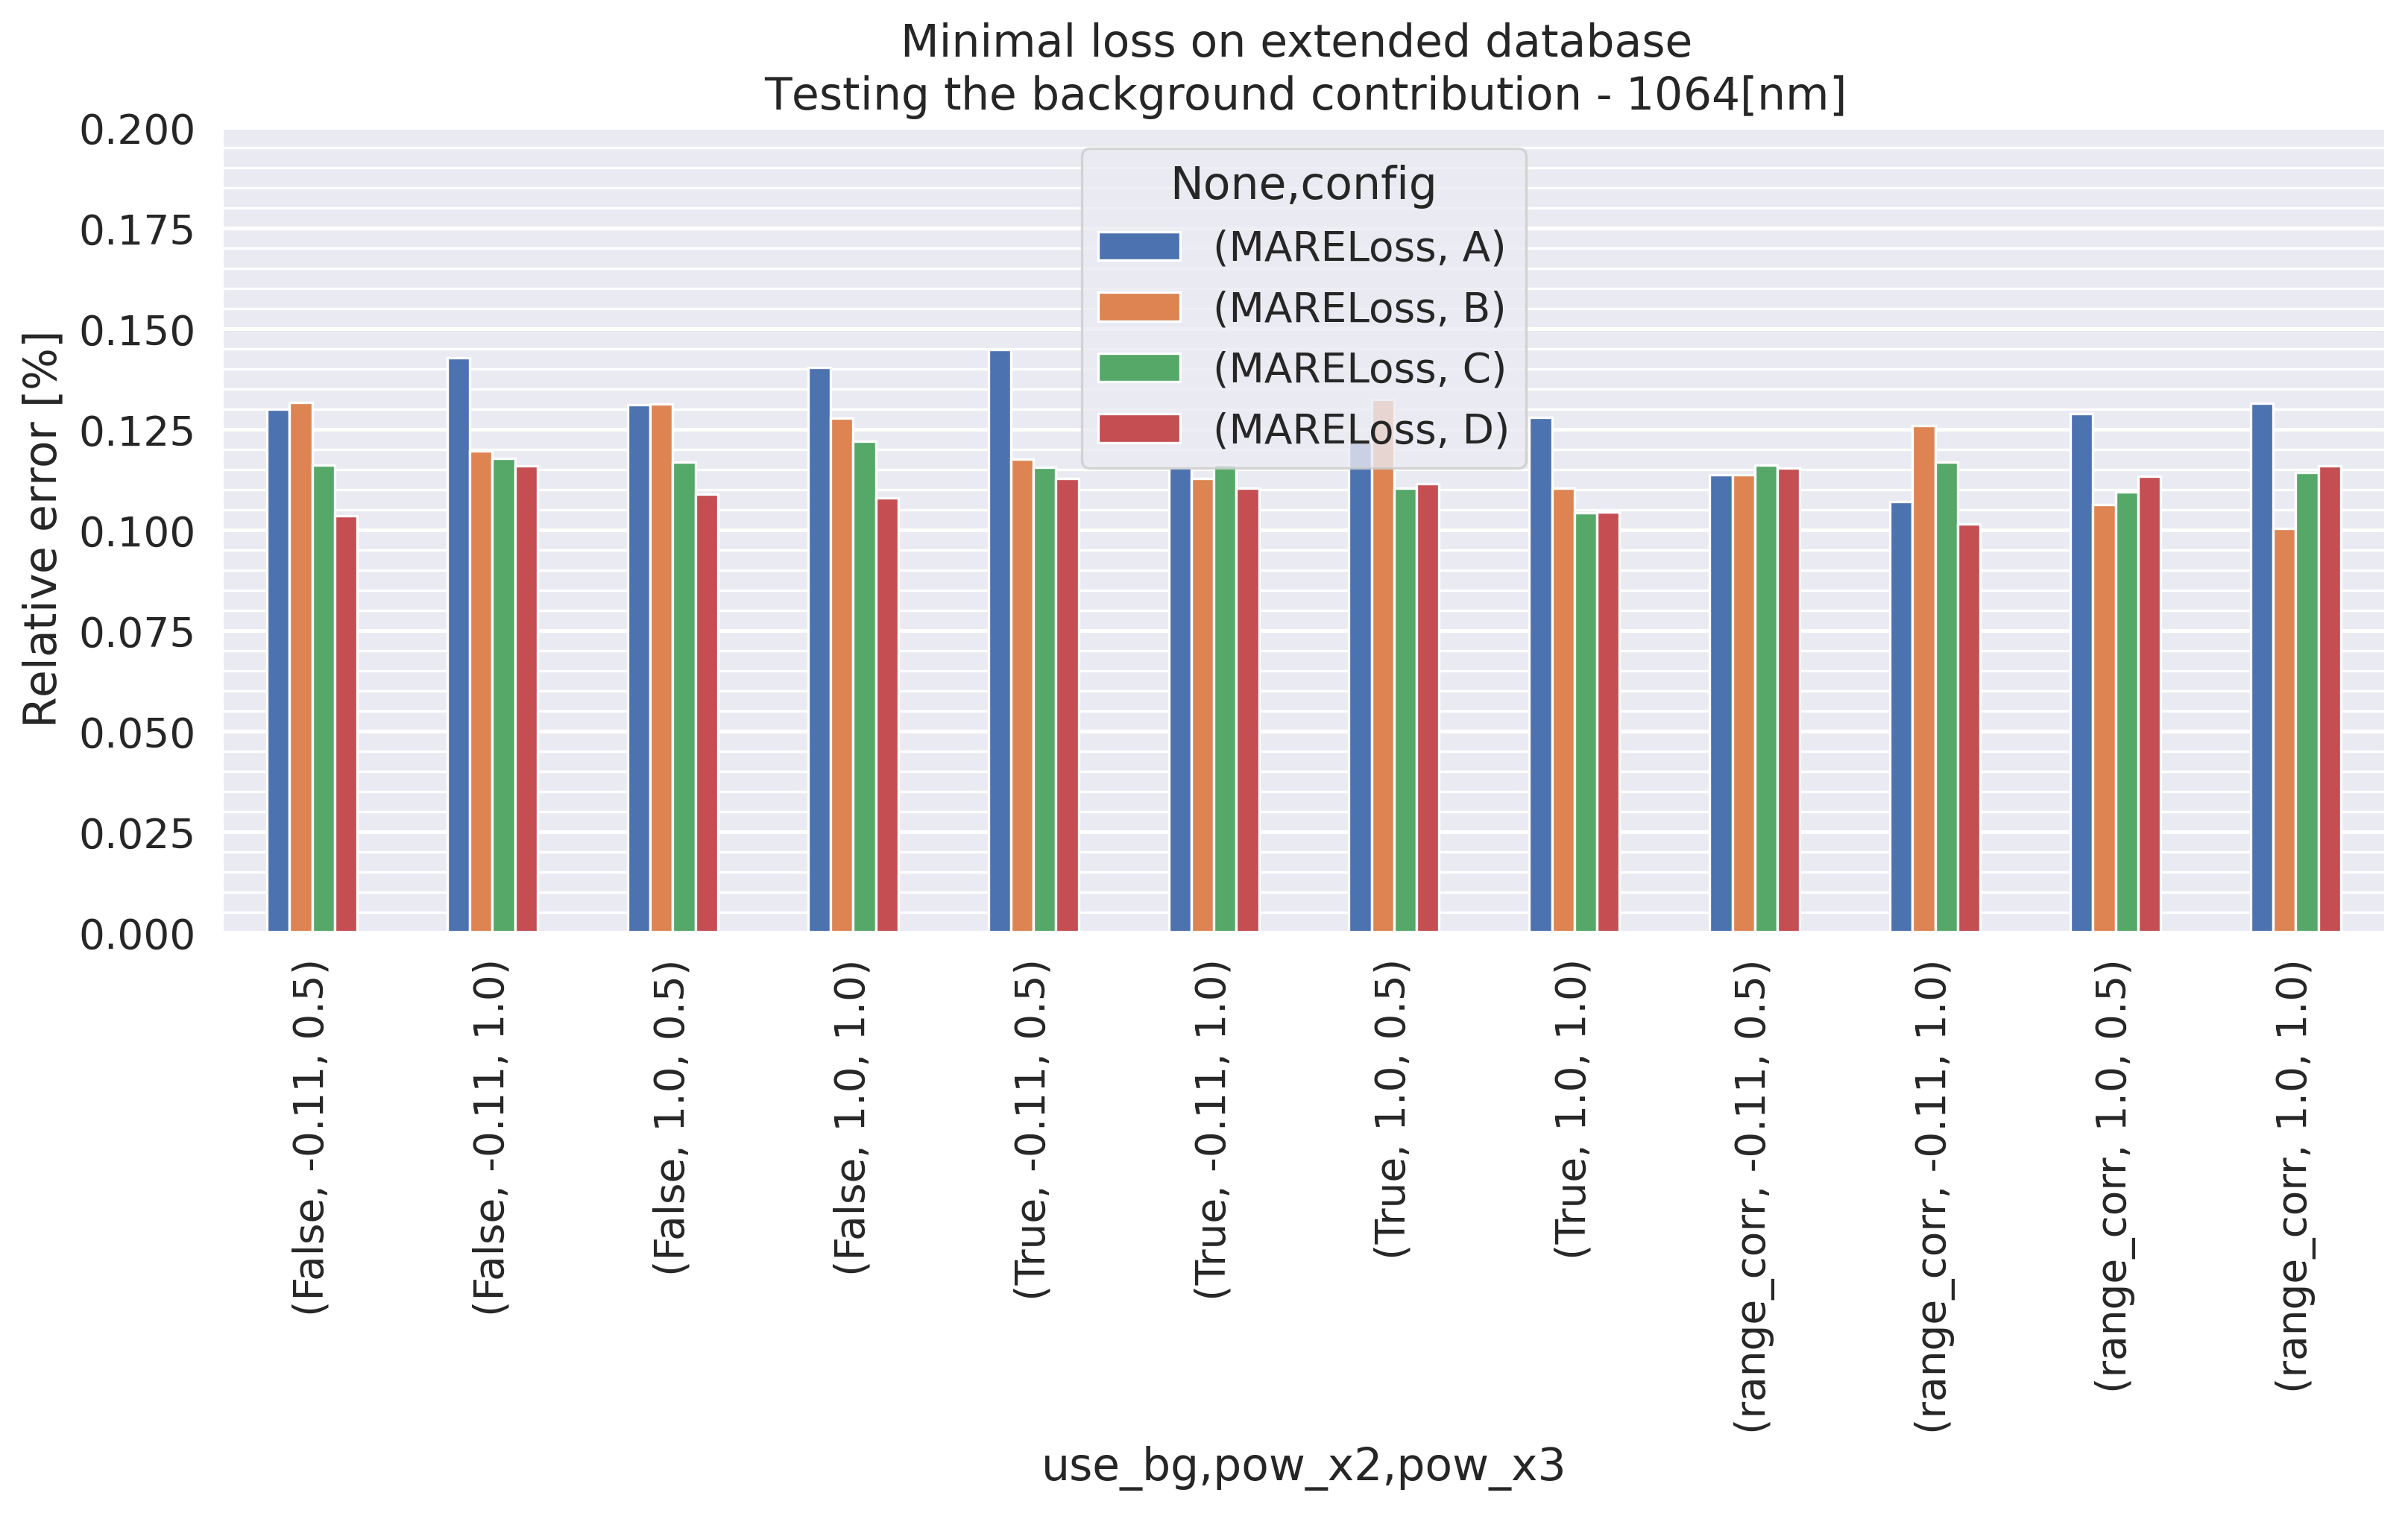

In [28]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

    pd.pivot_table(all_wavs_configABCD
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n'+fr'Testing the background contribution - ${wavelength}[\rm nm]$')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()

<ipython-input-29-f8727c8cfc7c>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==False][all_wavs_configABCD.note=='extended_db'],


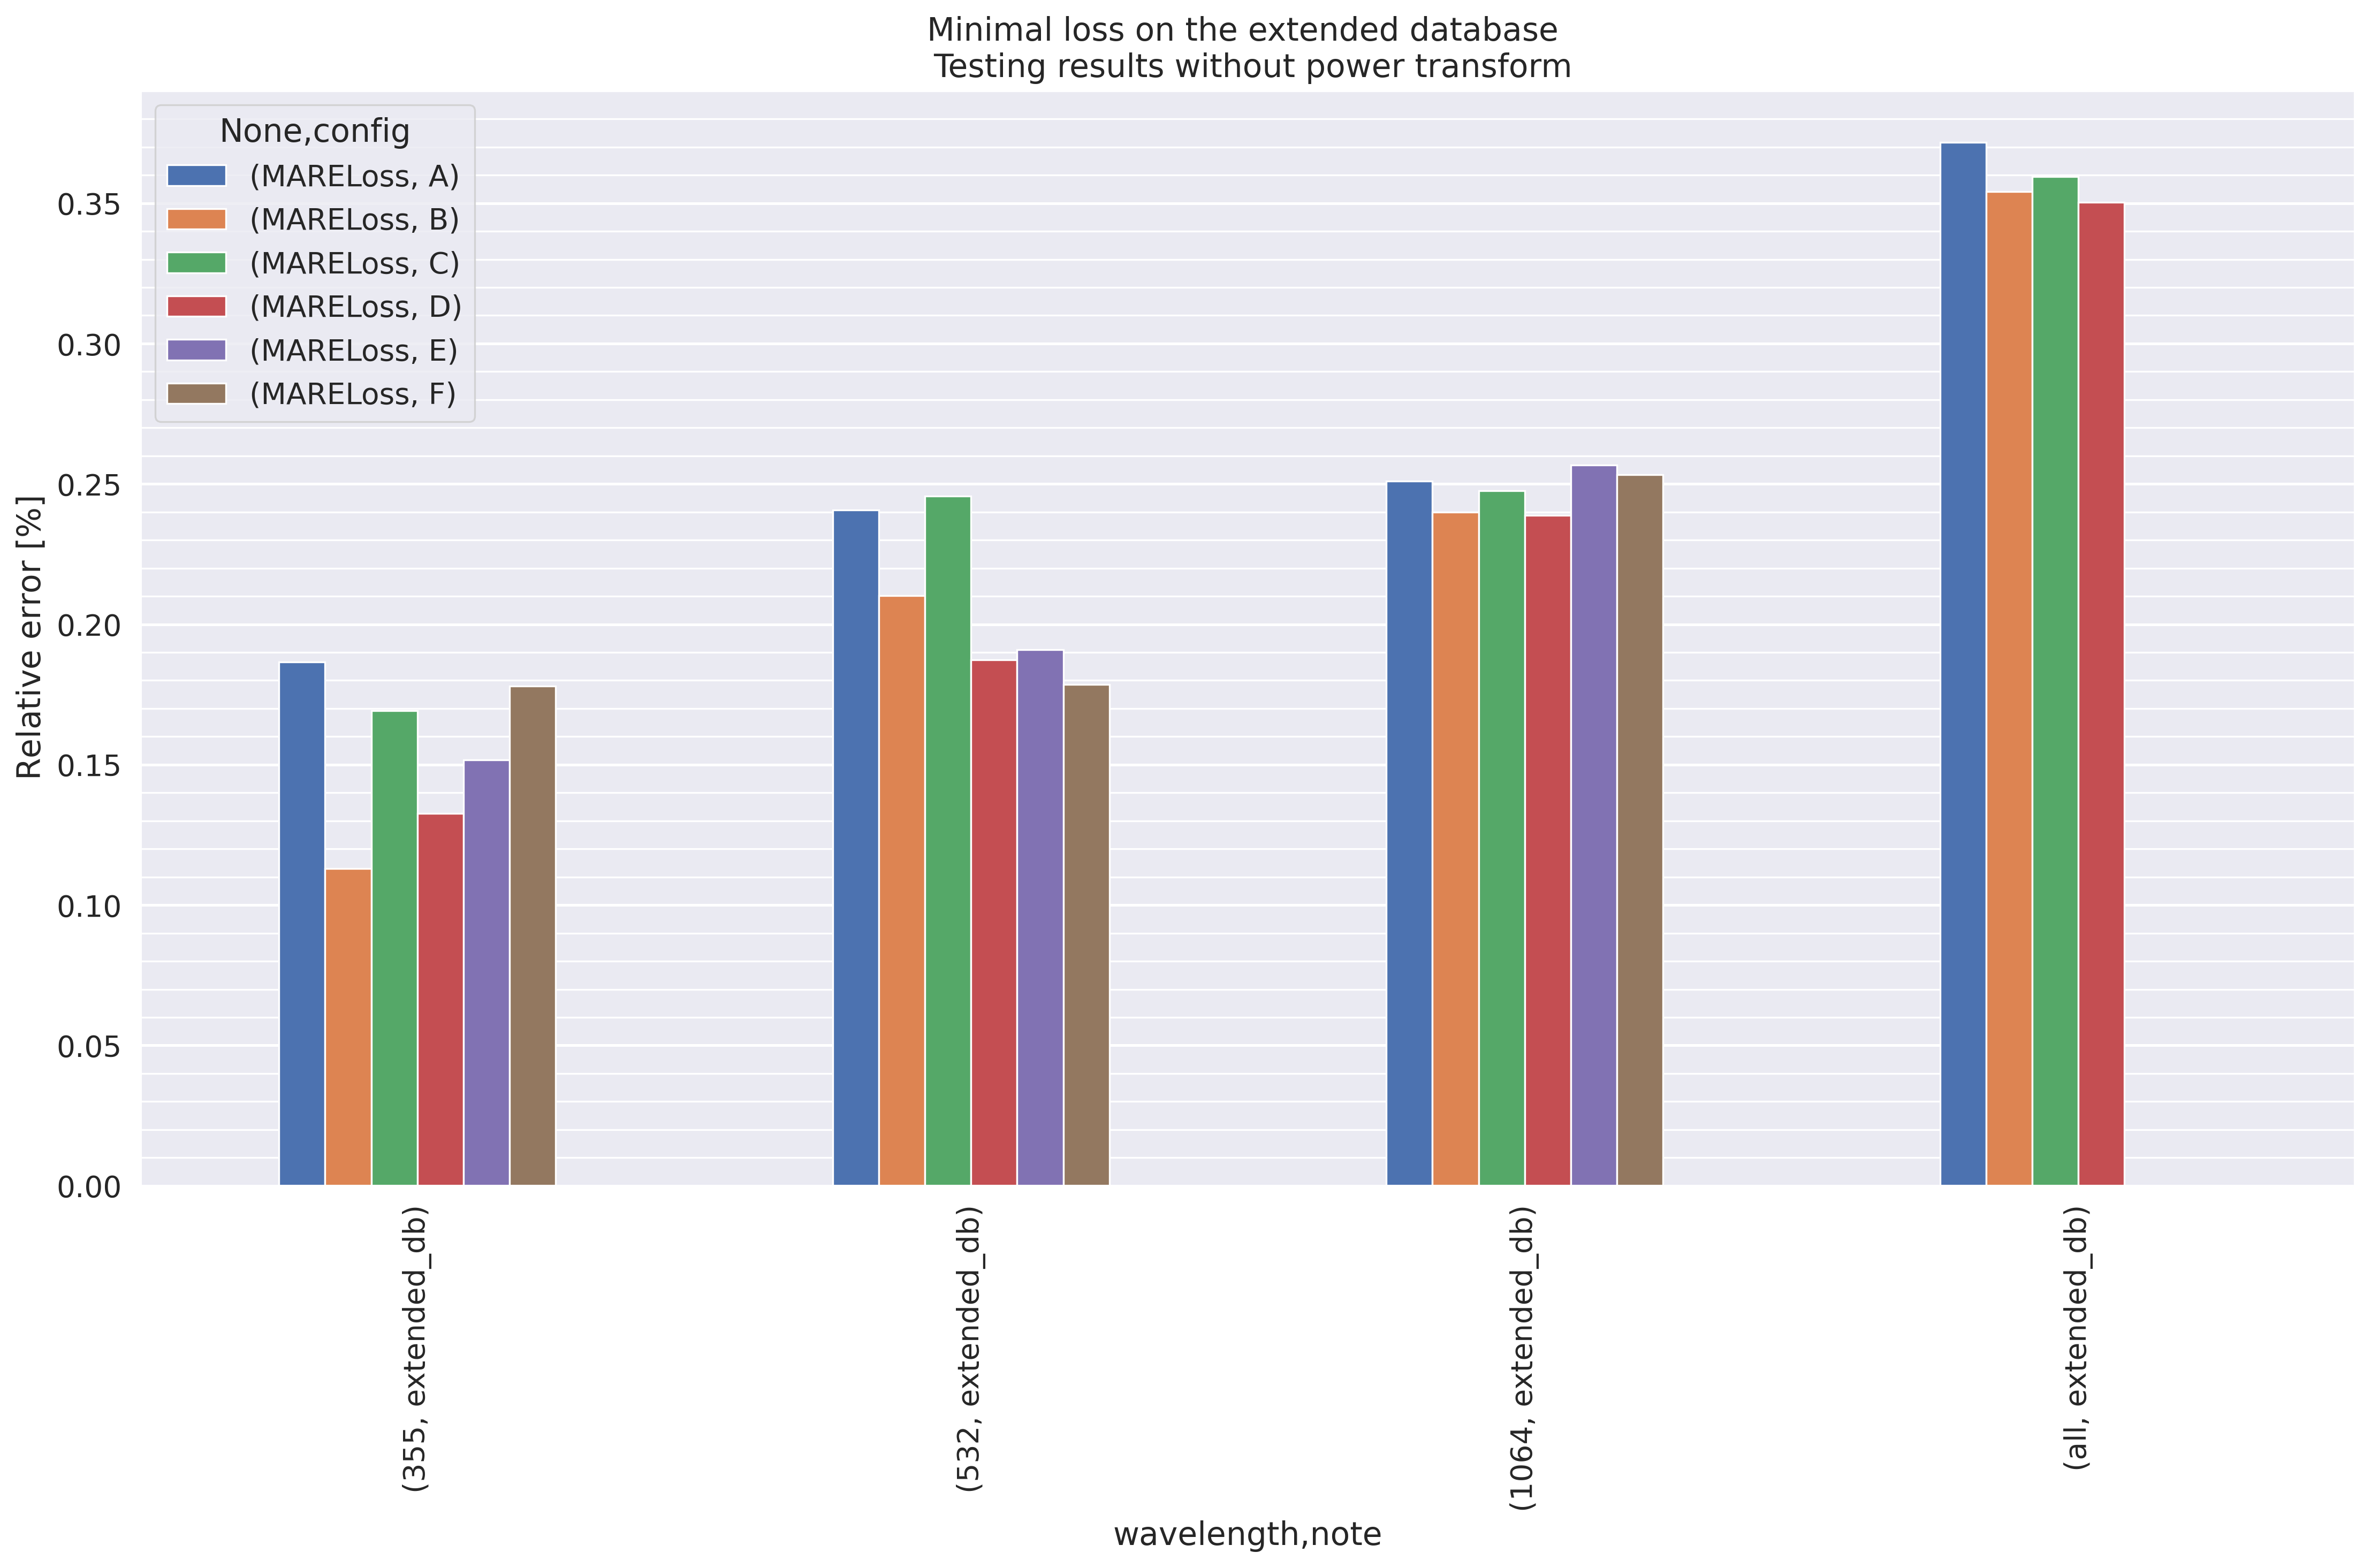

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==False][all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','note'],#'use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on the extended database \n Testing results without power transform')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()